In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model

#If you are using Tensorflow 1.x
from keras.optimizers import Adam
#If you are using Tensorflow 2
#from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

import os

from PIL import Image

Using TensorFlow backend.


# Parameters

In [ ]:
#folder containing dataset
data_path = 'C:\Downloads\Dataset'

#how many epochs to run the model
epoch = 200001

#how many epochs between saving your model
interval = 100

#how many images to train at one time. If your batch size is less than 9, alter the save_img function to plot less images
batch = 10

#if the data is pngs set this to True to remove alpha layer from images
png = False

# Load dataset from local files

In [2]:
def load_data():
        data = []
        small = []
        paths = []
        #get all files in this folder
        for r, d, f in os.walk(data_path):
            for file in f:
                if '.jpg' in file or if '.png' in file or if '.jpeg' in file:
                    paths.append(os.path.join(r, file))
        #for each file add normal resolution and low resolution to arrays
        for path in paths:
            img = Image.open(path)
            x = np.array(img.resize((64,64)))
            y = np.array(img.resize((256,256)))
            if(png):
                x = x[...,:3]
            data.append(y)
            small.append(x)
            
        #reshaping data to be four dimension required for input to neural network
        y_train = np.array(data)
        y_train = y_train.reshape(len(data),256,256,3)
        x_train = np.array(small)
        x_train = x_train.reshape(len(small),64,64,3)
        del data
        del small
        del paths
        return y_train, x_train

In [3]:
class SRGAN():
    def __init__(self):
        
        # Shape of high resolution output image
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        # Shape of low resolution input image
        self.latent_dim = (64,64,3)

        #optimizer (learning rate and beta values)
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        generator = self.generator

        # The generator takes image as input and generates high resolution image
        z = Input(shape=self.latent_dim)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()
        model.add(Conv2D(64, input_shape=self.latent_dim, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(3, kernel_size=(5,5), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.summary()

        noise = Input(shape=self.latent_dim)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        Y_train, X_train = load_data()

        # Rescale to be between 0 & 1
        X_train = X_train / 255
        Y_train = Y_train / 255

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Placeholder for loss function values
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, Y_train.shape[0], batch_size)
            imgs = Y_train[idx]

            # Generate super resolution images from the random batch of images
            gen_imgs = self.generator.predict(X_train[idx])

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(X_train[idx], valid)
            
            #save loss history
            g_loss_epochs[epoch] = g_loss
            d_loss_epochs[epoch] = d_loss[0]

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, X_train, idx)
            
        return g_loss_epochs, d_loss_epochs

    def save_imgs(self, epoch, X_train, idx):
        r, c = 3, 3
        # Select 9 random images
        index = np.random.randint(0, X_train.shape[0], 9)
        images = X_train[idx]
        # Super resolution the images
        gen_imgs = self.generator.predict(images)
        gen_imgs = np.array(gen_imgs) * 255
        gen_imgs = gen_imgs.astype(int)
        # Plot each image
        fig=plt.figure(figsize=(20, 20))
        for i in range(1, c*r+1):
            img = gen_imgs[i-1]
            fig.add_subplot(r, c, i)
            plt.imshow(img)
        fig.savefig('epoch_%d.png' % epoch)
        plt.close()
        # save model to .h5 file
        self.generator.save('generator" + str(epoch) + ".h5')

# Create Model and View Summary

In [4]:
gan = SRGAN()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 64)       

# Train Model

In [5]:
g_loss, d_loss = gan.train(epochs=epoch, batch_size=batch, save_interval=interval)

C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0

0 [D loss: 1.590858, acc.: 35.00%] [G loss: 0.313840]


C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 1.713904, acc.: 50.00%] [G loss: 4.322936]
2 [D loss: 1.941591, acc.: 30.00%] [G loss: 2.468442]
3 [D loss: 1.675858, acc.: 10.00%] [G loss: 1.111761]
4 [D loss: 0.638017, acc.: 60.00%] [G loss: 3.097847]
5 [D loss: 2.166039, acc.: 5.00%] [G loss: 0.661602]
6 [D loss: 1.363369, acc.: 50.00%] [G loss: 2.873225]
7 [D loss: 1.940008, acc.: 0.00%] [G loss: 0.952012]
8 [D loss: 0.952574, acc.: 45.00%] [G loss: 2.214525]
9 [D loss: 0.449926, acc.: 85.00%] [G loss: 2.137399]
10 [D loss: 0.564761, acc.: 50.00%] [G loss: 1.200908]
11 [D loss: 0.484914, acc.: 65.00%] [G loss: 2.571524]
12 [D loss: 0.447843, acc.: 85.00%] [G loss: 1.662567]
13 [D loss: 0.723225, acc.: 40.00%] [G loss: 0.617790]
14 [D loss: 0.847403, acc.: 55.00%] [G loss: 1.620771]
15 [D loss: 0.366420, acc.: 80.00%] [G loss: 1.772528]
16 [D loss: 0.621994, acc.: 65.00%] [G loss: 2.484259]
17 [D loss: 0.597840, acc.: 60.00%] [G loss: 2.534756]
18 [D loss: 1.524584, acc.: 25.00%] [G loss: 2.943120]
19 [D loss: 2.204397,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


100 [D loss: 1.466125, acc.: 30.00%] [G loss: 2.663334]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


101 [D loss: 1.102908, acc.: 45.00%] [G loss: 2.227574]
102 [D loss: 1.179034, acc.: 30.00%] [G loss: 2.359572]
103 [D loss: 1.330086, acc.: 30.00%] [G loss: 2.256466]
104 [D loss: 1.557028, acc.: 40.00%] [G loss: 2.961576]
105 [D loss: 1.497356, acc.: 25.00%] [G loss: 3.391342]
106 [D loss: 1.718158, acc.: 20.00%] [G loss: 2.076080]
107 [D loss: 1.253708, acc.: 35.00%] [G loss: 2.862430]
108 [D loss: 1.691682, acc.: 25.00%] [G loss: 2.821941]
109 [D loss: 1.247450, acc.: 20.00%] [G loss: 2.333867]
110 [D loss: 1.139214, acc.: 35.00%] [G loss: 3.455834]
111 [D loss: 0.626056, acc.: 65.00%] [G loss: 2.526026]
112 [D loss: 1.622154, acc.: 20.00%] [G loss: 2.336640]
113 [D loss: 0.750257, acc.: 60.00%] [G loss: 2.728914]
114 [D loss: 1.991415, acc.: 20.00%] [G loss: 1.494825]
115 [D loss: 0.975317, acc.: 55.00%] [G loss: 3.079586]
116 [D loss: 1.425098, acc.: 50.00%] [G loss: 1.650028]
117 [D loss: 1.038243, acc.: 50.00%] [G loss: 2.185238]
118 [D loss: 1.365247, acc.: 35.00%] [G loss: 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


200 [D loss: 1.412615, acc.: 35.00%] [G loss: 1.466763]
201 [D loss: 1.481097, acc.: 25.00%] [G loss: 2.600664]
202 [D loss: 1.251126, acc.: 35.00%] [G loss: 2.605040]
203 [D loss: 1.516640, acc.: 20.00%] [G loss: 1.906894]
204 [D loss: 1.348851, acc.: 25.00%] [G loss: 2.645576]
205 [D loss: 0.742983, acc.: 60.00%] [G loss: 3.361416]
206 [D loss: 1.831555, acc.: 25.00%] [G loss: 1.724539]
207 [D loss: 2.014237, acc.: 25.00%] [G loss: 1.723982]
208 [D loss: 1.609892, acc.: 40.00%] [G loss: 2.183895]
209 [D loss: 1.850644, acc.: 35.00%] [G loss: 1.253239]
210 [D loss: 1.172805, acc.: 35.00%] [G loss: 1.878580]
211 [D loss: 1.744789, acc.: 20.00%] [G loss: 2.216822]
212 [D loss: 1.777609, acc.: 25.00%] [G loss: 1.908757]
213 [D loss: 1.559689, acc.: 20.00%] [G loss: 2.622365]
214 [D loss: 1.458502, acc.: 30.00%] [G loss: 2.420430]
215 [D loss: 1.542321, acc.: 30.00%] [G loss: 1.836159]
216 [D loss: 1.843412, acc.: 10.00%] [G loss: 2.614796]
217 [D loss: 1.640015, acc.: 10.00%] [G loss: 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


300 [D loss: 1.980848, acc.: 20.00%] [G loss: 2.604624]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


301 [D loss: 0.804639, acc.: 60.00%] [G loss: 2.481966]
302 [D loss: 1.005181, acc.: 45.00%] [G loss: 3.026994]
303 [D loss: 1.725493, acc.: 25.00%] [G loss: 2.025031]
304 [D loss: 1.217028, acc.: 45.00%] [G loss: 2.212658]
305 [D loss: 1.497704, acc.: 30.00%] [G loss: 1.809465]
306 [D loss: 0.900074, acc.: 60.00%] [G loss: 2.278852]
307 [D loss: 1.453397, acc.: 25.00%] [G loss: 2.438787]
308 [D loss: 0.765480, acc.: 60.00%] [G loss: 2.171109]
309 [D loss: 2.010039, acc.: 5.00%] [G loss: 2.194864]
310 [D loss: 1.464928, acc.: 30.00%] [G loss: 2.245390]
311 [D loss: 1.621582, acc.: 35.00%] [G loss: 1.484261]
312 [D loss: 0.832209, acc.: 60.00%] [G loss: 2.446325]
313 [D loss: 1.208253, acc.: 45.00%] [G loss: 1.826597]
314 [D loss: 1.493120, acc.: 35.00%] [G loss: 1.351951]
315 [D loss: 1.904001, acc.: 15.00%] [G loss: 1.849831]
316 [D loss: 1.214534, acc.: 35.00%] [G loss: 2.676966]
317 [D loss: 1.884052, acc.: 20.00%] [G loss: 2.208917]
318 [D loss: 1.061995, acc.: 55.00%] [G loss: 1.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


400 [D loss: 1.442664, acc.: 30.00%] [G loss: 2.225505]
401 [D loss: 1.267795, acc.: 25.00%] [G loss: 1.880177]
402 [D loss: 1.096018, acc.: 50.00%] [G loss: 2.259336]
403 [D loss: 1.358682, acc.: 40.00%] [G loss: 3.007444]
404 [D loss: 1.478946, acc.: 25.00%] [G loss: 2.506880]
405 [D loss: 1.363433, acc.: 40.00%] [G loss: 1.728603]
406 [D loss: 1.704286, acc.: 10.00%] [G loss: 2.226580]
407 [D loss: 1.388565, acc.: 35.00%] [G loss: 2.913846]
408 [D loss: 1.879078, acc.: 15.00%] [G loss: 1.873234]
409 [D loss: 1.643834, acc.: 30.00%] [G loss: 2.074973]
410 [D loss: 1.190937, acc.: 35.00%] [G loss: 1.934436]
411 [D loss: 0.834092, acc.: 60.00%] [G loss: 2.180130]
412 [D loss: 0.979036, acc.: 40.00%] [G loss: 2.585194]
413 [D loss: 1.193588, acc.: 30.00%] [G loss: 1.980959]
414 [D loss: 1.101338, acc.: 40.00%] [G loss: 2.146744]
415 [D loss: 0.948415, acc.: 45.00%] [G loss: 3.077283]
416 [D loss: 0.839117, acc.: 50.00%] [G loss: 2.281545]
417 [D loss: 0.525245, acc.: 70.00%] [G loss: 3.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


500 [D loss: 1.208059, acc.: 40.00%] [G loss: 2.874726]
501 [D loss: 0.595488, acc.: 60.00%] [G loss: 2.944474]
502 [D loss: 1.894236, acc.: 40.00%] [G loss: 1.749011]
503 [D loss: 0.889623, acc.: 50.00%] [G loss: 3.288878]
504 [D loss: 0.746629, acc.: 55.00%] [G loss: 2.493135]
505 [D loss: 1.222398, acc.: 35.00%] [G loss: 2.170171]
506 [D loss: 0.820789, acc.: 60.00%] [G loss: 3.248149]
507 [D loss: 1.292970, acc.: 55.00%] [G loss: 1.826335]
508 [D loss: 1.161484, acc.: 55.00%] [G loss: 2.771899]
509 [D loss: 1.059072, acc.: 50.00%] [G loss: 3.208075]
510 [D loss: 0.828946, acc.: 55.00%] [G loss: 3.092792]
511 [D loss: 1.332356, acc.: 50.00%] [G loss: 1.834156]
512 [D loss: 1.041165, acc.: 55.00%] [G loss: 2.617350]
513 [D loss: 0.665527, acc.: 75.00%] [G loss: 3.232195]
514 [D loss: 1.661343, acc.: 25.00%] [G loss: 2.879376]
515 [D loss: 0.519122, acc.: 80.00%] [G loss: 2.654449]
516 [D loss: 0.914728, acc.: 55.00%] [G loss: 3.483953]
517 [D loss: 1.256056, acc.: 55.00%] [G loss: 2.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


600 [D loss: 1.121602, acc.: 50.00%] [G loss: 2.867160]
601 [D loss: 1.149517, acc.: 35.00%] [G loss: 2.007445]
602 [D loss: 0.727245, acc.: 65.00%] [G loss: 2.429649]
603 [D loss: 0.739048, acc.: 75.00%] [G loss: 3.106057]
604 [D loss: 0.872881, acc.: 55.00%] [G loss: 3.661378]
605 [D loss: 1.304658, acc.: 30.00%] [G loss: 3.949982]
606 [D loss: 0.902513, acc.: 60.00%] [G loss: 2.437064]
607 [D loss: 1.264033, acc.: 40.00%] [G loss: 2.057894]
608 [D loss: 0.857821, acc.: 45.00%] [G loss: 2.819234]
609 [D loss: 0.699827, acc.: 60.00%] [G loss: 3.323577]
610 [D loss: 0.757336, acc.: 60.00%] [G loss: 1.529876]
611 [D loss: 1.836110, acc.: 35.00%] [G loss: 1.540794]
612 [D loss: 0.445958, acc.: 75.00%] [G loss: 3.655894]
613 [D loss: 1.178582, acc.: 40.00%] [G loss: 3.157017]
614 [D loss: 0.430641, acc.: 70.00%] [G loss: 3.784684]
615 [D loss: 0.917919, acc.: 50.00%] [G loss: 1.679130]
616 [D loss: 0.494495, acc.: 80.00%] [G loss: 1.855511]
617 [D loss: 0.852860, acc.: 55.00%] [G loss: 2.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


700 [D loss: 0.612099, acc.: 75.00%] [G loss: 2.912856]
701 [D loss: 1.092382, acc.: 50.00%] [G loss: 1.748027]
702 [D loss: 0.837997, acc.: 65.00%] [G loss: 2.474457]
703 [D loss: 0.716190, acc.: 55.00%] [G loss: 2.886625]
704 [D loss: 0.866340, acc.: 55.00%] [G loss: 2.039515]
705 [D loss: 1.091983, acc.: 45.00%] [G loss: 3.263669]
706 [D loss: 0.618932, acc.: 70.00%] [G loss: 1.836404]
707 [D loss: 0.720675, acc.: 65.00%] [G loss: 3.183727]
708 [D loss: 0.371793, acc.: 75.00%] [G loss: 3.585489]
709 [D loss: 0.704257, acc.: 65.00%] [G loss: 2.321838]
710 [D loss: 0.487816, acc.: 75.00%] [G loss: 4.042864]
711 [D loss: 0.665335, acc.: 60.00%] [G loss: 2.209834]
712 [D loss: 1.002128, acc.: 45.00%] [G loss: 1.668423]
713 [D loss: 0.487048, acc.: 75.00%] [G loss: 3.040008]
714 [D loss: 0.838468, acc.: 60.00%] [G loss: 2.735374]
715 [D loss: 0.929663, acc.: 50.00%] [G loss: 3.541213]
716 [D loss: 0.815705, acc.: 60.00%] [G loss: 2.384733]
717 [D loss: 0.655883, acc.: 70.00%] [G loss: 3.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


800 [D loss: 0.823739, acc.: 60.00%] [G loss: 2.053811]
801 [D loss: 0.548523, acc.: 75.00%] [G loss: 3.825243]
802 [D loss: 0.590760, acc.: 65.00%] [G loss: 2.573881]
803 [D loss: 1.037833, acc.: 60.00%] [G loss: 2.086153]
804 [D loss: 0.519806, acc.: 80.00%] [G loss: 2.597293]
805 [D loss: 1.071636, acc.: 60.00%] [G loss: 2.101625]
806 [D loss: 0.975011, acc.: 60.00%] [G loss: 3.726590]
807 [D loss: 1.025298, acc.: 60.00%] [G loss: 2.548129]
808 [D loss: 1.073543, acc.: 45.00%] [G loss: 3.863340]
809 [D loss: 0.540758, acc.: 70.00%] [G loss: 3.340272]
810 [D loss: 1.207335, acc.: 40.00%] [G loss: 2.342923]
811 [D loss: 0.622273, acc.: 75.00%] [G loss: 3.546260]
812 [D loss: 1.310200, acc.: 40.00%] [G loss: 1.609076]
813 [D loss: 0.898786, acc.: 75.00%] [G loss: 3.803289]
814 [D loss: 0.206581, acc.: 90.00%] [G loss: 3.049790]
815 [D loss: 1.084934, acc.: 45.00%] [G loss: 2.385957]
816 [D loss: 1.001216, acc.: 35.00%] [G loss: 3.368501]
817 [D loss: 0.656845, acc.: 65.00%] [G loss: 3.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


900 [D loss: 1.142441, acc.: 45.00%] [G loss: 3.913849]
901 [D loss: 0.854520, acc.: 65.00%] [G loss: 3.903802]
902 [D loss: 0.149387, acc.: 100.00%] [G loss: 3.620184]
903 [D loss: 1.110445, acc.: 55.00%] [G loss: 2.452617]
904 [D loss: 0.803436, acc.: 50.00%] [G loss: 3.080683]
905 [D loss: 1.221719, acc.: 35.00%] [G loss: 1.489579]
906 [D loss: 1.045547, acc.: 45.00%] [G loss: 3.010595]
907 [D loss: 0.774776, acc.: 50.00%] [G loss: 2.938763]
908 [D loss: 1.124302, acc.: 55.00%] [G loss: 2.594743]
909 [D loss: 0.792627, acc.: 50.00%] [G loss: 2.533976]
910 [D loss: 0.452964, acc.: 75.00%] [G loss: 2.545188]
911 [D loss: 0.543879, acc.: 65.00%] [G loss: 2.777827]
912 [D loss: 0.786316, acc.: 65.00%] [G loss: 3.262908]
913 [D loss: 1.357390, acc.: 50.00%] [G loss: 2.422864]
914 [D loss: 0.891064, acc.: 60.00%] [G loss: 2.840476]
915 [D loss: 0.587313, acc.: 65.00%] [G loss: 2.553332]
916 [D loss: 1.390030, acc.: 45.00%] [G loss: 1.950360]
917 [D loss: 0.686989, acc.: 70.00%] [G loss: 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000 [D loss: 1.324095, acc.: 45.00%] [G loss: 2.478086]
1001 [D loss: 1.048567, acc.: 45.00%] [G loss: 2.661670]
1002 [D loss: 0.836987, acc.: 50.00%] [G loss: 3.636234]
1003 [D loss: 0.543861, acc.: 80.00%] [G loss: 3.482334]
1004 [D loss: 0.699544, acc.: 75.00%] [G loss: 3.155509]
1005 [D loss: 0.494193, acc.: 70.00%] [G loss: 2.895915]
1006 [D loss: 0.756775, acc.: 55.00%] [G loss: 3.082738]
1007 [D loss: 0.469525, acc.: 85.00%] [G loss: 2.538352]
1008 [D loss: 0.582447, acc.: 70.00%] [G loss: 2.608236]
1009 [D loss: 0.940290, acc.: 65.00%] [G loss: 2.498469]
1010 [D loss: 0.409983, acc.: 85.00%] [G loss: 3.014446]
1011 [D loss: 0.718310, acc.: 75.00%] [G loss: 3.255052]
1012 [D loss: 0.495494, acc.: 80.00%] [G loss: 2.754052]
1013 [D loss: 1.375901, acc.: 40.00%] [G loss: 3.099839]
1014 [D loss: 1.072588, acc.: 65.00%] [G loss: 3.105410]
1015 [D loss: 0.773876, acc.: 65.00%] [G loss: 3.195040]
1016 [D loss: 0.675015, acc.: 60.00%] [G loss: 1.872069]
1017 [D loss: 0.716221, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1100 [D loss: 1.374196, acc.: 30.00%] [G loss: 3.454635]
1101 [D loss: 0.788831, acc.: 65.00%] [G loss: 2.152544]
1102 [D loss: 0.731068, acc.: 70.00%] [G loss: 2.610839]
1103 [D loss: 1.012639, acc.: 60.00%] [G loss: 2.077850]
1104 [D loss: 0.484183, acc.: 75.00%] [G loss: 2.444770]
1105 [D loss: 1.226363, acc.: 45.00%] [G loss: 2.044254]
1106 [D loss: 0.342499, acc.: 80.00%] [G loss: 3.963937]
1107 [D loss: 0.825004, acc.: 65.00%] [G loss: 2.584956]
1108 [D loss: 0.651715, acc.: 70.00%] [G loss: 2.308045]
1109 [D loss: 0.804528, acc.: 60.00%] [G loss: 2.574343]
1110 [D loss: 0.560169, acc.: 75.00%] [G loss: 2.993254]
1111 [D loss: 0.840240, acc.: 55.00%] [G loss: 3.417063]
1112 [D loss: 0.848242, acc.: 65.00%] [G loss: 3.441914]
1113 [D loss: 0.758649, acc.: 65.00%] [G loss: 3.085759]
1114 [D loss: 0.291782, acc.: 90.00%] [G loss: 4.084101]
1115 [D loss: 0.339356, acc.: 85.00%] [G loss: 2.894555]
1116 [D loss: 0.471435, acc.: 70.00%] [G loss: 2.861758]
1117 [D loss: 0.858430, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1200 [D loss: 0.428640, acc.: 85.00%] [G loss: 2.760532]
1201 [D loss: 0.793805, acc.: 65.00%] [G loss: 3.195443]
1202 [D loss: 0.264100, acc.: 95.00%] [G loss: 2.558150]
1203 [D loss: 0.591517, acc.: 75.00%] [G loss: 2.196170]
1204 [D loss: 1.046798, acc.: 60.00%] [G loss: 3.085707]
1205 [D loss: 0.333062, acc.: 85.00%] [G loss: 4.317895]
1206 [D loss: 0.957363, acc.: 60.00%] [G loss: 2.074112]
1207 [D loss: 0.952730, acc.: 45.00%] [G loss: 2.682714]
1208 [D loss: 0.560476, acc.: 80.00%] [G loss: 3.545139]
1209 [D loss: 1.327473, acc.: 50.00%] [G loss: 1.807067]
1210 [D loss: 0.525336, acc.: 60.00%] [G loss: 3.193157]
1211 [D loss: 0.737930, acc.: 65.00%] [G loss: 1.713580]
1212 [D loss: 1.049164, acc.: 55.00%] [G loss: 2.846748]
1213 [D loss: 0.791312, acc.: 60.00%] [G loss: 3.383886]
1214 [D loss: 1.129242, acc.: 50.00%] [G loss: 3.092139]
1215 [D loss: 0.258981, acc.: 90.00%] [G loss: 2.202004]
1216 [D loss: 0.513725, acc.: 75.00%] [G loss: 3.305988]
1217 [D loss: 0.824206, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1300 [D loss: 0.555192, acc.: 60.00%] [G loss: 4.526722]
1301 [D loss: 0.704659, acc.: 55.00%] [G loss: 2.644844]
1302 [D loss: 0.570591, acc.: 70.00%] [G loss: 3.155348]
1303 [D loss: 1.134780, acc.: 50.00%] [G loss: 1.987511]
1304 [D loss: 0.631123, acc.: 60.00%] [G loss: 2.980248]
1305 [D loss: 0.611001, acc.: 70.00%] [G loss: 2.806506]
1306 [D loss: 1.022627, acc.: 55.00%] [G loss: 2.538903]
1307 [D loss: 1.039971, acc.: 45.00%] [G loss: 2.947278]
1308 [D loss: 0.527559, acc.: 80.00%] [G loss: 3.391317]
1309 [D loss: 0.574073, acc.: 60.00%] [G loss: 3.491371]
1310 [D loss: 0.969016, acc.: 70.00%] [G loss: 2.655312]
1311 [D loss: 0.867843, acc.: 60.00%] [G loss: 2.595159]
1312 [D loss: 1.066602, acc.: 60.00%] [G loss: 2.463458]
1313 [D loss: 0.506609, acc.: 70.00%] [G loss: 3.401823]
1314 [D loss: 1.017769, acc.: 60.00%] [G loss: 3.427664]
1315 [D loss: 0.656782, acc.: 65.00%] [G loss: 2.666378]
1316 [D loss: 0.705055, acc.: 50.00%] [G loss: 3.927087]
1317 [D loss: 0.697898, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1400 [D loss: 0.592978, acc.: 75.00%] [G loss: 2.914021]
1401 [D loss: 0.779863, acc.: 60.00%] [G loss: 2.991964]
1402 [D loss: 0.475078, acc.: 80.00%] [G loss: 2.858639]
1403 [D loss: 0.282432, acc.: 90.00%] [G loss: 1.847767]
1404 [D loss: 0.609963, acc.: 65.00%] [G loss: 3.182484]
1405 [D loss: 0.924704, acc.: 60.00%] [G loss: 2.638803]
1406 [D loss: 0.561127, acc.: 80.00%] [G loss: 2.428445]
1407 [D loss: 0.623553, acc.: 60.00%] [G loss: 2.818377]
1408 [D loss: 0.608904, acc.: 60.00%] [G loss: 3.174315]
1409 [D loss: 0.846633, acc.: 65.00%] [G loss: 3.533137]
1410 [D loss: 0.495583, acc.: 75.00%] [G loss: 4.018350]
1411 [D loss: 1.010627, acc.: 55.00%] [G loss: 2.016235]
1412 [D loss: 0.649465, acc.: 80.00%] [G loss: 3.354841]
1413 [D loss: 0.416763, acc.: 80.00%] [G loss: 3.861937]
1414 [D loss: 0.542915, acc.: 70.00%] [G loss: 3.161685]
1415 [D loss: 0.859439, acc.: 60.00%] [G loss: 2.470819]
1416 [D loss: 1.146727, acc.: 55.00%] [G loss: 3.166740]
1417 [D loss: 0.324890, acc.: 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1500 [D loss: 0.711978, acc.: 65.00%] [G loss: 3.863041]
1501 [D loss: 0.995548, acc.: 55.00%] [G loss: 3.569607]
1502 [D loss: 1.275985, acc.: 35.00%] [G loss: 2.450160]
1503 [D loss: 0.324010, acc.: 85.00%] [G loss: 4.289722]
1504 [D loss: 0.618770, acc.: 75.00%] [G loss: 2.958359]
1505 [D loss: 0.509916, acc.: 75.00%] [G loss: 3.374922]
1506 [D loss: 0.438168, acc.: 80.00%] [G loss: 3.037814]
1507 [D loss: 0.878141, acc.: 40.00%] [G loss: 2.616575]
1508 [D loss: 0.539799, acc.: 75.00%] [G loss: 3.463871]
1509 [D loss: 1.015974, acc.: 55.00%] [G loss: 2.248241]
1510 [D loss: 0.520042, acc.: 75.00%] [G loss: 3.552495]
1511 [D loss: 0.534993, acc.: 85.00%] [G loss: 4.033263]
1512 [D loss: 0.585998, acc.: 70.00%] [G loss: 2.614085]
1513 [D loss: 0.904335, acc.: 70.00%] [G loss: 3.252656]
1514 [D loss: 0.646048, acc.: 60.00%] [G loss: 3.028811]
1515 [D loss: 0.555021, acc.: 70.00%] [G loss: 2.589613]
1516 [D loss: 0.802794, acc.: 55.00%] [G loss: 3.029868]
1517 [D loss: 0.883799, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1600 [D loss: 1.348950, acc.: 45.00%] [G loss: 3.756065]
1601 [D loss: 0.548483, acc.: 80.00%] [G loss: 3.408660]
1602 [D loss: 0.487352, acc.: 70.00%] [G loss: 2.042661]
1603 [D loss: 0.794565, acc.: 60.00%] [G loss: 3.659626]
1604 [D loss: 0.530436, acc.: 80.00%] [G loss: 2.595922]
1605 [D loss: 0.580958, acc.: 70.00%] [G loss: 2.735191]
1606 [D loss: 0.863286, acc.: 60.00%] [G loss: 4.136800]
1607 [D loss: 0.509821, acc.: 70.00%] [G loss: 2.514464]
1608 [D loss: 0.544066, acc.: 65.00%] [G loss: 1.764324]
1609 [D loss: 0.518793, acc.: 75.00%] [G loss: 4.064005]
1610 [D loss: 0.978055, acc.: 60.00%] [G loss: 3.293191]
1611 [D loss: 0.474081, acc.: 75.00%] [G loss: 3.665743]
1612 [D loss: 0.518656, acc.: 75.00%] [G loss: 2.790428]
1613 [D loss: 0.847212, acc.: 55.00%] [G loss: 3.132712]
1614 [D loss: 0.471217, acc.: 85.00%] [G loss: 2.507840]
1615 [D loss: 0.449590, acc.: 75.00%] [G loss: 3.657663]
1616 [D loss: 0.567949, acc.: 75.00%] [G loss: 2.736504]
1617 [D loss: 0.666137, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1700 [D loss: 0.644381, acc.: 55.00%] [G loss: 2.591316]
1701 [D loss: 0.351780, acc.: 85.00%] [G loss: 3.526891]
1702 [D loss: 0.341583, acc.: 90.00%] [G loss: 2.059405]
1703 [D loss: 0.607544, acc.: 85.00%] [G loss: 3.106726]
1704 [D loss: 0.829031, acc.: 65.00%] [G loss: 2.770657]
1705 [D loss: 0.273888, acc.: 85.00%] [G loss: 2.830219]
1706 [D loss: 0.368579, acc.: 80.00%] [G loss: 3.029829]
1707 [D loss: 0.749397, acc.: 55.00%] [G loss: 3.432156]
1708 [D loss: 0.577759, acc.: 65.00%] [G loss: 2.528156]
1709 [D loss: 0.537099, acc.: 65.00%] [G loss: 3.456857]
1710 [D loss: 0.226326, acc.: 95.00%] [G loss: 4.171320]
1711 [D loss: 1.059835, acc.: 50.00%] [G loss: 3.238991]
1712 [D loss: 0.533852, acc.: 85.00%] [G loss: 2.823385]
1713 [D loss: 0.939488, acc.: 55.00%] [G loss: 3.996002]
1714 [D loss: 1.021216, acc.: 55.00%] [G loss: 2.510291]
1715 [D loss: 0.468961, acc.: 80.00%] [G loss: 3.307134]
1716 [D loss: 0.514828, acc.: 80.00%] [G loss: 1.609693]
1717 [D loss: 0.424780, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1800 [D loss: 0.362729, acc.: 80.00%] [G loss: 2.966962]
1801 [D loss: 1.158637, acc.: 50.00%] [G loss: 2.305193]
1802 [D loss: 0.815797, acc.: 65.00%] [G loss: 2.558651]
1803 [D loss: 0.449251, acc.: 70.00%] [G loss: 3.074689]
1804 [D loss: 0.718776, acc.: 55.00%] [G loss: 4.851354]
1805 [D loss: 1.084151, acc.: 60.00%] [G loss: 2.576729]
1806 [D loss: 0.630379, acc.: 65.00%] [G loss: 2.656182]
1807 [D loss: 0.691609, acc.: 70.00%] [G loss: 2.333824]
1808 [D loss: 0.613023, acc.: 70.00%] [G loss: 2.491994]
1809 [D loss: 0.450311, acc.: 85.00%] [G loss: 2.212945]
1810 [D loss: 0.603109, acc.: 70.00%] [G loss: 2.908191]
1811 [D loss: 0.711636, acc.: 70.00%] [G loss: 1.682398]
1812 [D loss: 0.289674, acc.: 90.00%] [G loss: 3.304106]
1813 [D loss: 0.397553, acc.: 85.00%] [G loss: 3.995276]
1814 [D loss: 0.578103, acc.: 85.00%] [G loss: 1.827046]
1815 [D loss: 0.655980, acc.: 60.00%] [G loss: 1.771254]
1816 [D loss: 0.609940, acc.: 75.00%] [G loss: 3.480247]
1817 [D loss: 0.540053, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1900 [D loss: 0.614926, acc.: 65.00%] [G loss: 4.111358]
1901 [D loss: 0.282363, acc.: 90.00%] [G loss: 3.724533]
1902 [D loss: 0.477785, acc.: 70.00%] [G loss: 3.732714]
1903 [D loss: 0.721857, acc.: 55.00%] [G loss: 2.648217]
1904 [D loss: 0.362546, acc.: 80.00%] [G loss: 4.230440]
1905 [D loss: 0.694499, acc.: 75.00%] [G loss: 2.959536]
1906 [D loss: 0.383492, acc.: 90.00%] [G loss: 3.423273]
1907 [D loss: 0.710868, acc.: 65.00%] [G loss: 1.976757]
1908 [D loss: 0.874361, acc.: 70.00%] [G loss: 4.857085]
1909 [D loss: 0.417283, acc.: 75.00%] [G loss: 3.058809]
1910 [D loss: 0.860670, acc.: 65.00%] [G loss: 2.920027]
1911 [D loss: 0.590606, acc.: 75.00%] [G loss: 3.920767]
1912 [D loss: 1.086951, acc.: 50.00%] [G loss: 3.432732]
1913 [D loss: 0.661411, acc.: 60.00%] [G loss: 3.169835]
1914 [D loss: 0.540550, acc.: 70.00%] [G loss: 3.459854]
1915 [D loss: 0.467593, acc.: 70.00%] [G loss: 3.864018]
1916 [D loss: 0.757468, acc.: 60.00%] [G loss: 2.849991]
1917 [D loss: 0.410969, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2000 [D loss: 0.703347, acc.: 65.00%] [G loss: 3.206896]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2001 [D loss: 0.310507, acc.: 85.00%] [G loss: 2.675844]
2002 [D loss: 0.622326, acc.: 75.00%] [G loss: 2.391704]
2003 [D loss: 0.608699, acc.: 75.00%] [G loss: 3.731366]
2004 [D loss: 0.683832, acc.: 70.00%] [G loss: 2.760829]
2005 [D loss: 0.637819, acc.: 80.00%] [G loss: 3.313454]
2006 [D loss: 0.507769, acc.: 70.00%] [G loss: 4.033574]
2007 [D loss: 0.437338, acc.: 80.00%] [G loss: 3.731396]
2008 [D loss: 0.727287, acc.: 65.00%] [G loss: 3.248703]
2009 [D loss: 0.409529, acc.: 85.00%] [G loss: 4.555717]
2010 [D loss: 0.564920, acc.: 70.00%] [G loss: 3.622236]
2011 [D loss: 0.759843, acc.: 65.00%] [G loss: 3.163674]
2012 [D loss: 0.418235, acc.: 85.00%] [G loss: 4.350304]
2013 [D loss: 0.364799, acc.: 85.00%] [G loss: 2.915076]
2014 [D loss: 0.877150, acc.: 70.00%] [G loss: 3.716757]
2015 [D loss: 0.341548, acc.: 80.00%] [G loss: 3.293653]
2016 [D loss: 0.610703, acc.: 70.00%] [G loss: 1.839614]
2017 [D loss: 0.750968, acc.: 65.00%] [G loss: 3.357190]
2018 [D loss: 0.415650, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2100 [D loss: 0.839998, acc.: 75.00%] [G loss: 4.121257]
2101 [D loss: 0.351338, acc.: 85.00%] [G loss: 2.994709]
2102 [D loss: 0.695511, acc.: 70.00%] [G loss: 3.876501]
2103 [D loss: 1.044637, acc.: 55.00%] [G loss: 2.080916]
2104 [D loss: 0.465515, acc.: 70.00%] [G loss: 3.304488]
2105 [D loss: 0.487550, acc.: 80.00%] [G loss: 3.907675]
2106 [D loss: 0.081564, acc.: 100.00%] [G loss: 3.182408]
2107 [D loss: 0.293767, acc.: 85.00%] [G loss: 3.700588]
2108 [D loss: 0.867946, acc.: 65.00%] [G loss: 2.984362]
2109 [D loss: 0.724366, acc.: 75.00%] [G loss: 3.831502]
2110 [D loss: 0.464379, acc.: 80.00%] [G loss: 2.921536]
2111 [D loss: 0.631151, acc.: 75.00%] [G loss: 2.344045]
2112 [D loss: 0.334942, acc.: 80.00%] [G loss: 3.137609]
2113 [D loss: 0.313635, acc.: 90.00%] [G loss: 3.271142]
2114 [D loss: 0.825610, acc.: 70.00%] [G loss: 1.893675]
2115 [D loss: 0.512807, acc.: 80.00%] [G loss: 4.221602]
2116 [D loss: 0.621466, acc.: 65.00%] [G loss: 3.304730]
2117 [D loss: 0.829069, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2200 [D loss: 0.177807, acc.: 95.00%] [G loss: 3.831188]
2201 [D loss: 0.604916, acc.: 65.00%] [G loss: 3.176778]
2202 [D loss: 0.527765, acc.: 75.00%] [G loss: 3.211622]
2203 [D loss: 0.399666, acc.: 80.00%] [G loss: 3.084389]
2204 [D loss: 0.732345, acc.: 65.00%] [G loss: 3.373946]
2205 [D loss: 0.366739, acc.: 85.00%] [G loss: 3.164872]
2206 [D loss: 0.767836, acc.: 65.00%] [G loss: 2.246220]
2207 [D loss: 0.512022, acc.: 80.00%] [G loss: 3.430514]
2208 [D loss: 0.308970, acc.: 90.00%] [G loss: 4.003972]
2209 [D loss: 0.397822, acc.: 80.00%] [G loss: 3.837471]
2210 [D loss: 0.372421, acc.: 85.00%] [G loss: 4.518704]
2211 [D loss: 0.344112, acc.: 90.00%] [G loss: 2.879563]
2212 [D loss: 1.023597, acc.: 65.00%] [G loss: 2.955409]
2213 [D loss: 0.590207, acc.: 65.00%] [G loss: 3.809855]
2214 [D loss: 0.747114, acc.: 60.00%] [G loss: 3.200010]
2215 [D loss: 0.627078, acc.: 65.00%] [G loss: 4.873204]
2216 [D loss: 0.484239, acc.: 70.00%] [G loss: 3.221355]
2217 [D loss: 1.084763, acc.: 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2300 [D loss: 0.479755, acc.: 85.00%] [G loss: 3.333879]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2301 [D loss: 0.487884, acc.: 80.00%] [G loss: 3.901205]
2302 [D loss: 0.307438, acc.: 90.00%] [G loss: 4.522272]
2303 [D loss: 0.711309, acc.: 70.00%] [G loss: 3.339020]
2304 [D loss: 0.494669, acc.: 75.00%] [G loss: 4.371555]
2305 [D loss: 0.644661, acc.: 80.00%] [G loss: 4.016316]
2306 [D loss: 0.718554, acc.: 75.00%] [G loss: 2.963800]
2307 [D loss: 0.485055, acc.: 75.00%] [G loss: 3.692811]
2308 [D loss: 0.266968, acc.: 90.00%] [G loss: 3.732011]
2309 [D loss: 0.214994, acc.: 90.00%] [G loss: 3.894903]
2310 [D loss: 0.352410, acc.: 75.00%] [G loss: 4.475832]
2311 [D loss: 0.866795, acc.: 70.00%] [G loss: 3.994165]
2312 [D loss: 0.420992, acc.: 80.00%] [G loss: 3.124826]
2313 [D loss: 0.935410, acc.: 55.00%] [G loss: 2.793815]
2314 [D loss: 0.281104, acc.: 90.00%] [G loss: 2.986364]
2315 [D loss: 0.239783, acc.: 95.00%] [G loss: 4.088994]
2316 [D loss: 0.273096, acc.: 90.00%] [G loss: 3.541333]
2317 [D loss: 0.624832, acc.: 70.00%] [G loss: 2.940309]
2318 [D loss: 0.585594, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2400 [D loss: 0.414508, acc.: 75.00%] [G loss: 2.212350]
2401 [D loss: 0.946125, acc.: 65.00%] [G loss: 4.518461]
2402 [D loss: 0.659418, acc.: 70.00%] [G loss: 3.875386]
2403 [D loss: 0.194890, acc.: 90.00%] [G loss: 3.528497]
2404 [D loss: 0.440072, acc.: 65.00%] [G loss: 3.044137]
2405 [D loss: 0.581038, acc.: 80.00%] [G loss: 2.987720]
2406 [D loss: 0.741571, acc.: 80.00%] [G loss: 4.930403]
2407 [D loss: 0.465257, acc.: 85.00%] [G loss: 3.888218]
2408 [D loss: 0.420763, acc.: 80.00%] [G loss: 2.952431]
2409 [D loss: 0.770514, acc.: 65.00%] [G loss: 3.625863]
2410 [D loss: 0.330240, acc.: 90.00%] [G loss: 5.051339]
2411 [D loss: 0.882305, acc.: 75.00%] [G loss: 4.678425]
2412 [D loss: 0.457076, acc.: 75.00%] [G loss: 3.228211]
2413 [D loss: 0.644609, acc.: 70.00%] [G loss: 3.478266]
2414 [D loss: 0.596635, acc.: 75.00%] [G loss: 3.484123]
2415 [D loss: 0.437966, acc.: 75.00%] [G loss: 3.609149]
2416 [D loss: 0.573720, acc.: 75.00%] [G loss: 3.058763]
2417 [D loss: 0.403077, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2500 [D loss: 0.180736, acc.: 95.00%] [G loss: 4.224159]
2501 [D loss: 0.331469, acc.: 80.00%] [G loss: 4.566675]
2502 [D loss: 0.812937, acc.: 70.00%] [G loss: 3.460609]
2503 [D loss: 0.272003, acc.: 95.00%] [G loss: 3.499486]
2504 [D loss: 0.304391, acc.: 90.00%] [G loss: 4.089310]
2505 [D loss: 0.648557, acc.: 70.00%] [G loss: 2.376303]
2506 [D loss: 0.365686, acc.: 85.00%] [G loss: 3.614093]
2507 [D loss: 0.090391, acc.: 95.00%] [G loss: 3.770446]
2508 [D loss: 0.359557, acc.: 75.00%] [G loss: 3.095253]
2509 [D loss: 0.274669, acc.: 80.00%] [G loss: 2.055853]
2510 [D loss: 0.232995, acc.: 95.00%] [G loss: 2.487140]
2511 [D loss: 0.357763, acc.: 85.00%] [G loss: 3.492280]
2512 [D loss: 0.586371, acc.: 65.00%] [G loss: 5.039690]
2513 [D loss: 0.584146, acc.: 75.00%] [G loss: 2.956130]
2514 [D loss: 0.155867, acc.: 100.00%] [G loss: 4.552933]
2515 [D loss: 0.683404, acc.: 80.00%] [G loss: 3.495271]
2516 [D loss: 0.330079, acc.: 80.00%] [G loss: 4.064821]
2517 [D loss: 0.573631, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2600 [D loss: 0.243169, acc.: 90.00%] [G loss: 4.037284]
2601 [D loss: 0.858380, acc.: 65.00%] [G loss: 4.352757]
2602 [D loss: 0.378795, acc.: 80.00%] [G loss: 2.923389]
2603 [D loss: 0.337956, acc.: 85.00%] [G loss: 3.648983]
2604 [D loss: 0.428455, acc.: 85.00%] [G loss: 3.321617]
2605 [D loss: 0.358089, acc.: 85.00%] [G loss: 4.728379]
2606 [D loss: 0.647776, acc.: 60.00%] [G loss: 4.178731]
2607 [D loss: 0.377038, acc.: 85.00%] [G loss: 3.180628]
2608 [D loss: 0.474412, acc.: 80.00%] [G loss: 3.903794]
2609 [D loss: 0.729108, acc.: 70.00%] [G loss: 3.367063]
2610 [D loss: 0.326535, acc.: 90.00%] [G loss: 4.020020]
2611 [D loss: 0.276914, acc.: 90.00%] [G loss: 3.694326]
2612 [D loss: 0.595120, acc.: 70.00%] [G loss: 3.566243]
2613 [D loss: 0.199674, acc.: 95.00%] [G loss: 4.458909]
2614 [D loss: 0.883277, acc.: 70.00%] [G loss: 4.342993]
2615 [D loss: 0.337572, acc.: 90.00%] [G loss: 4.629933]
2616 [D loss: 0.194191, acc.: 85.00%] [G loss: 3.424407]
2617 [D loss: 0.403119, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2700 [D loss: 0.196245, acc.: 95.00%] [G loss: 3.241065]
2701 [D loss: 0.772992, acc.: 55.00%] [G loss: 4.152057]
2702 [D loss: 0.472325, acc.: 80.00%] [G loss: 2.979702]
2703 [D loss: 0.646142, acc.: 75.00%] [G loss: 4.035403]
2704 [D loss: 0.280212, acc.: 80.00%] [G loss: 5.103056]
2705 [D loss: 0.551190, acc.: 70.00%] [G loss: 1.950419]
2706 [D loss: 0.341863, acc.: 85.00%] [G loss: 2.356260]
2707 [D loss: 0.253631, acc.: 85.00%] [G loss: 3.891110]
2708 [D loss: 0.794113, acc.: 70.00%] [G loss: 3.678323]
2709 [D loss: 0.313448, acc.: 80.00%] [G loss: 4.411347]
2710 [D loss: 0.964499, acc.: 50.00%] [G loss: 3.676252]
2711 [D loss: 0.453128, acc.: 80.00%] [G loss: 4.402901]
2712 [D loss: 0.553450, acc.: 70.00%] [G loss: 2.746772]
2713 [D loss: 0.594668, acc.: 65.00%] [G loss: 4.197386]
2714 [D loss: 0.410126, acc.: 85.00%] [G loss: 4.655015]
2715 [D loss: 0.460825, acc.: 75.00%] [G loss: 3.394760]
2716 [D loss: 0.224964, acc.: 90.00%] [G loss: 3.120389]
2717 [D loss: 0.637594, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2800 [D loss: 0.250073, acc.: 90.00%] [G loss: 3.954804]
2801 [D loss: 0.749249, acc.: 75.00%] [G loss: 4.412257]
2802 [D loss: 0.379230, acc.: 85.00%] [G loss: 2.840153]
2803 [D loss: 0.697365, acc.: 75.00%] [G loss: 3.640990]
2804 [D loss: 0.384067, acc.: 80.00%] [G loss: 4.153892]
2805 [D loss: 0.370176, acc.: 85.00%] [G loss: 4.336616]
2806 [D loss: 0.706516, acc.: 65.00%] [G loss: 1.445216]
2807 [D loss: 0.479804, acc.: 75.00%] [G loss: 4.212555]
2808 [D loss: 0.276216, acc.: 85.00%] [G loss: 4.566720]
2809 [D loss: 0.516927, acc.: 70.00%] [G loss: 2.536176]
2810 [D loss: 0.166441, acc.: 95.00%] [G loss: 4.516084]
2811 [D loss: 0.178439, acc.: 95.00%] [G loss: 3.263867]
2812 [D loss: 0.540055, acc.: 75.00%] [G loss: 4.073207]
2813 [D loss: 0.535056, acc.: 90.00%] [G loss: 2.887737]
2814 [D loss: 0.596745, acc.: 65.00%] [G loss: 3.991210]
2815 [D loss: 0.123957, acc.: 100.00%] [G loss: 2.913669]
2816 [D loss: 0.769482, acc.: 65.00%] [G loss: 3.560265]
2817 [D loss: 0.584957, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2900 [D loss: 0.077935, acc.: 100.00%] [G loss: 4.038189]
2901 [D loss: 0.255614, acc.: 90.00%] [G loss: 4.442285]
2902 [D loss: 0.879879, acc.: 80.00%] [G loss: 2.893831]
2903 [D loss: 0.724192, acc.: 65.00%] [G loss: 3.324178]
2904 [D loss: 0.412575, acc.: 80.00%] [G loss: 4.264950]
2905 [D loss: 0.238845, acc.: 85.00%] [G loss: 3.980104]
2906 [D loss: 0.809837, acc.: 60.00%] [G loss: 4.357137]
2907 [D loss: 0.130022, acc.: 95.00%] [G loss: 3.795663]
2908 [D loss: 0.397629, acc.: 80.00%] [G loss: 4.696991]
2909 [D loss: 0.533109, acc.: 65.00%] [G loss: 4.085084]
2910 [D loss: 0.196375, acc.: 85.00%] [G loss: 4.231233]
2911 [D loss: 0.517594, acc.: 70.00%] [G loss: 3.150788]
2912 [D loss: 0.212684, acc.: 90.00%] [G loss: 3.906816]
2913 [D loss: 0.678097, acc.: 70.00%] [G loss: 3.259124]
2914 [D loss: 0.296127, acc.: 85.00%] [G loss: 3.089917]
2915 [D loss: 0.596606, acc.: 80.00%] [G loss: 3.761007]
2916 [D loss: 0.271871, acc.: 90.00%] [G loss: 4.199252]
2917 [D loss: 0.595231, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3000 [D loss: 0.178675, acc.: 90.00%] [G loss: 4.057664]
3001 [D loss: 0.441534, acc.: 80.00%] [G loss: 4.526877]
3002 [D loss: 0.599296, acc.: 65.00%] [G loss: 4.056822]
3003 [D loss: 0.422550, acc.: 75.00%] [G loss: 3.771725]
3004 [D loss: 0.738283, acc.: 70.00%] [G loss: 4.505361]
3005 [D loss: 0.492577, acc.: 80.00%] [G loss: 4.160295]
3006 [D loss: 0.330964, acc.: 90.00%] [G loss: 3.645939]
3007 [D loss: 0.476154, acc.: 75.00%] [G loss: 2.726328]
3008 [D loss: 0.352140, acc.: 85.00%] [G loss: 5.038671]
3009 [D loss: 0.198814, acc.: 95.00%] [G loss: 3.948561]
3010 [D loss: 0.384804, acc.: 80.00%] [G loss: 3.326121]
3011 [D loss: 0.202390, acc.: 90.00%] [G loss: 3.939826]
3012 [D loss: 0.959208, acc.: 60.00%] [G loss: 3.610141]
3013 [D loss: 0.226201, acc.: 90.00%] [G loss: 4.398765]
3014 [D loss: 0.131513, acc.: 95.00%] [G loss: 3.489513]
3015 [D loss: 0.551748, acc.: 75.00%] [G loss: 4.855377]
3016 [D loss: 0.411076, acc.: 75.00%] [G loss: 4.951602]
3017 [D loss: 0.152843, acc.: 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3100 [D loss: 0.263512, acc.: 90.00%] [G loss: 3.984161]
3101 [D loss: 0.579894, acc.: 75.00%] [G loss: 3.106217]
3102 [D loss: 0.581611, acc.: 70.00%] [G loss: 4.895684]
3103 [D loss: 0.626209, acc.: 85.00%] [G loss: 3.838666]
3104 [D loss: 0.708524, acc.: 65.00%] [G loss: 4.357139]
3105 [D loss: 0.351377, acc.: 85.00%] [G loss: 4.342397]
3106 [D loss: 0.576666, acc.: 80.00%] [G loss: 4.404658]
3107 [D loss: 0.520880, acc.: 80.00%] [G loss: 4.322184]
3108 [D loss: 0.540612, acc.: 70.00%] [G loss: 5.302609]
3109 [D loss: 0.081152, acc.: 100.00%] [G loss: 5.359986]
3110 [D loss: 0.260115, acc.: 90.00%] [G loss: 2.747013]
3111 [D loss: 0.816780, acc.: 70.00%] [G loss: 2.562311]
3112 [D loss: 0.177036, acc.: 95.00%] [G loss: 3.713598]
3113 [D loss: 0.336896, acc.: 85.00%] [G loss: 3.736217]
3114 [D loss: 0.281719, acc.: 85.00%] [G loss: 2.782311]
3115 [D loss: 0.242398, acc.: 85.00%] [G loss: 4.305486]
3116 [D loss: 0.189811, acc.: 90.00%] [G loss: 4.422551]
3117 [D loss: 0.565777, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3200 [D loss: 0.213929, acc.: 95.00%] [G loss: 4.757553]
3201 [D loss: 0.389612, acc.: 90.00%] [G loss: 4.771639]
3202 [D loss: 0.539564, acc.: 70.00%] [G loss: 3.855421]
3203 [D loss: 0.334096, acc.: 80.00%] [G loss: 2.346649]
3204 [D loss: 0.694104, acc.: 80.00%] [G loss: 4.844664]
3205 [D loss: 0.158175, acc.: 95.00%] [G loss: 4.493215]
3206 [D loss: 0.274331, acc.: 85.00%] [G loss: 4.461266]
3207 [D loss: 0.392253, acc.: 80.00%] [G loss: 4.966008]
3208 [D loss: 0.464109, acc.: 70.00%] [G loss: 3.890006]
3209 [D loss: 0.939963, acc.: 65.00%] [G loss: 2.153075]
3210 [D loss: 0.668704, acc.: 75.00%] [G loss: 4.023971]
3211 [D loss: 0.510140, acc.: 85.00%] [G loss: 4.572486]
3212 [D loss: 0.338071, acc.: 90.00%] [G loss: 4.261751]
3213 [D loss: 0.694909, acc.: 75.00%] [G loss: 4.481047]
3214 [D loss: 0.574713, acc.: 90.00%] [G loss: 4.909456]
3215 [D loss: 0.642367, acc.: 70.00%] [G loss: 4.675329]
3216 [D loss: 0.410213, acc.: 85.00%] [G loss: 4.105204]
3217 [D loss: 0.305137, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3300 [D loss: 0.780604, acc.: 55.00%] [G loss: 4.239354]
3301 [D loss: 0.608550, acc.: 70.00%] [G loss: 4.371356]
3302 [D loss: 0.116434, acc.: 95.00%] [G loss: 5.222192]
3303 [D loss: 0.264982, acc.: 90.00%] [G loss: 4.583583]
3304 [D loss: 0.656136, acc.: 85.00%] [G loss: 3.412329]
3305 [D loss: 0.413172, acc.: 90.00%] [G loss: 4.692723]
3306 [D loss: 0.230801, acc.: 90.00%] [G loss: 4.571935]
3307 [D loss: 0.348780, acc.: 85.00%] [G loss: 4.355208]
3308 [D loss: 0.488958, acc.: 80.00%] [G loss: 5.012408]
3309 [D loss: 0.438220, acc.: 90.00%] [G loss: 4.452374]
3310 [D loss: 0.354839, acc.: 75.00%] [G loss: 3.647456]
3311 [D loss: 0.174929, acc.: 95.00%] [G loss: 3.833077]
3312 [D loss: 0.259174, acc.: 85.00%] [G loss: 4.469250]
3313 [D loss: 0.606258, acc.: 85.00%] [G loss: 3.296200]
3314 [D loss: 0.576644, acc.: 70.00%] [G loss: 3.235100]
3315 [D loss: 0.283304, acc.: 90.00%] [G loss: 3.873074]
3316 [D loss: 0.295324, acc.: 80.00%] [G loss: 3.675553]
3317 [D loss: 0.428324, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3400 [D loss: 0.772554, acc.: 80.00%] [G loss: 4.803816]
3401 [D loss: 0.603518, acc.: 70.00%] [G loss: 2.503526]
3402 [D loss: 0.486016, acc.: 75.00%] [G loss: 5.417351]
3403 [D loss: 0.766136, acc.: 70.00%] [G loss: 3.522895]
3404 [D loss: 0.429523, acc.: 85.00%] [G loss: 3.107866]
3405 [D loss: 0.239305, acc.: 80.00%] [G loss: 4.334645]
3406 [D loss: 0.554822, acc.: 75.00%] [G loss: 4.347175]
3407 [D loss: 0.741100, acc.: 60.00%] [G loss: 4.439544]
3408 [D loss: 0.475489, acc.: 80.00%] [G loss: 3.306728]
3409 [D loss: 0.196705, acc.: 85.00%] [G loss: 3.625068]
3410 [D loss: 0.250995, acc.: 90.00%] [G loss: 5.306227]
3411 [D loss: 0.386829, acc.: 75.00%] [G loss: 3.720606]
3412 [D loss: 0.697422, acc.: 75.00%] [G loss: 4.422796]
3413 [D loss: 0.723585, acc.: 65.00%] [G loss: 4.217867]
3414 [D loss: 0.364759, acc.: 80.00%] [G loss: 4.865481]
3415 [D loss: 0.740970, acc.: 70.00%] [G loss: 3.705053]
3416 [D loss: 0.637816, acc.: 70.00%] [G loss: 3.138212]
3417 [D loss: 0.745185, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3500 [D loss: 0.427821, acc.: 80.00%] [G loss: 4.066341]
3501 [D loss: 0.390988, acc.: 75.00%] [G loss: 5.825264]
3502 [D loss: 0.108512, acc.: 95.00%] [G loss: 6.895153]
3503 [D loss: 0.448917, acc.: 85.00%] [G loss: 3.290571]
3504 [D loss: 0.371082, acc.: 90.00%] [G loss: 2.754720]
3505 [D loss: 0.577490, acc.: 80.00%] [G loss: 3.237472]
3506 [D loss: 0.811174, acc.: 60.00%] [G loss: 3.530743]
3507 [D loss: 0.508879, acc.: 85.00%] [G loss: 3.476237]
3508 [D loss: 0.186385, acc.: 90.00%] [G loss: 4.620845]
3509 [D loss: 0.595743, acc.: 65.00%] [G loss: 4.241131]
3510 [D loss: 0.468171, acc.: 80.00%] [G loss: 4.119943]
3511 [D loss: 0.127944, acc.: 95.00%] [G loss: 5.365744]
3512 [D loss: 0.555096, acc.: 80.00%] [G loss: 3.406436]
3513 [D loss: 0.266327, acc.: 95.00%] [G loss: 3.001592]
3514 [D loss: 0.387034, acc.: 85.00%] [G loss: 3.889635]
3515 [D loss: 0.112731, acc.: 95.00%] [G loss: 6.080091]
3516 [D loss: 0.626031, acc.: 75.00%] [G loss: 2.475029]
3517 [D loss: 0.361195, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3600 [D loss: 0.874612, acc.: 55.00%] [G loss: 2.468111]
3601 [D loss: 0.323691, acc.: 85.00%] [G loss: 6.232234]
3602 [D loss: 0.300308, acc.: 80.00%] [G loss: 4.013408]
3603 [D loss: 0.400926, acc.: 85.00%] [G loss: 3.110840]
3604 [D loss: 0.424108, acc.: 85.00%] [G loss: 3.913792]
3605 [D loss: 0.714491, acc.: 75.00%] [G loss: 3.241189]
3606 [D loss: 0.560845, acc.: 80.00%] [G loss: 3.331817]
3607 [D loss: 0.872202, acc.: 75.00%] [G loss: 4.958952]
3608 [D loss: 0.689094, acc.: 80.00%] [G loss: 4.596658]
3609 [D loss: 0.226545, acc.: 90.00%] [G loss: 5.897213]
3610 [D loss: 0.336248, acc.: 90.00%] [G loss: 3.376268]
3611 [D loss: 0.338261, acc.: 80.00%] [G loss: 5.348535]
3612 [D loss: 0.145822, acc.: 95.00%] [G loss: 5.860977]
3613 [D loss: 0.659920, acc.: 70.00%] [G loss: 4.331349]
3614 [D loss: 0.359318, acc.: 85.00%] [G loss: 5.147633]
3615 [D loss: 0.143475, acc.: 100.00%] [G loss: 5.175695]
3616 [D loss: 0.220959, acc.: 90.00%] [G loss: 2.442874]
3617 [D loss: 0.134690, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3700 [D loss: 0.333274, acc.: 80.00%] [G loss: 5.266257]
3701 [D loss: 0.328521, acc.: 80.00%] [G loss: 4.806216]
3702 [D loss: 0.295099, acc.: 95.00%] [G loss: 4.092708]
3703 [D loss: 0.452578, acc.: 70.00%] [G loss: 3.195206]
3704 [D loss: 0.196273, acc.: 85.00%] [G loss: 3.385218]
3705 [D loss: 0.341324, acc.: 85.00%] [G loss: 3.921469]
3706 [D loss: 0.594011, acc.: 75.00%] [G loss: 3.155617]
3707 [D loss: 0.321284, acc.: 90.00%] [G loss: 6.335721]
3708 [D loss: 0.163906, acc.: 90.00%] [G loss: 4.741503]
3709 [D loss: 0.319859, acc.: 90.00%] [G loss: 1.971637]
3710 [D loss: 0.641694, acc.: 85.00%] [G loss: 3.701901]
3711 [D loss: 0.687181, acc.: 75.00%] [G loss: 2.366164]
3712 [D loss: 0.492222, acc.: 85.00%] [G loss: 4.109275]
3713 [D loss: 0.262096, acc.: 85.00%] [G loss: 4.218853]
3714 [D loss: 0.142387, acc.: 100.00%] [G loss: 4.447004]
3715 [D loss: 0.676504, acc.: 65.00%] [G loss: 3.472118]
3716 [D loss: 0.555241, acc.: 75.00%] [G loss: 5.153062]
3717 [D loss: 0.546610, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3800 [D loss: 0.684121, acc.: 80.00%] [G loss: 6.170849]
3801 [D loss: 0.384982, acc.: 70.00%] [G loss: 4.604239]
3802 [D loss: 0.458016, acc.: 85.00%] [G loss: 3.906644]
3803 [D loss: 0.551464, acc.: 80.00%] [G loss: 4.027067]
3804 [D loss: 0.299329, acc.: 85.00%] [G loss: 3.699162]
3805 [D loss: 0.529177, acc.: 75.00%] [G loss: 4.156934]
3806 [D loss: 0.640082, acc.: 75.00%] [G loss: 4.021680]
3807 [D loss: 0.386766, acc.: 80.00%] [G loss: 3.888755]
3808 [D loss: 0.171102, acc.: 95.00%] [G loss: 6.395365]
3809 [D loss: 0.772475, acc.: 70.00%] [G loss: 2.914133]
3810 [D loss: 0.637858, acc.: 80.00%] [G loss: 3.621073]
3811 [D loss: 0.209658, acc.: 95.00%] [G loss: 3.596904]
3812 [D loss: 0.147092, acc.: 95.00%] [G loss: 4.486783]
3813 [D loss: 0.180268, acc.: 90.00%] [G loss: 3.819741]
3814 [D loss: 0.810748, acc.: 75.00%] [G loss: 4.764526]
3815 [D loss: 0.589952, acc.: 80.00%] [G loss: 5.453290]
3816 [D loss: 0.519867, acc.: 85.00%] [G loss: 4.505116]
3817 [D loss: 0.576658, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3900 [D loss: 0.649066, acc.: 70.00%] [G loss: 4.170666]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3901 [D loss: 0.878468, acc.: 70.00%] [G loss: 4.540143]
3902 [D loss: 0.560721, acc.: 75.00%] [G loss: 5.446952]
3903 [D loss: 0.549840, acc.: 85.00%] [G loss: 4.595586]
3904 [D loss: 0.463795, acc.: 75.00%] [G loss: 3.323724]
3905 [D loss: 0.423459, acc.: 70.00%] [G loss: 3.674413]
3906 [D loss: 0.279324, acc.: 90.00%] [G loss: 4.166195]
3907 [D loss: 0.361699, acc.: 90.00%] [G loss: 4.645905]
3908 [D loss: 0.192743, acc.: 90.00%] [G loss: 3.189696]
3909 [D loss: 0.620918, acc.: 70.00%] [G loss: 5.486355]
3910 [D loss: 0.654038, acc.: 75.00%] [G loss: 5.695439]
3911 [D loss: 0.217083, acc.: 85.00%] [G loss: 5.384326]
3912 [D loss: 0.153526, acc.: 100.00%] [G loss: 6.297521]
3913 [D loss: 1.026899, acc.: 60.00%] [G loss: 3.033034]
3914 [D loss: 0.313529, acc.: 90.00%] [G loss: 4.200956]
3915 [D loss: 0.248741, acc.: 90.00%] [G loss: 3.638725]
3916 [D loss: 0.487138, acc.: 80.00%] [G loss: 2.487700]
3917 [D loss: 0.091089, acc.: 100.00%] [G loss: 5.533812]
3918 [D loss: 0.183554, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4000 [D loss: 0.188058, acc.: 90.00%] [G loss: 5.019369]
4001 [D loss: 0.090355, acc.: 95.00%] [G loss: 4.166442]
4002 [D loss: 0.453593, acc.: 80.00%] [G loss: 4.262721]
4003 [D loss: 0.210189, acc.: 95.00%] [G loss: 4.388726]
4004 [D loss: 0.078623, acc.: 100.00%] [G loss: 6.704964]
4005 [D loss: 0.211382, acc.: 90.00%] [G loss: 4.802311]
4006 [D loss: 0.422503, acc.: 80.00%] [G loss: 5.117115]
4007 [D loss: 0.685556, acc.: 80.00%] [G loss: 5.842509]
4008 [D loss: 0.448515, acc.: 80.00%] [G loss: 4.550719]
4009 [D loss: 0.717119, acc.: 75.00%] [G loss: 3.816991]
4010 [D loss: 0.400132, acc.: 80.00%] [G loss: 4.322208]
4011 [D loss: 0.292077, acc.: 90.00%] [G loss: 4.484647]
4012 [D loss: 0.271306, acc.: 85.00%] [G loss: 3.975394]
4013 [D loss: 0.193449, acc.: 95.00%] [G loss: 5.067048]
4014 [D loss: 0.613050, acc.: 80.00%] [G loss: 4.056877]
4015 [D loss: 0.166658, acc.: 90.00%] [G loss: 2.499508]
4016 [D loss: 0.585337, acc.: 85.00%] [G loss: 4.851587]
4017 [D loss: 1.203730, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4100 [D loss: 0.918930, acc.: 80.00%] [G loss: 4.830554]
4101 [D loss: 0.112532, acc.: 95.00%] [G loss: 7.153845]
4102 [D loss: 1.192518, acc.: 65.00%] [G loss: 3.681279]
4103 [D loss: 0.346754, acc.: 80.00%] [G loss: 4.159957]
4104 [D loss: 0.460349, acc.: 80.00%] [G loss: 3.645658]
4105 [D loss: 0.244277, acc.: 85.00%] [G loss: 3.493623]
4106 [D loss: 0.356038, acc.: 80.00%] [G loss: 4.537504]
4107 [D loss: 1.009723, acc.: 65.00%] [G loss: 2.658593]
4108 [D loss: 0.459373, acc.: 75.00%] [G loss: 5.879281]
4109 [D loss: 0.998995, acc.: 65.00%] [G loss: 4.358621]
4110 [D loss: 0.259430, acc.: 90.00%] [G loss: 4.129665]
4111 [D loss: 0.170994, acc.: 90.00%] [G loss: 2.680821]
4112 [D loss: 0.730643, acc.: 70.00%] [G loss: 4.598622]
4113 [D loss: 0.180700, acc.: 90.00%] [G loss: 4.057974]
4114 [D loss: 0.157448, acc.: 95.00%] [G loss: 4.097259]
4115 [D loss: 0.351562, acc.: 90.00%] [G loss: 3.424042]
4116 [D loss: 0.092423, acc.: 100.00%] [G loss: 4.540393]
4117 [D loss: 0.106752, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4200 [D loss: 0.313712, acc.: 85.00%] [G loss: 4.320128]
4201 [D loss: 0.406897, acc.: 80.00%] [G loss: 4.566663]
4202 [D loss: 0.109921, acc.: 95.00%] [G loss: 5.220108]
4203 [D loss: 0.557545, acc.: 75.00%] [G loss: 4.179356]
4204 [D loss: 0.921111, acc.: 60.00%] [G loss: 3.595282]
4205 [D loss: 0.231864, acc.: 90.00%] [G loss: 4.870564]
4206 [D loss: 0.611395, acc.: 70.00%] [G loss: 3.927951]
4207 [D loss: 0.197254, acc.: 90.00%] [G loss: 5.032255]
4208 [D loss: 0.163796, acc.: 90.00%] [G loss: 6.108788]
4209 [D loss: 0.847678, acc.: 70.00%] [G loss: 4.266313]
4210 [D loss: 0.428002, acc.: 85.00%] [G loss: 4.019013]
4211 [D loss: 0.316484, acc.: 95.00%] [G loss: 3.591695]
4212 [D loss: 0.435794, acc.: 75.00%] [G loss: 4.697433]
4213 [D loss: 0.245432, acc.: 95.00%] [G loss: 6.034533]
4214 [D loss: 0.113089, acc.: 95.00%] [G loss: 4.896401]
4215 [D loss: 0.444753, acc.: 80.00%] [G loss: 4.639295]
4216 [D loss: 0.216180, acc.: 95.00%] [G loss: 5.081922]
4217 [D loss: 0.131428, acc.: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4300 [D loss: 0.250346, acc.: 90.00%] [G loss: 5.129683]
4301 [D loss: 0.239140, acc.: 85.00%] [G loss: 5.753941]
4302 [D loss: 0.307119, acc.: 80.00%] [G loss: 4.371581]
4303 [D loss: 0.179436, acc.: 90.00%] [G loss: 4.228198]
4304 [D loss: 0.494277, acc.: 75.00%] [G loss: 4.102073]
4305 [D loss: 0.244602, acc.: 90.00%] [G loss: 5.759189]
4306 [D loss: 1.536255, acc.: 55.00%] [G loss: 3.238349]
4307 [D loss: 0.479081, acc.: 85.00%] [G loss: 3.780145]
4308 [D loss: 0.526766, acc.: 75.00%] [G loss: 4.142665]
4309 [D loss: 0.072156, acc.: 100.00%] [G loss: 5.386888]
4310 [D loss: 0.337742, acc.: 80.00%] [G loss: 4.725121]
4311 [D loss: 1.229714, acc.: 60.00%] [G loss: 4.849865]
4312 [D loss: 0.374722, acc.: 85.00%] [G loss: 6.017291]
4313 [D loss: 0.315369, acc.: 85.00%] [G loss: 3.410667]
4314 [D loss: 0.330649, acc.: 80.00%] [G loss: 3.111537]
4315 [D loss: 0.205678, acc.: 85.00%] [G loss: 3.554668]
4316 [D loss: 0.379362, acc.: 80.00%] [G loss: 5.045846]
4317 [D loss: 0.031221, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4400 [D loss: 0.132761, acc.: 90.00%] [G loss: 5.908722]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4401 [D loss: 0.357030, acc.: 75.00%] [G loss: 3.941886]
4402 [D loss: 0.805180, acc.: 70.00%] [G loss: 5.107002]
4403 [D loss: 0.133550, acc.: 95.00%] [G loss: 6.179120]
4404 [D loss: 0.275703, acc.: 90.00%] [G loss: 4.615521]
4405 [D loss: 0.255062, acc.: 95.00%] [G loss: 2.997217]
4406 [D loss: 0.139560, acc.: 90.00%] [G loss: 5.122103]
4407 [D loss: 0.621147, acc.: 85.00%] [G loss: 4.659944]
4408 [D loss: 0.088894, acc.: 100.00%] [G loss: 5.746037]
4409 [D loss: 0.419129, acc.: 80.00%] [G loss: 3.063252]
4410 [D loss: 0.154366, acc.: 90.00%] [G loss: 3.731241]
4411 [D loss: 0.472723, acc.: 85.00%] [G loss: 3.562281]
4412 [D loss: 0.431165, acc.: 75.00%] [G loss: 5.692896]
4413 [D loss: 0.388268, acc.: 85.00%] [G loss: 5.468407]
4414 [D loss: 1.154109, acc.: 65.00%] [G loss: 3.667435]
4415 [D loss: 0.169451, acc.: 95.00%] [G loss: 5.045842]
4416 [D loss: 0.181155, acc.: 90.00%] [G loss: 2.487488]
4417 [D loss: 0.217706, acc.: 90.00%] [G loss: 4.511788]
4418 [D loss: 0.150569, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4500 [D loss: 0.216570, acc.: 85.00%] [G loss: 4.920609]
4501 [D loss: 1.221166, acc.: 55.00%] [G loss: 1.444234]
4502 [D loss: 0.425686, acc.: 85.00%] [G loss: 5.888285]
4503 [D loss: 0.366291, acc.: 85.00%] [G loss: 2.757749]
4504 [D loss: 0.110864, acc.: 95.00%] [G loss: 4.059252]
4505 [D loss: 0.524710, acc.: 85.00%] [G loss: 5.979975]
4506 [D loss: 0.437942, acc.: 80.00%] [G loss: 5.019877]
4507 [D loss: 0.148245, acc.: 95.00%] [G loss: 5.631852]
4508 [D loss: 0.747489, acc.: 65.00%] [G loss: 4.522025]
4509 [D loss: 0.462492, acc.: 80.00%] [G loss: 5.312037]
4510 [D loss: 0.531094, acc.: 75.00%] [G loss: 4.123028]
4511 [D loss: 0.337715, acc.: 85.00%] [G loss: 4.488904]
4512 [D loss: 0.594142, acc.: 80.00%] [G loss: 2.889159]
4513 [D loss: 0.581071, acc.: 75.00%] [G loss: 6.178463]
4514 [D loss: 0.192051, acc.: 95.00%] [G loss: 4.592803]
4515 [D loss: 0.546746, acc.: 75.00%] [G loss: 2.787170]
4516 [D loss: 0.544136, acc.: 80.00%] [G loss: 6.253680]
4517 [D loss: 0.629274, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4600 [D loss: 0.571942, acc.: 75.00%] [G loss: 3.777596]
4601 [D loss: 0.337514, acc.: 85.00%] [G loss: 3.746325]
4602 [D loss: 0.344430, acc.: 95.00%] [G loss: 4.118162]
4603 [D loss: 0.163974, acc.: 90.00%] [G loss: 4.838705]
4604 [D loss: 0.146989, acc.: 95.00%] [G loss: 4.499916]
4605 [D loss: 0.660021, acc.: 75.00%] [G loss: 4.460155]
4606 [D loss: 0.431036, acc.: 85.00%] [G loss: 3.175808]
4607 [D loss: 0.466258, acc.: 80.00%] [G loss: 5.281124]
4608 [D loss: 0.446258, acc.: 75.00%] [G loss: 6.382178]
4609 [D loss: 0.559030, acc.: 70.00%] [G loss: 4.554407]
4610 [D loss: 0.177259, acc.: 90.00%] [G loss: 6.003619]
4611 [D loss: 0.279508, acc.: 90.00%] [G loss: 4.003339]
4612 [D loss: 0.274328, acc.: 90.00%] [G loss: 5.967495]
4613 [D loss: 0.562809, acc.: 65.00%] [G loss: 5.896036]
4614 [D loss: 0.824486, acc.: 80.00%] [G loss: 3.346193]
4615 [D loss: 0.544128, acc.: 80.00%] [G loss: 6.431520]
4616 [D loss: 0.206874, acc.: 85.00%] [G loss: 5.838937]
4617 [D loss: 0.207840, acc.: 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4700 [D loss: 0.417394, acc.: 75.00%] [G loss: 4.569465]
4701 [D loss: 0.319173, acc.: 85.00%] [G loss: 7.647078]
4702 [D loss: 0.576166, acc.: 85.00%] [G loss: 5.242093]
4703 [D loss: 0.219181, acc.: 95.00%] [G loss: 3.962628]
4704 [D loss: 0.227279, acc.: 95.00%] [G loss: 3.641892]
4705 [D loss: 0.726147, acc.: 80.00%] [G loss: 3.346386]
4706 [D loss: 0.480570, acc.: 75.00%] [G loss: 5.483055]
4707 [D loss: 0.132379, acc.: 95.00%] [G loss: 5.790721]
4708 [D loss: 0.513633, acc.: 75.00%] [G loss: 4.190530]
4709 [D loss: 0.826826, acc.: 80.00%] [G loss: 4.071538]
4710 [D loss: 0.182071, acc.: 90.00%] [G loss: 5.306205]
4711 [D loss: 0.334305, acc.: 90.00%] [G loss: 5.593812]
4712 [D loss: 0.570647, acc.: 75.00%] [G loss: 4.841123]
4713 [D loss: 0.516865, acc.: 65.00%] [G loss: 5.255412]
4714 [D loss: 0.259881, acc.: 85.00%] [G loss: 4.862794]
4715 [D loss: 0.224114, acc.: 90.00%] [G loss: 6.894984]
4716 [D loss: 0.489378, acc.: 65.00%] [G loss: 4.770396]
4717 [D loss: 0.208307, acc.: 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4800 [D loss: 0.234263, acc.: 90.00%] [G loss: 4.680038]
4801 [D loss: 0.031573, acc.: 100.00%] [G loss: 7.483408]
4802 [D loss: 0.274471, acc.: 85.00%] [G loss: 4.849584]
4803 [D loss: 0.459996, acc.: 90.00%] [G loss: 3.893639]
4804 [D loss: 0.506013, acc.: 80.00%] [G loss: 5.172991]
4805 [D loss: 0.242821, acc.: 85.00%] [G loss: 6.605742]
4806 [D loss: 0.569770, acc.: 85.00%] [G loss: 5.634154]
4807 [D loss: 0.402599, acc.: 80.00%] [G loss: 4.405202]
4808 [D loss: 0.172719, acc.: 95.00%] [G loss: 3.878092]
4809 [D loss: 0.278891, acc.: 80.00%] [G loss: 5.534013]
4810 [D loss: 0.076947, acc.: 100.00%] [G loss: 5.209507]
4811 [D loss: 0.686989, acc.: 80.00%] [G loss: 3.295710]
4812 [D loss: 0.354141, acc.: 90.00%] [G loss: 3.471457]
4813 [D loss: 0.094775, acc.: 100.00%] [G loss: 6.389993]
4814 [D loss: 0.124441, acc.: 100.00%] [G loss: 3.960055]
4815 [D loss: 0.322548, acc.: 80.00%] [G loss: 3.808881]
4816 [D loss: 0.347870, acc.: 80.00%] [G loss: 5.872681]
4817 [D loss: 0.340144, acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4900 [D loss: 0.164815, acc.: 90.00%] [G loss: 4.281146]
4901 [D loss: 0.482300, acc.: 85.00%] [G loss: 4.352355]
4902 [D loss: 0.174575, acc.: 95.00%] [G loss: 5.633008]
4903 [D loss: 0.491021, acc.: 80.00%] [G loss: 6.788475]
4904 [D loss: 0.435813, acc.: 80.00%] [G loss: 3.992312]
4905 [D loss: 0.441154, acc.: 80.00%] [G loss: 5.420317]
4906 [D loss: 0.446203, acc.: 75.00%] [G loss: 4.080890]
4907 [D loss: 0.379319, acc.: 85.00%] [G loss: 5.994221]
4908 [D loss: 0.463770, acc.: 85.00%] [G loss: 4.720952]
4909 [D loss: 0.247617, acc.: 90.00%] [G loss: 6.895757]
4910 [D loss: 0.319020, acc.: 85.00%] [G loss: 5.422862]
4911 [D loss: 0.450031, acc.: 70.00%] [G loss: 4.772150]
4912 [D loss: 0.178278, acc.: 90.00%] [G loss: 4.981026]
4913 [D loss: 0.409399, acc.: 85.00%] [G loss: 6.338243]
4914 [D loss: 0.310562, acc.: 85.00%] [G loss: 4.754734]
4915 [D loss: 0.213516, acc.: 90.00%] [G loss: 3.720774]
4916 [D loss: 0.226398, acc.: 90.00%] [G loss: 4.398480]
4917 [D loss: 0.095739, acc.: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5000 [D loss: 0.441842, acc.: 80.00%] [G loss: 4.882358]
5001 [D loss: 0.050881, acc.: 100.00%] [G loss: 5.106808]
5002 [D loss: 0.429701, acc.: 75.00%] [G loss: 3.188360]
5003 [D loss: 0.373078, acc.: 80.00%] [G loss: 5.330420]
5004 [D loss: 0.404102, acc.: 85.00%] [G loss: 4.614424]
5005 [D loss: 0.437669, acc.: 70.00%] [G loss: 4.634239]
5006 [D loss: 0.227664, acc.: 90.00%] [G loss: 4.992085]
5007 [D loss: 0.464934, acc.: 80.00%] [G loss: 4.381106]
5008 [D loss: 0.258024, acc.: 90.00%] [G loss: 5.392262]
5009 [D loss: 0.193012, acc.: 95.00%] [G loss: 6.164977]
5010 [D loss: 0.133570, acc.: 95.00%] [G loss: 6.144923]
5011 [D loss: 0.496697, acc.: 85.00%] [G loss: 4.823573]
5012 [D loss: 0.404252, acc.: 80.00%] [G loss: 4.147359]
5013 [D loss: 0.239328, acc.: 90.00%] [G loss: 3.295058]
5014 [D loss: 0.355705, acc.: 75.00%] [G loss: 4.648315]
5015 [D loss: 0.515468, acc.: 80.00%] [G loss: 3.659010]
5016 [D loss: 0.537136, acc.: 60.00%] [G loss: 4.722327]
5017 [D loss: 0.207050, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5100 [D loss: 0.188015, acc.: 95.00%] [G loss: 5.524104]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5101 [D loss: 0.520171, acc.: 80.00%] [G loss: 3.679781]
5102 [D loss: 0.396432, acc.: 85.00%] [G loss: 3.383660]
5103 [D loss: 0.187684, acc.: 90.00%] [G loss: 4.860644]
5104 [D loss: 0.311635, acc.: 95.00%] [G loss: 5.811974]
5105 [D loss: 0.138805, acc.: 95.00%] [G loss: 4.064353]
5106 [D loss: 0.463790, acc.: 85.00%] [G loss: 4.073366]
5107 [D loss: 0.212429, acc.: 90.00%] [G loss: 4.387199]
5108 [D loss: 0.357824, acc.: 85.00%] [G loss: 4.014274]
5109 [D loss: 0.519378, acc.: 85.00%] [G loss: 5.922090]
5110 [D loss: 0.271195, acc.: 85.00%] [G loss: 5.481641]
5111 [D loss: 0.236640, acc.: 90.00%] [G loss: 5.852008]
5112 [D loss: 0.349132, acc.: 90.00%] [G loss: 5.117480]
5113 [D loss: 0.388240, acc.: 85.00%] [G loss: 5.586854]
5114 [D loss: 0.373391, acc.: 85.00%] [G loss: 3.337350]
5115 [D loss: 0.187297, acc.: 85.00%] [G loss: 4.140647]
5116 [D loss: 0.447211, acc.: 85.00%] [G loss: 6.238346]
5117 [D loss: 0.347300, acc.: 85.00%] [G loss: 5.094833]
5118 [D loss: 0.320952, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5200 [D loss: 1.249246, acc.: 50.00%] [G loss: 6.758241]
5201 [D loss: 0.347474, acc.: 90.00%] [G loss: 6.182669]
5202 [D loss: 0.701686, acc.: 65.00%] [G loss: 1.935373]
5203 [D loss: 0.189205, acc.: 95.00%] [G loss: 3.599349]
5204 [D loss: 0.595647, acc.: 75.00%] [G loss: 3.762158]
5205 [D loss: 0.142177, acc.: 95.00%] [G loss: 4.601253]
5206 [D loss: 0.396482, acc.: 80.00%] [G loss: 4.532763]
5207 [D loss: 0.308643, acc.: 80.00%] [G loss: 4.897557]
5208 [D loss: 0.597086, acc.: 65.00%] [G loss: 3.758915]
5209 [D loss: 0.304702, acc.: 90.00%] [G loss: 5.691838]
5210 [D loss: 0.367799, acc.: 75.00%] [G loss: 4.495412]
5211 [D loss: 0.219992, acc.: 95.00%] [G loss: 3.883837]
5212 [D loss: 0.230116, acc.: 90.00%] [G loss: 5.341582]
5213 [D loss: 0.288516, acc.: 85.00%] [G loss: 3.809373]
5214 [D loss: 0.346273, acc.: 75.00%] [G loss: 2.960527]
5215 [D loss: 0.483741, acc.: 70.00%] [G loss: 6.250511]
5216 [D loss: 0.081925, acc.: 100.00%] [G loss: 5.978911]
5217 [D loss: 0.338541, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5300 [D loss: 0.393022, acc.: 75.00%] [G loss: 5.001531]
5301 [D loss: 0.213036, acc.: 95.00%] [G loss: 5.236084]
5302 [D loss: 0.547803, acc.: 75.00%] [G loss: 4.814581]
5303 [D loss: 0.505374, acc.: 90.00%] [G loss: 4.276683]
5304 [D loss: 0.090809, acc.: 95.00%] [G loss: 5.462575]
5305 [D loss: 0.802161, acc.: 75.00%] [G loss: 4.094481]
5306 [D loss: 0.138636, acc.: 95.00%] [G loss: 4.583112]
5307 [D loss: 0.161117, acc.: 95.00%] [G loss: 4.406358]
5308 [D loss: 0.244009, acc.: 90.00%] [G loss: 5.022037]
5309 [D loss: 0.828933, acc.: 60.00%] [G loss: 6.047980]
5310 [D loss: 0.482606, acc.: 85.00%] [G loss: 4.843862]
5311 [D loss: 0.239961, acc.: 90.00%] [G loss: 5.118995]
5312 [D loss: 0.266630, acc.: 90.00%] [G loss: 5.928430]
5313 [D loss: 0.340671, acc.: 85.00%] [G loss: 5.734413]
5314 [D loss: 0.381909, acc.: 85.00%] [G loss: 4.598993]
5315 [D loss: 0.355990, acc.: 80.00%] [G loss: 5.450472]
5316 [D loss: 1.126357, acc.: 60.00%] [G loss: 4.312327]
5317 [D loss: 0.272467, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5400 [D loss: 0.101694, acc.: 95.00%] [G loss: 6.009665]
5401 [D loss: 0.079562, acc.: 100.00%] [G loss: 5.346424]
5402 [D loss: 0.285790, acc.: 90.00%] [G loss: 4.945816]
5403 [D loss: 0.220153, acc.: 90.00%] [G loss: 3.466588]
5404 [D loss: 0.461760, acc.: 80.00%] [G loss: 4.137924]
5405 [D loss: 0.051082, acc.: 100.00%] [G loss: 4.882638]
5406 [D loss: 0.329352, acc.: 85.00%] [G loss: 4.367002]
5407 [D loss: 0.121715, acc.: 95.00%] [G loss: 4.963920]
5408 [D loss: 0.230205, acc.: 85.00%] [G loss: 3.265202]
5409 [D loss: 0.250231, acc.: 90.00%] [G loss: 1.890414]
5410 [D loss: 0.299601, acc.: 85.00%] [G loss: 6.339690]
5411 [D loss: 0.318109, acc.: 90.00%] [G loss: 3.869636]
5412 [D loss: 0.167035, acc.: 90.00%] [G loss: 3.428405]
5413 [D loss: 0.303499, acc.: 90.00%] [G loss: 5.941736]
5414 [D loss: 0.796408, acc.: 70.00%] [G loss: 3.172295]
5415 [D loss: 0.423196, acc.: 80.00%] [G loss: 5.759770]
5416 [D loss: 0.527812, acc.: 70.00%] [G loss: 4.616408]
5417 [D loss: 0.662299, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5500 [D loss: 0.142403, acc.: 90.00%] [G loss: 5.606102]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5501 [D loss: 0.304211, acc.: 85.00%] [G loss: 4.539462]
5502 [D loss: 0.392895, acc.: 90.00%] [G loss: 5.267753]
5503 [D loss: 0.199177, acc.: 90.00%] [G loss: 4.293575]
5504 [D loss: 0.684927, acc.: 75.00%] [G loss: 5.566293]
5505 [D loss: 0.391308, acc.: 80.00%] [G loss: 5.560081]
5506 [D loss: 0.723969, acc.: 75.00%] [G loss: 3.229436]
5507 [D loss: 0.207837, acc.: 85.00%] [G loss: 5.970000]
5508 [D loss: 0.450748, acc.: 90.00%] [G loss: 3.686193]
5509 [D loss: 0.104922, acc.: 95.00%] [G loss: 4.062119]
5510 [D loss: 0.056486, acc.: 100.00%] [G loss: 5.321983]
5511 [D loss: 0.663074, acc.: 80.00%] [G loss: 5.164133]
5512 [D loss: 0.704910, acc.: 60.00%] [G loss: 4.502058]
5513 [D loss: 1.391491, acc.: 55.00%] [G loss: 5.910995]
5514 [D loss: 0.404799, acc.: 95.00%] [G loss: 6.245809]
5515 [D loss: 0.701979, acc.: 70.00%] [G loss: 5.939978]
5516 [D loss: 0.262092, acc.: 75.00%] [G loss: 4.658830]
5517 [D loss: 1.476825, acc.: 60.00%] [G loss: 3.712770]
5518 [D loss: 0.585537, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5600 [D loss: 0.158819, acc.: 90.00%] [G loss: 3.144982]
5601 [D loss: 0.333661, acc.: 90.00%] [G loss: 8.281360]
5602 [D loss: 0.379502, acc.: 90.00%] [G loss: 5.322190]
5603 [D loss: 0.326085, acc.: 90.00%] [G loss: 6.134679]
5604 [D loss: 0.309663, acc.: 80.00%] [G loss: 5.911018]
5605 [D loss: 0.058585, acc.: 100.00%] [G loss: 4.879447]
5606 [D loss: 0.220292, acc.: 85.00%] [G loss: 3.977966]
5607 [D loss: 0.588640, acc.: 80.00%] [G loss: 4.291238]
5608 [D loss: 0.095247, acc.: 95.00%] [G loss: 2.944893]
5609 [D loss: 0.134353, acc.: 95.00%] [G loss: 3.733369]
5610 [D loss: 0.325866, acc.: 80.00%] [G loss: 6.032946]
5611 [D loss: 0.082402, acc.: 100.00%] [G loss: 6.035635]
5612 [D loss: 0.832317, acc.: 80.00%] [G loss: 4.913011]
5613 [D loss: 0.702459, acc.: 65.00%] [G loss: 5.219979]
5614 [D loss: 0.069400, acc.: 100.00%] [G loss: 5.862792]
5615 [D loss: 0.042908, acc.: 100.00%] [G loss: 5.081222]
5616 [D loss: 0.272504, acc.: 90.00%] [G loss: 4.932192]
5617 [D loss: 0.167668, acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5700 [D loss: 0.255965, acc.: 85.00%] [G loss: 4.379035]
5701 [D loss: 0.186873, acc.: 95.00%] [G loss: 5.885327]
5702 [D loss: 0.446966, acc.: 70.00%] [G loss: 4.487583]
5703 [D loss: 0.349673, acc.: 90.00%] [G loss: 6.278279]
5704 [D loss: 0.514701, acc.: 75.00%] [G loss: 5.016280]
5705 [D loss: 0.258232, acc.: 80.00%] [G loss: 6.083249]
5706 [D loss: 0.228960, acc.: 90.00%] [G loss: 5.310989]
5707 [D loss: 0.289433, acc.: 90.00%] [G loss: 5.190380]
5708 [D loss: 0.436390, acc.: 80.00%] [G loss: 7.058630]
5709 [D loss: 0.287458, acc.: 85.00%] [G loss: 7.213221]
5710 [D loss: 0.534398, acc.: 75.00%] [G loss: 5.104456]
5711 [D loss: 0.236373, acc.: 90.00%] [G loss: 3.272259]
5712 [D loss: 0.258422, acc.: 95.00%] [G loss: 4.163972]
5713 [D loss: 0.231939, acc.: 90.00%] [G loss: 4.345574]
5714 [D loss: 0.220791, acc.: 90.00%] [G loss: 6.511234]
5715 [D loss: 0.278108, acc.: 85.00%] [G loss: 7.102740]
5716 [D loss: 0.142571, acc.: 95.00%] [G loss: 6.111592]
5717 [D loss: 1.071209, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5800 [D loss: 0.351787, acc.: 90.00%] [G loss: 5.528823]
5801 [D loss: 0.324252, acc.: 95.00%] [G loss: 5.852380]
5802 [D loss: 0.450569, acc.: 80.00%] [G loss: 5.146386]
5803 [D loss: 0.101239, acc.: 95.00%] [G loss: 4.433222]
5804 [D loss: 0.786183, acc.: 70.00%] [G loss: 5.412921]
5805 [D loss: 0.349540, acc.: 85.00%] [G loss: 4.137753]
5806 [D loss: 0.256589, acc.: 90.00%] [G loss: 6.031819]
5807 [D loss: 0.045830, acc.: 100.00%] [G loss: 5.060405]
5808 [D loss: 0.289648, acc.: 80.00%] [G loss: 4.801703]
5809 [D loss: 0.191841, acc.: 90.00%] [G loss: 4.693556]
5810 [D loss: 0.093347, acc.: 95.00%] [G loss: 6.296564]
5811 [D loss: 0.234128, acc.: 90.00%] [G loss: 3.896732]
5812 [D loss: 0.637859, acc.: 55.00%] [G loss: 4.895126]
5813 [D loss: 0.531094, acc.: 85.00%] [G loss: 8.098722]
5814 [D loss: 0.681114, acc.: 75.00%] [G loss: 2.938899]
5815 [D loss: 0.134700, acc.: 95.00%] [G loss: 4.728158]
5816 [D loss: 0.170919, acc.: 90.00%] [G loss: 4.524634]
5817 [D loss: 0.497434, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5900 [D loss: 0.726183, acc.: 75.00%] [G loss: 3.636724]
5901 [D loss: 0.266452, acc.: 85.00%] [G loss: 7.493222]
5902 [D loss: 0.431742, acc.: 85.00%] [G loss: 4.829597]
5903 [D loss: 0.304545, acc.: 80.00%] [G loss: 4.113840]
5904 [D loss: 0.580140, acc.: 85.00%] [G loss: 7.212570]
5905 [D loss: 0.192899, acc.: 90.00%] [G loss: 6.150726]
5906 [D loss: 0.099561, acc.: 100.00%] [G loss: 7.220374]
5907 [D loss: 0.088973, acc.: 100.00%] [G loss: 5.488509]
5908 [D loss: 0.577673, acc.: 85.00%] [G loss: 3.508998]
5909 [D loss: 0.311282, acc.: 85.00%] [G loss: 4.970168]
5910 [D loss: 0.284623, acc.: 90.00%] [G loss: 4.082153]
5911 [D loss: 0.263148, acc.: 90.00%] [G loss: 5.534268]
5912 [D loss: 0.546616, acc.: 75.00%] [G loss: 5.886684]
5913 [D loss: 0.837517, acc.: 75.00%] [G loss: 6.081312]
5914 [D loss: 0.307305, acc.: 85.00%] [G loss: 6.121039]
5915 [D loss: 0.367705, acc.: 85.00%] [G loss: 5.514549]
5916 [D loss: 0.166672, acc.: 90.00%] [G loss: 6.217683]
5917 [D loss: 0.595675, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6000 [D loss: 0.369220, acc.: 75.00%] [G loss: 5.185572]
6001 [D loss: 0.178738, acc.: 95.00%] [G loss: 7.680762]
6002 [D loss: 0.282468, acc.: 85.00%] [G loss: 4.678818]
6003 [D loss: 0.407135, acc.: 90.00%] [G loss: 4.094318]
6004 [D loss: 0.291483, acc.: 85.00%] [G loss: 4.533084]
6005 [D loss: 0.387380, acc.: 85.00%] [G loss: 4.578723]
6006 [D loss: 0.236785, acc.: 95.00%] [G loss: 5.593301]
6007 [D loss: 0.439729, acc.: 85.00%] [G loss: 4.376753]
6008 [D loss: 0.121376, acc.: 95.00%] [G loss: 4.433733]
6009 [D loss: 0.874914, acc.: 70.00%] [G loss: 6.250802]
6010 [D loss: 0.412861, acc.: 80.00%] [G loss: 2.891088]
6011 [D loss: 0.450075, acc.: 85.00%] [G loss: 3.896966]
6012 [D loss: 0.425318, acc.: 85.00%] [G loss: 3.435154]
6013 [D loss: 0.165936, acc.: 95.00%] [G loss: 6.030727]
6014 [D loss: 0.723365, acc.: 80.00%] [G loss: 3.826307]
6015 [D loss: 0.194394, acc.: 95.00%] [G loss: 4.234863]
6016 [D loss: 0.328088, acc.: 90.00%] [G loss: 4.520022]
6017 [D loss: 0.586406, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6100 [D loss: 0.107418, acc.: 100.00%] [G loss: 4.022390]
6101 [D loss: 0.773843, acc.: 75.00%] [G loss: 5.659594]
6102 [D loss: 0.297000, acc.: 85.00%] [G loss: 3.806573]
6103 [D loss: 0.289371, acc.: 90.00%] [G loss: 3.749382]
6104 [D loss: 0.574420, acc.: 80.00%] [G loss: 4.651132]
6105 [D loss: 0.674593, acc.: 80.00%] [G loss: 3.995296]
6106 [D loss: 0.576080, acc.: 75.00%] [G loss: 5.950068]
6107 [D loss: 0.359971, acc.: 75.00%] [G loss: 4.362528]
6108 [D loss: 0.716462, acc.: 65.00%] [G loss: 5.871159]
6109 [D loss: 0.065040, acc.: 100.00%] [G loss: 6.001798]
6110 [D loss: 0.580682, acc.: 90.00%] [G loss: 4.353752]
6111 [D loss: 0.735270, acc.: 75.00%] [G loss: 5.911458]
6112 [D loss: 0.369810, acc.: 80.00%] [G loss: 4.516916]
6113 [D loss: 0.539693, acc.: 75.00%] [G loss: 3.035504]
6114 [D loss: 0.102408, acc.: 95.00%] [G loss: 4.924210]
6115 [D loss: 0.614271, acc.: 80.00%] [G loss: 5.899218]
6116 [D loss: 0.337259, acc.: 85.00%] [G loss: 5.894933]
6117 [D loss: 0.659965, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6200 [D loss: 0.512112, acc.: 80.00%] [G loss: 6.589868]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6201 [D loss: 0.416480, acc.: 70.00%] [G loss: 5.469789]
6202 [D loss: 0.557796, acc.: 80.00%] [G loss: 5.605210]
6203 [D loss: 0.952068, acc.: 55.00%] [G loss: 4.222278]
6204 [D loss: 0.814010, acc.: 75.00%] [G loss: 3.296885]
6205 [D loss: 0.143000, acc.: 90.00%] [G loss: 5.220898]
6206 [D loss: 0.793165, acc.: 75.00%] [G loss: 5.565606]
6207 [D loss: 0.233663, acc.: 95.00%] [G loss: 6.022743]
6208 [D loss: 0.026260, acc.: 100.00%] [G loss: 5.602773]
6209 [D loss: 0.424294, acc.: 85.00%] [G loss: 4.087862]
6210 [D loss: 0.129738, acc.: 95.00%] [G loss: 5.642994]
6211 [D loss: 0.128915, acc.: 90.00%] [G loss: 5.156879]
6212 [D loss: 0.151954, acc.: 90.00%] [G loss: 4.514342]
6213 [D loss: 0.425384, acc.: 80.00%] [G loss: 5.000205]
6214 [D loss: 0.295163, acc.: 85.00%] [G loss: 5.906861]
6215 [D loss: 1.249591, acc.: 50.00%] [G loss: 4.164869]
6216 [D loss: 0.239865, acc.: 95.00%] [G loss: 5.539435]
6217 [D loss: 0.282500, acc.: 95.00%] [G loss: 4.176771]
6218 [D loss: 0.098695, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6300 [D loss: 1.227654, acc.: 60.00%] [G loss: 5.110941]
6301 [D loss: 0.236923, acc.: 90.00%] [G loss: 7.223612]
6302 [D loss: 0.755316, acc.: 70.00%] [G loss: 6.027801]
6303 [D loss: 0.253300, acc.: 85.00%] [G loss: 6.560237]
6304 [D loss: 0.226154, acc.: 95.00%] [G loss: 5.357026]
6305 [D loss: 0.500431, acc.: 85.00%] [G loss: 5.901047]
6306 [D loss: 0.297195, acc.: 80.00%] [G loss: 6.632071]
6307 [D loss: 0.484110, acc.: 70.00%] [G loss: 4.944457]
6308 [D loss: 0.366199, acc.: 80.00%] [G loss: 4.778695]
6309 [D loss: 0.171218, acc.: 90.00%] [G loss: 4.957780]
6310 [D loss: 0.228486, acc.: 90.00%] [G loss: 7.367172]
6311 [D loss: 0.118132, acc.: 95.00%] [G loss: 4.836149]
6312 [D loss: 0.268686, acc.: 90.00%] [G loss: 7.463051]
6313 [D loss: 0.290660, acc.: 85.00%] [G loss: 4.916526]
6314 [D loss: 0.201963, acc.: 95.00%] [G loss: 4.224552]
6315 [D loss: 0.331443, acc.: 90.00%] [G loss: 4.422549]
6316 [D loss: 0.363021, acc.: 85.00%] [G loss: 4.853771]
6317 [D loss: 0.420398, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6400 [D loss: 0.238441, acc.: 85.00%] [G loss: 4.827689]
6401 [D loss: 0.261654, acc.: 90.00%] [G loss: 4.641634]
6402 [D loss: 0.048314, acc.: 100.00%] [G loss: 4.659657]
6403 [D loss: 0.285196, acc.: 85.00%] [G loss: 5.333751]
6404 [D loss: 0.334529, acc.: 85.00%] [G loss: 6.273020]
6405 [D loss: 0.641384, acc.: 75.00%] [G loss: 4.965127]
6406 [D loss: 0.184829, acc.: 85.00%] [G loss: 6.616334]
6407 [D loss: 0.162842, acc.: 90.00%] [G loss: 3.836904]
6408 [D loss: 0.268978, acc.: 80.00%] [G loss: 5.103667]
6409 [D loss: 0.273694, acc.: 85.00%] [G loss: 5.019387]
6410 [D loss: 0.849467, acc.: 75.00%] [G loss: 5.885454]
6411 [D loss: 1.059075, acc.: 70.00%] [G loss: 4.281222]
6412 [D loss: 0.729907, acc.: 80.00%] [G loss: 6.828787]
6413 [D loss: 0.357491, acc.: 85.00%] [G loss: 5.740630]
6414 [D loss: 0.066547, acc.: 100.00%] [G loss: 5.155890]
6415 [D loss: 0.680620, acc.: 85.00%] [G loss: 5.553463]
6416 [D loss: 0.162274, acc.: 90.00%] [G loss: 6.038821]
6417 [D loss: 0.460021, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6500 [D loss: 0.206584, acc.: 90.00%] [G loss: 4.432027]
6501 [D loss: 0.405537, acc.: 80.00%] [G loss: 3.611401]
6502 [D loss: 0.208876, acc.: 80.00%] [G loss: 4.915441]
6503 [D loss: 0.360462, acc.: 85.00%] [G loss: 5.337857]
6504 [D loss: 0.484402, acc.: 80.00%] [G loss: 5.412084]
6505 [D loss: 0.080734, acc.: 100.00%] [G loss: 5.357046]
6506 [D loss: 0.081468, acc.: 95.00%] [G loss: 4.560665]
6507 [D loss: 0.149300, acc.: 95.00%] [G loss: 5.643035]
6508 [D loss: 0.147252, acc.: 95.00%] [G loss: 5.687372]
6509 [D loss: 0.056111, acc.: 100.00%] [G loss: 4.545335]
6510 [D loss: 0.713126, acc.: 75.00%] [G loss: 4.808838]
6511 [D loss: 0.335808, acc.: 85.00%] [G loss: 5.878599]
6512 [D loss: 0.208485, acc.: 90.00%] [G loss: 4.888038]
6513 [D loss: 0.079215, acc.: 95.00%] [G loss: 4.643756]
6514 [D loss: 0.574545, acc.: 80.00%] [G loss: 6.196709]
6515 [D loss: 0.225616, acc.: 90.00%] [G loss: 6.545014]
6516 [D loss: 0.310600, acc.: 85.00%] [G loss: 5.127069]
6517 [D loss: 0.885045, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6600 [D loss: 0.313761, acc.: 90.00%] [G loss: 6.944863]
6601 [D loss: 0.578082, acc.: 85.00%] [G loss: 5.046806]
6602 [D loss: 0.495722, acc.: 75.00%] [G loss: 4.268905]
6603 [D loss: 0.049875, acc.: 100.00%] [G loss: 6.357289]
6604 [D loss: 0.343296, acc.: 80.00%] [G loss: 6.957166]
6605 [D loss: 1.052884, acc.: 65.00%] [G loss: 3.401124]
6606 [D loss: 0.406178, acc.: 90.00%] [G loss: 7.060982]
6607 [D loss: 0.439322, acc.: 80.00%] [G loss: 8.251240]
6608 [D loss: 0.367500, acc.: 90.00%] [G loss: 3.960255]
6609 [D loss: 0.416231, acc.: 75.00%] [G loss: 4.385087]
6610 [D loss: 0.123249, acc.: 95.00%] [G loss: 6.556343]
6611 [D loss: 0.316848, acc.: 80.00%] [G loss: 4.697495]
6612 [D loss: 0.091001, acc.: 95.00%] [G loss: 4.211192]
6613 [D loss: 0.140095, acc.: 95.00%] [G loss: 3.284160]
6614 [D loss: 0.389813, acc.: 80.00%] [G loss: 3.924191]
6615 [D loss: 0.748794, acc.: 75.00%] [G loss: 4.030648]
6616 [D loss: 0.333530, acc.: 80.00%] [G loss: 5.063689]
6617 [D loss: 0.310985, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6700 [D loss: 0.050530, acc.: 100.00%] [G loss: 5.819795]
6701 [D loss: 0.580387, acc.: 65.00%] [G loss: 4.866313]
6702 [D loss: 0.758202, acc.: 60.00%] [G loss: 4.149346]
6703 [D loss: 0.219217, acc.: 95.00%] [G loss: 3.957145]
6704 [D loss: 0.352197, acc.: 85.00%] [G loss: 5.032988]
6705 [D loss: 1.079701, acc.: 65.00%] [G loss: 6.852330]
6706 [D loss: 0.412372, acc.: 90.00%] [G loss: 7.826710]
6707 [D loss: 0.064634, acc.: 100.00%] [G loss: 7.287184]
6708 [D loss: 0.172474, acc.: 90.00%] [G loss: 4.236051]
6709 [D loss: 0.136176, acc.: 90.00%] [G loss: 6.500073]
6710 [D loss: 0.181829, acc.: 90.00%] [G loss: 5.467323]
6711 [D loss: 0.469439, acc.: 85.00%] [G loss: 5.194983]
6712 [D loss: 0.193065, acc.: 90.00%] [G loss: 4.012223]
6713 [D loss: 0.751072, acc.: 70.00%] [G loss: 3.565973]
6714 [D loss: 0.208336, acc.: 90.00%] [G loss: 5.470397]
6715 [D loss: 0.758558, acc.: 70.00%] [G loss: 4.985198]
6716 [D loss: 0.327889, acc.: 85.00%] [G loss: 5.397252]
6717 [D loss: 0.061466, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6800 [D loss: 0.250115, acc.: 90.00%] [G loss: 4.824586]
6801 [D loss: 0.217191, acc.: 95.00%] [G loss: 5.043983]
6802 [D loss: 0.484442, acc.: 80.00%] [G loss: 4.428701]
6803 [D loss: 0.422561, acc.: 80.00%] [G loss: 4.680632]
6804 [D loss: 0.134030, acc.: 95.00%] [G loss: 5.784349]
6805 [D loss: 0.246674, acc.: 85.00%] [G loss: 4.992446]
6806 [D loss: 0.302092, acc.: 85.00%] [G loss: 4.937993]
6807 [D loss: 0.391715, acc.: 85.00%] [G loss: 4.732892]
6808 [D loss: 0.444855, acc.: 75.00%] [G loss: 5.617726]
6809 [D loss: 0.192222, acc.: 90.00%] [G loss: 5.917152]
6810 [D loss: 0.379199, acc.: 80.00%] [G loss: 5.484427]
6811 [D loss: 0.240899, acc.: 90.00%] [G loss: 5.221971]
6812 [D loss: 0.364928, acc.: 85.00%] [G loss: 7.395875]
6813 [D loss: 0.233421, acc.: 90.00%] [G loss: 6.063740]
6814 [D loss: 0.436467, acc.: 90.00%] [G loss: 4.081102]
6815 [D loss: 0.135635, acc.: 90.00%] [G loss: 5.586047]
6816 [D loss: 0.440495, acc.: 90.00%] [G loss: 4.812482]
6817 [D loss: 0.437290, acc.: 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6900 [D loss: 0.207672, acc.: 85.00%] [G loss: 6.196134]
6901 [D loss: 0.316609, acc.: 75.00%] [G loss: 7.458997]
6902 [D loss: 0.054971, acc.: 95.00%] [G loss: 6.340481]
6903 [D loss: 0.317268, acc.: 80.00%] [G loss: 2.597966]
6904 [D loss: 0.658006, acc.: 65.00%] [G loss: 8.780184]
6905 [D loss: 0.501634, acc.: 75.00%] [G loss: 5.880050]
6906 [D loss: 0.402990, acc.: 80.00%] [G loss: 5.459802]
6907 [D loss: 0.869483, acc.: 75.00%] [G loss: 5.610113]
6908 [D loss: 0.464834, acc.: 85.00%] [G loss: 5.538503]
6909 [D loss: 0.177789, acc.: 95.00%] [G loss: 5.645997]
6910 [D loss: 0.212109, acc.: 95.00%] [G loss: 6.066760]
6911 [D loss: 0.457355, acc.: 75.00%] [G loss: 5.736205]
6912 [D loss: 0.595825, acc.: 75.00%] [G loss: 7.254433]
6913 [D loss: 0.476199, acc.: 85.00%] [G loss: 4.954022]
6914 [D loss: 0.390744, acc.: 90.00%] [G loss: 5.526640]
6915 [D loss: 0.454710, acc.: 80.00%] [G loss: 5.712759]
6916 [D loss: 0.700154, acc.: 70.00%] [G loss: 5.642793]
6917 [D loss: 0.127887, acc.: 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7000 [D loss: 0.059707, acc.: 100.00%] [G loss: 4.154590]
7001 [D loss: 0.361950, acc.: 75.00%] [G loss: 5.742846]
7002 [D loss: 0.161139, acc.: 90.00%] [G loss: 5.072556]
7003 [D loss: 0.417514, acc.: 75.00%] [G loss: 7.577338]
7004 [D loss: 0.108431, acc.: 95.00%] [G loss: 7.877214]
7005 [D loss: 0.217000, acc.: 90.00%] [G loss: 5.246435]
7006 [D loss: 0.059978, acc.: 100.00%] [G loss: 5.055833]
7007 [D loss: 0.925262, acc.: 60.00%] [G loss: 5.688037]
7008 [D loss: 0.057580, acc.: 95.00%] [G loss: 6.724187]
7009 [D loss: 0.628318, acc.: 80.00%] [G loss: 6.644359]
7010 [D loss: 0.612785, acc.: 75.00%] [G loss: 4.848930]
7011 [D loss: 0.374207, acc.: 85.00%] [G loss: 4.893051]
7012 [D loss: 0.500300, acc.: 80.00%] [G loss: 5.524705]
7013 [D loss: 1.117521, acc.: 70.00%] [G loss: 5.731318]
7014 [D loss: 0.463770, acc.: 85.00%] [G loss: 6.743628]
7015 [D loss: 0.136879, acc.: 100.00%] [G loss: 6.987669]
7016 [D loss: 0.245523, acc.: 90.00%] [G loss: 5.505658]
7017 [D loss: 0.386075, acc.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7100 [D loss: 0.107580, acc.: 95.00%] [G loss: 6.427166]
7101 [D loss: 0.747314, acc.: 75.00%] [G loss: 4.723158]
7102 [D loss: 0.757940, acc.: 75.00%] [G loss: 5.295243]
7103 [D loss: 0.341319, acc.: 85.00%] [G loss: 6.003978]
7104 [D loss: 0.212057, acc.: 90.00%] [G loss: 6.607923]
7105 [D loss: 0.797863, acc.: 70.00%] [G loss: 5.962436]
7106 [D loss: 0.099937, acc.: 95.00%] [G loss: 4.819205]
7107 [D loss: 0.798215, acc.: 80.00%] [G loss: 5.936293]
7108 [D loss: 0.610004, acc.: 70.00%] [G loss: 6.343282]
7109 [D loss: 0.102764, acc.: 100.00%] [G loss: 4.152672]
7110 [D loss: 0.432878, acc.: 75.00%] [G loss: 5.017777]
7111 [D loss: 0.447948, acc.: 80.00%] [G loss: 4.435236]
7112 [D loss: 0.030458, acc.: 100.00%] [G loss: 6.602910]
7113 [D loss: 0.631276, acc.: 90.00%] [G loss: 3.371091]
7114 [D loss: 0.219938, acc.: 85.00%] [G loss: 7.260203]
7115 [D loss: 0.366166, acc.: 85.00%] [G loss: 6.655267]
7116 [D loss: 0.455775, acc.: 75.00%] [G loss: 5.607308]
7117 [D loss: 0.099543, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7200 [D loss: 0.170590, acc.: 90.00%] [G loss: 4.961010]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7201 [D loss: 0.133721, acc.: 95.00%] [G loss: 4.924815]
7202 [D loss: 0.255898, acc.: 90.00%] [G loss: 4.245814]
7203 [D loss: 0.317648, acc.: 80.00%] [G loss: 4.743038]
7204 [D loss: 0.215550, acc.: 95.00%] [G loss: 7.212598]
7205 [D loss: 0.251844, acc.: 90.00%] [G loss: 5.808695]
7206 [D loss: 0.660818, acc.: 75.00%] [G loss: 4.257997]
7207 [D loss: 0.177088, acc.: 90.00%] [G loss: 5.401213]
7208 [D loss: 0.386187, acc.: 75.00%] [G loss: 6.147925]
7209 [D loss: 0.160472, acc.: 90.00%] [G loss: 5.757807]
7210 [D loss: 0.428606, acc.: 85.00%] [G loss: 5.665953]
7211 [D loss: 0.398593, acc.: 80.00%] [G loss: 4.755840]
7212 [D loss: 0.275212, acc.: 80.00%] [G loss: 3.642293]
7213 [D loss: 0.364719, acc.: 90.00%] [G loss: 6.368439]
7214 [D loss: 0.375275, acc.: 85.00%] [G loss: 6.257497]
7215 [D loss: 0.256901, acc.: 85.00%] [G loss: 4.298421]
7216 [D loss: 0.201778, acc.: 95.00%] [G loss: 4.833381]
7217 [D loss: 0.541920, acc.: 90.00%] [G loss: 6.033559]
7218 [D loss: 0.580513, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7300 [D loss: 0.017680, acc.: 100.00%] [G loss: 7.207156]
7301 [D loss: 0.325770, acc.: 90.00%] [G loss: 3.366387]
7302 [D loss: 0.309376, acc.: 90.00%] [G loss: 7.182142]
7303 [D loss: 0.151193, acc.: 90.00%] [G loss: 5.528245]
7304 [D loss: 0.373056, acc.: 80.00%] [G loss: 5.349746]
7305 [D loss: 0.326694, acc.: 85.00%] [G loss: 5.811921]
7306 [D loss: 0.709898, acc.: 65.00%] [G loss: 6.640260]
7307 [D loss: 0.437249, acc.: 75.00%] [G loss: 6.340309]
7308 [D loss: 0.412930, acc.: 80.00%] [G loss: 6.596866]
7309 [D loss: 0.329281, acc.: 80.00%] [G loss: 7.243591]
7310 [D loss: 0.510744, acc.: 80.00%] [G loss: 3.019468]
7311 [D loss: 0.333302, acc.: 85.00%] [G loss: 5.802622]
7312 [D loss: 0.338018, acc.: 85.00%] [G loss: 3.775012]
7313 [D loss: 0.112697, acc.: 95.00%] [G loss: 4.146101]
7314 [D loss: 0.359591, acc.: 85.00%] [G loss: 5.324580]
7315 [D loss: 0.241368, acc.: 90.00%] [G loss: 6.400212]
7316 [D loss: 0.060637, acc.: 100.00%] [G loss: 6.930656]
7317 [D loss: 0.474628, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7400 [D loss: 0.558186, acc.: 85.00%] [G loss: 4.006460]
7401 [D loss: 0.218505, acc.: 95.00%] [G loss: 6.459579]
7402 [D loss: 0.528840, acc.: 70.00%] [G loss: 4.871703]
7403 [D loss: 0.206298, acc.: 90.00%] [G loss: 5.466535]
7404 [D loss: 0.178262, acc.: 85.00%] [G loss: 5.756444]
7405 [D loss: 0.339519, acc.: 95.00%] [G loss: 7.848460]
7406 [D loss: 0.124290, acc.: 90.00%] [G loss: 7.447818]
7407 [D loss: 0.258363, acc.: 85.00%] [G loss: 5.700538]
7408 [D loss: 0.342399, acc.: 75.00%] [G loss: 4.082709]
7409 [D loss: 0.180658, acc.: 95.00%] [G loss: 3.768607]
7410 [D loss: 0.256163, acc.: 90.00%] [G loss: 4.753606]
7411 [D loss: 0.096206, acc.: 95.00%] [G loss: 6.561948]
7412 [D loss: 0.208342, acc.: 95.00%] [G loss: 4.755646]
7413 [D loss: 0.024767, acc.: 100.00%] [G loss: 4.797283]
7414 [D loss: 0.496971, acc.: 75.00%] [G loss: 4.856510]
7415 [D loss: 0.068264, acc.: 100.00%] [G loss: 4.853229]
7416 [D loss: 0.219031, acc.: 90.00%] [G loss: 5.707657]
7417 [D loss: 0.496095, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7500 [D loss: 1.123584, acc.: 65.00%] [G loss: 6.016953]
7501 [D loss: 0.619283, acc.: 85.00%] [G loss: 4.306973]
7502 [D loss: 0.249185, acc.: 90.00%] [G loss: 5.391440]
7503 [D loss: 0.593537, acc.: 75.00%] [G loss: 5.618900]
7504 [D loss: 0.203972, acc.: 90.00%] [G loss: 5.680560]
7505 [D loss: 0.228520, acc.: 95.00%] [G loss: 4.511372]
7506 [D loss: 0.463494, acc.: 85.00%] [G loss: 6.831473]
7507 [D loss: 0.349606, acc.: 90.00%] [G loss: 5.469772]
7508 [D loss: 0.068317, acc.: 100.00%] [G loss: 6.382797]
7509 [D loss: 0.682516, acc.: 80.00%] [G loss: 2.840309]
7510 [D loss: 0.340970, acc.: 80.00%] [G loss: 4.379832]
7511 [D loss: 0.525340, acc.: 85.00%] [G loss: 7.011834]
7512 [D loss: 0.767542, acc.: 50.00%] [G loss: 4.739324]
7513 [D loss: 0.440205, acc.: 80.00%] [G loss: 6.416171]
7514 [D loss: 0.813682, acc.: 80.00%] [G loss: 7.228330]
7515 [D loss: 0.417446, acc.: 80.00%] [G loss: 4.912094]
7516 [D loss: 0.075035, acc.: 100.00%] [G loss: 4.998724]
7517 [D loss: 0.697996, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7600 [D loss: 0.188384, acc.: 90.00%] [G loss: 4.568967]
7601 [D loss: 0.204892, acc.: 95.00%] [G loss: 7.236767]
7602 [D loss: 0.277097, acc.: 90.00%] [G loss: 6.614189]
7603 [D loss: 0.161695, acc.: 95.00%] [G loss: 6.145224]
7604 [D loss: 0.490924, acc.: 85.00%] [G loss: 4.271101]
7605 [D loss: 0.447998, acc.: 85.00%] [G loss: 6.052384]
7606 [D loss: 0.286545, acc.: 80.00%] [G loss: 5.934834]
7607 [D loss: 0.463090, acc.: 85.00%] [G loss: 4.306482]
7608 [D loss: 0.304973, acc.: 90.00%] [G loss: 5.684402]
7609 [D loss: 0.423783, acc.: 75.00%] [G loss: 6.744129]
7610 [D loss: 0.335368, acc.: 85.00%] [G loss: 5.383515]
7611 [D loss: 0.264390, acc.: 95.00%] [G loss: 7.001428]
7612 [D loss: 0.440422, acc.: 85.00%] [G loss: 5.755628]
7613 [D loss: 0.511489, acc.: 85.00%] [G loss: 6.542895]
7614 [D loss: 0.507905, acc.: 80.00%] [G loss: 7.503703]
7615 [D loss: 0.807815, acc.: 80.00%] [G loss: 4.205772]
7616 [D loss: 0.249374, acc.: 90.00%] [G loss: 4.485964]
7617 [D loss: 0.200116, acc.: 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7700 [D loss: 0.070819, acc.: 100.00%] [G loss: 4.497697]
7701 [D loss: 0.441725, acc.: 90.00%] [G loss: 6.082831]
7702 [D loss: 0.098130, acc.: 100.00%] [G loss: 5.407964]
7703 [D loss: 0.257877, acc.: 85.00%] [G loss: 5.585239]
7704 [D loss: 0.493144, acc.: 80.00%] [G loss: 6.677491]
7705 [D loss: 0.607574, acc.: 85.00%] [G loss: 4.196695]
7706 [D loss: 0.352058, acc.: 80.00%] [G loss: 4.013753]
7707 [D loss: 0.123331, acc.: 100.00%] [G loss: 4.605957]
7708 [D loss: 0.142180, acc.: 90.00%] [G loss: 8.126212]
7709 [D loss: 0.119781, acc.: 95.00%] [G loss: 6.386237]
7710 [D loss: 0.103464, acc.: 95.00%] [G loss: 4.934953]
7711 [D loss: 0.306981, acc.: 85.00%] [G loss: 5.290726]
7712 [D loss: 0.379278, acc.: 85.00%] [G loss: 4.896706]
7713 [D loss: 0.611976, acc.: 70.00%] [G loss: 6.237577]
7714 [D loss: 0.238365, acc.: 85.00%] [G loss: 6.332725]
7715 [D loss: 0.595679, acc.: 70.00%] [G loss: 4.081531]
7716 [D loss: 0.228229, acc.: 95.00%] [G loss: 6.648936]
7717 [D loss: 0.330352, acc.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7800 [D loss: 0.168655, acc.: 100.00%] [G loss: 5.684810]
7801 [D loss: 0.180856, acc.: 90.00%] [G loss: 6.711324]
7802 [D loss: 0.176187, acc.: 95.00%] [G loss: 5.920409]
7803 [D loss: 1.217181, acc.: 60.00%] [G loss: 3.759677]
7804 [D loss: 1.175526, acc.: 55.00%] [G loss: 4.659334]
7805 [D loss: 0.114982, acc.: 95.00%] [G loss: 6.123024]
7806 [D loss: 0.321066, acc.: 90.00%] [G loss: 4.667647]
7807 [D loss: 0.287122, acc.: 85.00%] [G loss: 5.357053]
7808 [D loss: 0.232502, acc.: 90.00%] [G loss: 6.499276]
7809 [D loss: 0.643283, acc.: 75.00%] [G loss: 4.717264]
7810 [D loss: 0.339707, acc.: 85.00%] [G loss: 5.183167]
7811 [D loss: 0.346178, acc.: 95.00%] [G loss: 6.316842]
7812 [D loss: 0.338599, acc.: 70.00%] [G loss: 5.869413]
7813 [D loss: 0.070616, acc.: 95.00%] [G loss: 8.065883]
7814 [D loss: 0.344945, acc.: 75.00%] [G loss: 6.929545]
7815 [D loss: 0.515735, acc.: 75.00%] [G loss: 5.927092]
7816 [D loss: 0.488865, acc.: 80.00%] [G loss: 7.408786]
7817 [D loss: 0.192682, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7900 [D loss: 0.331351, acc.: 90.00%] [G loss: 5.557488]
7901 [D loss: 0.234603, acc.: 90.00%] [G loss: 6.845265]
7902 [D loss: 0.475716, acc.: 80.00%] [G loss: 5.179776]
7903 [D loss: 0.482268, acc.: 80.00%] [G loss: 5.016888]
7904 [D loss: 0.507028, acc.: 80.00%] [G loss: 6.660742]
7905 [D loss: 0.095326, acc.: 100.00%] [G loss: 5.591843]
7906 [D loss: 0.243145, acc.: 90.00%] [G loss: 4.929364]
7907 [D loss: 0.214973, acc.: 90.00%] [G loss: 4.473994]
7908 [D loss: 0.412939, acc.: 80.00%] [G loss: 4.787785]
7909 [D loss: 0.060717, acc.: 100.00%] [G loss: 5.767008]
7910 [D loss: 0.360510, acc.: 85.00%] [G loss: 5.910438]
7911 [D loss: 0.361343, acc.: 80.00%] [G loss: 6.998959]
7912 [D loss: 0.532879, acc.: 80.00%] [G loss: 4.245986]
7913 [D loss: 0.579069, acc.: 65.00%] [G loss: 5.114053]
7914 [D loss: 0.098702, acc.: 95.00%] [G loss: 5.835005]
7915 [D loss: 0.461057, acc.: 85.00%] [G loss: 3.981441]
7916 [D loss: 0.089330, acc.: 100.00%] [G loss: 6.040677]
7917 [D loss: 0.218999, acc.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8000 [D loss: 0.089224, acc.: 95.00%] [G loss: 5.028324]
8001 [D loss: 0.103299, acc.: 100.00%] [G loss: 5.873524]
8002 [D loss: 0.618073, acc.: 85.00%] [G loss: 5.487178]
8003 [D loss: 0.174276, acc.: 90.00%] [G loss: 6.280883]
8004 [D loss: 0.201850, acc.: 95.00%] [G loss: 5.784708]
8005 [D loss: 0.069975, acc.: 100.00%] [G loss: 4.114728]
8006 [D loss: 1.123740, acc.: 70.00%] [G loss: 5.314941]
8007 [D loss: 0.400365, acc.: 85.00%] [G loss: 6.830396]
8008 [D loss: 0.291798, acc.: 90.00%] [G loss: 7.290749]
8009 [D loss: 0.664478, acc.: 70.00%] [G loss: 5.464942]
8010 [D loss: 0.329957, acc.: 85.00%] [G loss: 4.859351]
8011 [D loss: 0.069350, acc.: 100.00%] [G loss: 7.160449]
8012 [D loss: 0.312198, acc.: 90.00%] [G loss: 6.066721]
8013 [D loss: 0.201480, acc.: 90.00%] [G loss: 4.756975]
8014 [D loss: 0.399241, acc.: 90.00%] [G loss: 4.539374]
8015 [D loss: 0.296774, acc.: 80.00%] [G loss: 3.627087]
8016 [D loss: 0.478206, acc.: 65.00%] [G loss: 5.503494]
8017 [D loss: 0.048413, acc.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8100 [D loss: 0.537359, acc.: 75.00%] [G loss: 3.526947]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8101 [D loss: 0.480141, acc.: 85.00%] [G loss: 3.529747]
8102 [D loss: 0.307940, acc.: 85.00%] [G loss: 4.509248]
8103 [D loss: 0.149468, acc.: 95.00%] [G loss: 3.514136]
8104 [D loss: 0.073487, acc.: 100.00%] [G loss: 4.796178]
8105 [D loss: 0.054554, acc.: 100.00%] [G loss: 4.767830]
8106 [D loss: 0.175300, acc.: 95.00%] [G loss: 5.284833]
8107 [D loss: 0.269648, acc.: 85.00%] [G loss: 7.569883]
8108 [D loss: 0.266999, acc.: 85.00%] [G loss: 6.216847]
8109 [D loss: 0.284258, acc.: 90.00%] [G loss: 5.908629]
8110 [D loss: 0.157667, acc.: 90.00%] [G loss: 8.300827]
8111 [D loss: 0.216817, acc.: 90.00%] [G loss: 6.019830]
8112 [D loss: 0.539951, acc.: 80.00%] [G loss: 5.260390]
8113 [D loss: 0.257433, acc.: 80.00%] [G loss: 2.540216]
8114 [D loss: 0.292707, acc.: 90.00%] [G loss: 5.023108]
8115 [D loss: 0.129451, acc.: 95.00%] [G loss: 5.720911]
8116 [D loss: 0.452889, acc.: 75.00%] [G loss: 3.890078]
8117 [D loss: 0.399763, acc.: 80.00%] [G loss: 4.603544]
8118 [D loss: 0.116452, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8200 [D loss: 0.249693, acc.: 95.00%] [G loss: 5.215080]
8201 [D loss: 0.220191, acc.: 95.00%] [G loss: 4.817830]
8202 [D loss: 0.310608, acc.: 75.00%] [G loss: 7.026525]
8203 [D loss: 0.512395, acc.: 85.00%] [G loss: 4.962574]
8204 [D loss: 0.560020, acc.: 80.00%] [G loss: 5.047978]
8205 [D loss: 0.507156, acc.: 80.00%] [G loss: 3.584991]
8206 [D loss: 0.747547, acc.: 70.00%] [G loss: 5.383997]
8207 [D loss: 0.307026, acc.: 90.00%] [G loss: 4.553844]
8208 [D loss: 0.310509, acc.: 85.00%] [G loss: 3.410298]
8209 [D loss: 0.502151, acc.: 80.00%] [G loss: 5.823946]
8210 [D loss: 0.468696, acc.: 80.00%] [G loss: 5.768878]
8211 [D loss: 0.165466, acc.: 95.00%] [G loss: 5.110920]
8212 [D loss: 0.189779, acc.: 85.00%] [G loss: 6.562254]
8213 [D loss: 0.387717, acc.: 80.00%] [G loss: 5.836744]
8214 [D loss: 0.197577, acc.: 85.00%] [G loss: 5.146470]
8215 [D loss: 0.401449, acc.: 85.00%] [G loss: 8.124758]
8216 [D loss: 0.556900, acc.: 70.00%] [G loss: 6.168978]
8217 [D loss: 0.041075, acc.: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8300 [D loss: 0.922408, acc.: 75.00%] [G loss: 6.557242]
8301 [D loss: 1.277194, acc.: 55.00%] [G loss: 4.008957]
8302 [D loss: 0.490565, acc.: 75.00%] [G loss: 4.325528]
8303 [D loss: 0.223225, acc.: 90.00%] [G loss: 6.529753]
8304 [D loss: 0.190929, acc.: 95.00%] [G loss: 6.136304]
8305 [D loss: 0.241780, acc.: 90.00%] [G loss: 5.927643]
8306 [D loss: 0.167717, acc.: 90.00%] [G loss: 7.127345]
8307 [D loss: 0.110041, acc.: 95.00%] [G loss: 7.518031]
8308 [D loss: 0.177362, acc.: 85.00%] [G loss: 4.527824]
8309 [D loss: 0.558984, acc.: 80.00%] [G loss: 5.357815]
8310 [D loss: 0.527245, acc.: 80.00%] [G loss: 6.481120]
8311 [D loss: 0.337336, acc.: 85.00%] [G loss: 5.225731]
8312 [D loss: 0.136107, acc.: 95.00%] [G loss: 5.656459]
8313 [D loss: 0.159602, acc.: 90.00%] [G loss: 3.661788]
8314 [D loss: 0.460109, acc.: 75.00%] [G loss: 4.159621]
8315 [D loss: 0.235443, acc.: 85.00%] [G loss: 6.440910]
8316 [D loss: 1.249111, acc.: 70.00%] [G loss: 6.109273]
8317 [D loss: 0.122415, acc.: 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8400 [D loss: 0.282109, acc.: 90.00%] [G loss: 6.310111]
8401 [D loss: 0.429105, acc.: 90.00%] [G loss: 6.871233]
8402 [D loss: 0.329223, acc.: 90.00%] [G loss: 7.157869]
8403 [D loss: 0.228763, acc.: 90.00%] [G loss: 5.272414]
8404 [D loss: 0.143377, acc.: 90.00%] [G loss: 6.061177]
8405 [D loss: 0.342422, acc.: 80.00%] [G loss: 5.361397]
8406 [D loss: 0.532490, acc.: 85.00%] [G loss: 6.570997]
8407 [D loss: 0.486555, acc.: 85.00%] [G loss: 5.445409]
8408 [D loss: 0.375621, acc.: 85.00%] [G loss: 4.700403]
8409 [D loss: 0.443663, acc.: 80.00%] [G loss: 5.691349]
8410 [D loss: 0.368447, acc.: 90.00%] [G loss: 6.352891]
8411 [D loss: 0.681246, acc.: 80.00%] [G loss: 5.479736]
8412 [D loss: 0.143836, acc.: 95.00%] [G loss: 5.970294]
8413 [D loss: 0.692702, acc.: 80.00%] [G loss: 5.294127]
8414 [D loss: 1.396385, acc.: 55.00%] [G loss: 5.055024]
8415 [D loss: 0.099499, acc.: 95.00%] [G loss: 4.040971]
8416 [D loss: 0.277738, acc.: 90.00%] [G loss: 4.432507]
8417 [D loss: 0.279234, acc.: 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8500 [D loss: 0.205751, acc.: 90.00%] [G loss: 5.609622]
8501 [D loss: 0.091025, acc.: 95.00%] [G loss: 4.438346]
8502 [D loss: 0.594181, acc.: 70.00%] [G loss: 6.142893]
8503 [D loss: 0.301869, acc.: 90.00%] [G loss: 6.722353]
8504 [D loss: 0.674484, acc.: 85.00%] [G loss: 6.758394]
8505 [D loss: 0.880085, acc.: 75.00%] [G loss: 5.351941]
8506 [D loss: 0.094912, acc.: 100.00%] [G loss: 5.278175]
8507 [D loss: 0.166742, acc.: 95.00%] [G loss: 7.098032]
8508 [D loss: 0.216230, acc.: 85.00%] [G loss: 5.705873]
8509 [D loss: 0.810041, acc.: 70.00%] [G loss: 6.784037]
8510 [D loss: 0.248442, acc.: 85.00%] [G loss: 6.277976]
8511 [D loss: 0.629703, acc.: 80.00%] [G loss: 4.773183]
8512 [D loss: 0.320702, acc.: 90.00%] [G loss: 5.607947]
8513 [D loss: 0.201462, acc.: 85.00%] [G loss: 5.139715]
8514 [D loss: 0.689069, acc.: 65.00%] [G loss: 5.977239]
8515 [D loss: 0.093085, acc.: 100.00%] [G loss: 4.312864]
8516 [D loss: 0.438541, acc.: 70.00%] [G loss: 3.651492]
8517 [D loss: 0.468788, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8600 [D loss: 0.143244, acc.: 90.00%] [G loss: 6.507511]
8601 [D loss: 0.353350, acc.: 90.00%] [G loss: 4.764818]
8602 [D loss: 0.072144, acc.: 100.00%] [G loss: 6.686510]
8603 [D loss: 1.293841, acc.: 65.00%] [G loss: 5.182317]
8604 [D loss: 0.069720, acc.: 100.00%] [G loss: 5.007604]
8605 [D loss: 0.597657, acc.: 85.00%] [G loss: 3.977624]
8606 [D loss: 0.176002, acc.: 95.00%] [G loss: 3.450607]
8607 [D loss: 0.162522, acc.: 95.00%] [G loss: 5.480687]
8608 [D loss: 0.411323, acc.: 80.00%] [G loss: 5.398643]
8609 [D loss: 0.090693, acc.: 100.00%] [G loss: 5.195360]
8610 [D loss: 0.339541, acc.: 75.00%] [G loss: 5.789924]
8611 [D loss: 0.392079, acc.: 80.00%] [G loss: 6.672302]
8612 [D loss: 0.339882, acc.: 90.00%] [G loss: 7.498576]
8613 [D loss: 0.268109, acc.: 85.00%] [G loss: 5.712403]
8614 [D loss: 0.374342, acc.: 90.00%] [G loss: 5.239683]
8615 [D loss: 0.278034, acc.: 95.00%] [G loss: 5.174089]
8616 [D loss: 0.238424, acc.: 90.00%] [G loss: 4.827276]
8617 [D loss: 1.056442, acc.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8700 [D loss: 0.402714, acc.: 80.00%] [G loss: 5.975829]
8701 [D loss: 0.261027, acc.: 80.00%] [G loss: 6.118085]
8702 [D loss: 0.658403, acc.: 80.00%] [G loss: 6.772405]
8703 [D loss: 0.465466, acc.: 90.00%] [G loss: 6.858910]
8704 [D loss: 0.133103, acc.: 95.00%] [G loss: 5.358962]
8705 [D loss: 0.243239, acc.: 90.00%] [G loss: 4.344398]
8706 [D loss: 1.027263, acc.: 70.00%] [G loss: 6.868341]
8707 [D loss: 0.368805, acc.: 75.00%] [G loss: 3.990908]
8708 [D loss: 0.265455, acc.: 85.00%] [G loss: 4.800969]
8709 [D loss: 0.033891, acc.: 100.00%] [G loss: 6.338634]
8710 [D loss: 0.300568, acc.: 90.00%] [G loss: 5.573541]
8711 [D loss: 0.153348, acc.: 90.00%] [G loss: 6.328597]
8712 [D loss: 0.122457, acc.: 90.00%] [G loss: 4.498783]
8713 [D loss: 0.520655, acc.: 75.00%] [G loss: 7.204318]
8714 [D loss: 0.113701, acc.: 95.00%] [G loss: 4.631019]
8715 [D loss: 0.533827, acc.: 85.00%] [G loss: 2.770158]
8716 [D loss: 0.172631, acc.: 95.00%] [G loss: 5.121358]
8717 [D loss: 0.456780, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8800 [D loss: 0.309509, acc.: 95.00%] [G loss: 4.487514]
8801 [D loss: 0.434063, acc.: 80.00%] [G loss: 4.769994]
8802 [D loss: 0.464143, acc.: 80.00%] [G loss: 4.774447]
8803 [D loss: 0.419196, acc.: 90.00%] [G loss: 5.026247]
8804 [D loss: 0.144705, acc.: 90.00%] [G loss: 4.271103]
8805 [D loss: 0.040909, acc.: 100.00%] [G loss: 5.583467]
8806 [D loss: 0.264053, acc.: 90.00%] [G loss: 4.980267]
8807 [D loss: 0.216053, acc.: 85.00%] [G loss: 7.706694]
8808 [D loss: 0.585042, acc.: 75.00%] [G loss: 6.202613]
8809 [D loss: 0.391526, acc.: 90.00%] [G loss: 6.957934]
8810 [D loss: 0.380848, acc.: 85.00%] [G loss: 4.580236]
8811 [D loss: 0.512806, acc.: 85.00%] [G loss: 5.874899]
8812 [D loss: 0.676107, acc.: 80.00%] [G loss: 9.529181]
8813 [D loss: 0.322008, acc.: 80.00%] [G loss: 6.948296]
8814 [D loss: 0.275430, acc.: 85.00%] [G loss: 6.215707]
8815 [D loss: 0.321004, acc.: 80.00%] [G loss: 4.195275]
8816 [D loss: 0.492149, acc.: 80.00%] [G loss: 7.470381]
8817 [D loss: 0.284878, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8900 [D loss: 1.266058, acc.: 65.00%] [G loss: 6.001966]
8901 [D loss: 0.805398, acc.: 70.00%] [G loss: 6.701251]
8902 [D loss: 0.625564, acc.: 75.00%] [G loss: 5.847557]
8903 [D loss: 0.239426, acc.: 85.00%] [G loss: 4.979377]
8904 [D loss: 0.541494, acc.: 75.00%] [G loss: 8.452641]
8905 [D loss: 0.087559, acc.: 95.00%] [G loss: 4.671100]
8906 [D loss: 0.420988, acc.: 85.00%] [G loss: 4.541004]
8907 [D loss: 0.311028, acc.: 90.00%] [G loss: 3.011996]
8908 [D loss: 0.625374, acc.: 65.00%] [G loss: 6.022714]
8909 [D loss: 0.505064, acc.: 85.00%] [G loss: 4.802819]
8910 [D loss: 0.649266, acc.: 70.00%] [G loss: 6.884036]
8911 [D loss: 0.124908, acc.: 100.00%] [G loss: 7.030918]
8912 [D loss: 0.503880, acc.: 80.00%] [G loss: 4.219274]
8913 [D loss: 0.371651, acc.: 80.00%] [G loss: 7.792338]
8914 [D loss: 0.262496, acc.: 85.00%] [G loss: 6.318363]
8915 [D loss: 0.494384, acc.: 90.00%] [G loss: 4.023523]
8916 [D loss: 0.307422, acc.: 90.00%] [G loss: 6.359243]
8917 [D loss: 0.839354, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9000 [D loss: 0.076152, acc.: 95.00%] [G loss: 4.640345]
9001 [D loss: 0.269814, acc.: 85.00%] [G loss: 5.636093]
9002 [D loss: 1.201964, acc.: 70.00%] [G loss: 5.168781]
9003 [D loss: 0.191821, acc.: 90.00%] [G loss: 5.683695]
9004 [D loss: 0.514577, acc.: 80.00%] [G loss: 4.159775]
9005 [D loss: 0.109090, acc.: 100.00%] [G loss: 8.981635]
9006 [D loss: 0.173576, acc.: 95.00%] [G loss: 5.259242]
9007 [D loss: 0.097508, acc.: 100.00%] [G loss: 6.041447]
9008 [D loss: 1.001132, acc.: 70.00%] [G loss: 5.249607]
9009 [D loss: 0.533244, acc.: 75.00%] [G loss: 8.473555]
9010 [D loss: 0.812034, acc.: 70.00%] [G loss: 5.009338]
9011 [D loss: 0.160794, acc.: 90.00%] [G loss: 5.150916]
9012 [D loss: 0.319852, acc.: 90.00%] [G loss: 8.480371]
9013 [D loss: 0.165477, acc.: 90.00%] [G loss: 6.476963]
9014 [D loss: 0.241394, acc.: 95.00%] [G loss: 7.048173]
9015 [D loss: 0.180195, acc.: 90.00%] [G loss: 4.365774]
9016 [D loss: 0.441361, acc.: 80.00%] [G loss: 6.122952]
9017 [D loss: 0.209865, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9100 [D loss: 0.025092, acc.: 100.00%] [G loss: 7.398425]
9101 [D loss: 0.096774, acc.: 95.00%] [G loss: 6.259361]
9102 [D loss: 0.130104, acc.: 95.00%] [G loss: 4.805322]
9103 [D loss: 1.423016, acc.: 60.00%] [G loss: 5.555110]
9104 [D loss: 0.388550, acc.: 85.00%] [G loss: 5.277527]
9105 [D loss: 0.313549, acc.: 90.00%] [G loss: 3.984229]
9106 [D loss: 0.186269, acc.: 90.00%] [G loss: 6.444219]
9107 [D loss: 0.372802, acc.: 80.00%] [G loss: 6.697564]
9108 [D loss: 0.372630, acc.: 80.00%] [G loss: 5.857654]
9109 [D loss: 0.417686, acc.: 85.00%] [G loss: 3.752871]
9110 [D loss: 0.778913, acc.: 70.00%] [G loss: 3.693218]
9111 [D loss: 0.182854, acc.: 95.00%] [G loss: 4.496047]
9112 [D loss: 0.357085, acc.: 90.00%] [G loss: 5.312637]
9113 [D loss: 0.321876, acc.: 95.00%] [G loss: 5.472198]
9114 [D loss: 0.370405, acc.: 80.00%] [G loss: 5.886956]
9115 [D loss: 0.439777, acc.: 90.00%] [G loss: 5.214395]
9116 [D loss: 0.352516, acc.: 90.00%] [G loss: 4.900315]
9117 [D loss: 0.404860, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9200 [D loss: 0.319062, acc.: 85.00%] [G loss: 4.709833]
9201 [D loss: 0.245493, acc.: 90.00%] [G loss: 6.339183]
9202 [D loss: 0.285023, acc.: 85.00%] [G loss: 4.677409]
9203 [D loss: 0.404063, acc.: 90.00%] [G loss: 6.636975]
9204 [D loss: 0.483716, acc.: 70.00%] [G loss: 7.724829]
9205 [D loss: 0.343557, acc.: 90.00%] [G loss: 5.484965]
9206 [D loss: 0.072897, acc.: 100.00%] [G loss: 4.784799]
9207 [D loss: 0.229208, acc.: 85.00%] [G loss: 6.474368]
9208 [D loss: 0.361235, acc.: 90.00%] [G loss: 4.505040]
9209 [D loss: 0.125032, acc.: 95.00%] [G loss: 6.737494]
9210 [D loss: 0.146068, acc.: 100.00%] [G loss: 4.787662]
9211 [D loss: 0.192929, acc.: 90.00%] [G loss: 5.748981]
9212 [D loss: 0.125529, acc.: 100.00%] [G loss: 5.932073]
9213 [D loss: 0.288777, acc.: 90.00%] [G loss: 7.491241]
9214 [D loss: 0.291515, acc.: 85.00%] [G loss: 5.977256]
9215 [D loss: 0.368522, acc.: 85.00%] [G loss: 7.974577]
9216 [D loss: 0.136294, acc.: 90.00%] [G loss: 8.069891]
9217 [D loss: 0.417883, acc.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9300 [D loss: 0.564766, acc.: 75.00%] [G loss: 4.820001]
9301 [D loss: 0.070655, acc.: 100.00%] [G loss: 4.783196]
9302 [D loss: 0.438997, acc.: 80.00%] [G loss: 5.172290]
9303 [D loss: 0.776430, acc.: 75.00%] [G loss: 4.782897]
9304 [D loss: 0.348783, acc.: 85.00%] [G loss: 5.679870]
9305 [D loss: 0.344933, acc.: 80.00%] [G loss: 4.473075]
9306 [D loss: 0.280696, acc.: 90.00%] [G loss: 3.744495]
9307 [D loss: 0.206656, acc.: 90.00%] [G loss: 6.599887]
9308 [D loss: 0.262338, acc.: 90.00%] [G loss: 8.886090]
9309 [D loss: 0.409366, acc.: 85.00%] [G loss: 7.048318]
9310 [D loss: 0.478212, acc.: 75.00%] [G loss: 7.197572]
9311 [D loss: 0.417747, acc.: 80.00%] [G loss: 6.720953]
9312 [D loss: 0.077384, acc.: 95.00%] [G loss: 6.748609]
9313 [D loss: 0.343813, acc.: 85.00%] [G loss: 8.698961]
9314 [D loss: 0.228725, acc.: 90.00%] [G loss: 6.564416]
9315 [D loss: 0.376667, acc.: 80.00%] [G loss: 4.745522]
9316 [D loss: 0.356619, acc.: 90.00%] [G loss: 8.187124]
9317 [D loss: 0.282428, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9400 [D loss: 0.570648, acc.: 80.00%] [G loss: 5.517692]
9401 [D loss: 0.421542, acc.: 85.00%] [G loss: 4.389228]
9402 [D loss: 0.163929, acc.: 95.00%] [G loss: 5.291780]
9403 [D loss: 0.480382, acc.: 80.00%] [G loss: 6.941260]
9404 [D loss: 0.220263, acc.: 90.00%] [G loss: 5.331028]
9405 [D loss: 0.247265, acc.: 80.00%] [G loss: 5.698413]
9406 [D loss: 0.651336, acc.: 65.00%] [G loss: 4.407357]
9407 [D loss: 0.393056, acc.: 80.00%] [G loss: 7.553830]
9408 [D loss: 0.248326, acc.: 85.00%] [G loss: 6.142600]
9409 [D loss: 0.762472, acc.: 75.00%] [G loss: 4.630177]
9410 [D loss: 0.273603, acc.: 85.00%] [G loss: 8.390287]
9411 [D loss: 0.331545, acc.: 85.00%] [G loss: 3.705375]
9412 [D loss: 0.505261, acc.: 65.00%] [G loss: 6.857925]
9413 [D loss: 0.064823, acc.: 100.00%] [G loss: 7.386387]
9414 [D loss: 0.229439, acc.: 95.00%] [G loss: 5.142039]
9415 [D loss: 0.443522, acc.: 75.00%] [G loss: 6.102161]
9416 [D loss: 0.151881, acc.: 95.00%] [G loss: 5.898365]
9417 [D loss: 0.320016, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9500 [D loss: 0.197616, acc.: 90.00%] [G loss: 5.911169]
9501 [D loss: 0.459873, acc.: 75.00%] [G loss: 7.549855]
9502 [D loss: 0.265111, acc.: 85.00%] [G loss: 5.508569]
9503 [D loss: 0.401597, acc.: 80.00%] [G loss: 6.005309]
9504 [D loss: 0.203424, acc.: 95.00%] [G loss: 6.750861]
9505 [D loss: 0.577049, acc.: 85.00%] [G loss: 7.151791]
9506 [D loss: 0.408562, acc.: 80.00%] [G loss: 3.325742]
9507 [D loss: 0.231984, acc.: 90.00%] [G loss: 5.057933]
9508 [D loss: 0.282078, acc.: 90.00%] [G loss: 9.633568]
9509 [D loss: 0.634288, acc.: 70.00%] [G loss: 6.009725]
9510 [D loss: 0.354063, acc.: 90.00%] [G loss: 5.623659]
9511 [D loss: 0.518688, acc.: 85.00%] [G loss: 6.352301]
9512 [D loss: 0.206073, acc.: 85.00%] [G loss: 7.071529]
9513 [D loss: 0.298351, acc.: 85.00%] [G loss: 5.835982]
9514 [D loss: 0.326350, acc.: 80.00%] [G loss: 7.775146]
9515 [D loss: 0.509656, acc.: 85.00%] [G loss: 5.978564]
9516 [D loss: 0.332898, acc.: 90.00%] [G loss: 4.546372]
9517 [D loss: 0.056247, acc.: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9600 [D loss: 0.404081, acc.: 90.00%] [G loss: 6.531477]
9601 [D loss: 0.046060, acc.: 100.00%] [G loss: 6.780797]
9602 [D loss: 0.176005, acc.: 95.00%] [G loss: 7.236936]
9603 [D loss: 0.279625, acc.: 90.00%] [G loss: 5.652452]
9604 [D loss: 0.077347, acc.: 95.00%] [G loss: 5.403190]
9605 [D loss: 0.220184, acc.: 90.00%] [G loss: 6.197447]
9606 [D loss: 0.188573, acc.: 95.00%] [G loss: 5.301278]
9607 [D loss: 0.411979, acc.: 95.00%] [G loss: 5.600299]
9608 [D loss: 0.177313, acc.: 85.00%] [G loss: 3.764872]
9609 [D loss: 0.139621, acc.: 90.00%] [G loss: 6.153965]
9610 [D loss: 0.099397, acc.: 95.00%] [G loss: 6.946759]
9611 [D loss: 0.253450, acc.: 90.00%] [G loss: 6.707082]
9612 [D loss: 0.360258, acc.: 80.00%] [G loss: 8.174150]
9613 [D loss: 0.166962, acc.: 85.00%] [G loss: 5.113224]
9614 [D loss: 0.726951, acc.: 75.00%] [G loss: 3.586956]
9615 [D loss: 0.585794, acc.: 75.00%] [G loss: 2.379394]
9616 [D loss: 0.301240, acc.: 95.00%] [G loss: 5.984143]
9617 [D loss: 0.217155, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9700 [D loss: 0.400232, acc.: 85.00%] [G loss: 5.387998]
9701 [D loss: 0.516955, acc.: 80.00%] [G loss: 6.693081]
9702 [D loss: 0.945329, acc.: 80.00%] [G loss: 5.122701]
9703 [D loss: 0.067067, acc.: 100.00%] [G loss: 5.770514]
9704 [D loss: 0.405284, acc.: 85.00%] [G loss: 4.269456]
9705 [D loss: 0.077022, acc.: 100.00%] [G loss: 6.353910]
9706 [D loss: 0.565659, acc.: 65.00%] [G loss: 2.832339]
9707 [D loss: 0.233669, acc.: 90.00%] [G loss: 6.090989]
9708 [D loss: 0.400818, acc.: 90.00%] [G loss: 5.996417]
9709 [D loss: 0.214145, acc.: 90.00%] [G loss: 5.973641]
9710 [D loss: 0.804139, acc.: 60.00%] [G loss: 6.497197]
9711 [D loss: 0.289506, acc.: 90.00%] [G loss: 4.181714]
9712 [D loss: 0.372865, acc.: 85.00%] [G loss: 4.500721]
9713 [D loss: 1.465220, acc.: 60.00%] [G loss: 3.142845]
9714 [D loss: 0.368024, acc.: 90.00%] [G loss: 6.529130]
9715 [D loss: 0.272951, acc.: 90.00%] [G loss: 5.893744]
9716 [D loss: 0.288972, acc.: 85.00%] [G loss: 6.233090]
9717 [D loss: 0.087496, acc.:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9800 [D loss: 0.293733, acc.: 80.00%] [G loss: 7.471863]
9801 [D loss: 0.264129, acc.: 95.00%] [G loss: 4.899277]
9802 [D loss: 0.402116, acc.: 75.00%] [G loss: 4.498251]
9803 [D loss: 0.160050, acc.: 95.00%] [G loss: 4.850373]
9804 [D loss: 0.279311, acc.: 85.00%] [G loss: 4.944363]
9805 [D loss: 0.055037, acc.: 100.00%] [G loss: 5.441640]
9806 [D loss: 0.186058, acc.: 90.00%] [G loss: 4.912005]
9807 [D loss: 0.159242, acc.: 90.00%] [G loss: 4.475295]
9808 [D loss: 0.109949, acc.: 100.00%] [G loss: 5.779242]
9809 [D loss: 0.286019, acc.: 85.00%] [G loss: 4.908920]
9810 [D loss: 0.285215, acc.: 80.00%] [G loss: 5.406798]
9811 [D loss: 0.321328, acc.: 95.00%] [G loss: 5.725794]
9812 [D loss: 0.289510, acc.: 85.00%] [G loss: 4.763564]
9813 [D loss: 0.245092, acc.: 85.00%] [G loss: 6.745974]
9814 [D loss: 0.381102, acc.: 85.00%] [G loss: 6.020735]
9815 [D loss: 0.127146, acc.: 95.00%] [G loss: 6.662553]
9816 [D loss: 0.102779, acc.: 100.00%] [G loss: 6.596530]
9817 [D loss: 0.499908, acc.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9900 [D loss: 0.058291, acc.: 100.00%] [G loss: 7.111403]
9901 [D loss: 0.044537, acc.: 100.00%] [G loss: 6.883801]
9902 [D loss: 0.245614, acc.: 90.00%] [G loss: 8.660164]
9903 [D loss: 0.186827, acc.: 95.00%] [G loss: 6.790277]
9904 [D loss: 0.134943, acc.: 95.00%] [G loss: 7.295248]
9905 [D loss: 0.273183, acc.: 90.00%] [G loss: 5.961665]
9906 [D loss: 0.118296, acc.: 95.00%] [G loss: 5.432382]
9907 [D loss: 0.183596, acc.: 95.00%] [G loss: 6.668457]
9908 [D loss: 0.013228, acc.: 100.00%] [G loss: 6.438895]
9909 [D loss: 0.552656, acc.: 90.00%] [G loss: 5.216268]
9910 [D loss: 0.183741, acc.: 90.00%] [G loss: 5.199156]
9911 [D loss: 0.161416, acc.: 95.00%] [G loss: 4.092782]
9912 [D loss: 0.110778, acc.: 95.00%] [G loss: 5.142918]
9913 [D loss: 1.093714, acc.: 70.00%] [G loss: 6.074666]
9914 [D loss: 0.207138, acc.: 90.00%] [G loss: 4.629445]
9915 [D loss: 0.105031, acc.: 100.00%] [G loss: 6.737814]
9916 [D loss: 0.248052, acc.: 90.00%] [G loss: 5.909945]
9917 [D loss: 0.174961, acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10000 [D loss: 0.254950, acc.: 90.00%] [G loss: 5.195379]
10001 [D loss: 0.228501, acc.: 90.00%] [G loss: 6.151900]
10002 [D loss: 0.058525, acc.: 100.00%] [G loss: 5.645838]
10003 [D loss: 0.114947, acc.: 95.00%] [G loss: 4.661481]
10004 [D loss: 0.294790, acc.: 90.00%] [G loss: 5.902744]
10005 [D loss: 0.295492, acc.: 85.00%] [G loss: 5.711749]
10006 [D loss: 0.326555, acc.: 85.00%] [G loss: 3.807154]
10007 [D loss: 0.481243, acc.: 85.00%] [G loss: 4.449195]
10008 [D loss: 0.222571, acc.: 85.00%] [G loss: 7.269602]
10009 [D loss: 0.814282, acc.: 75.00%] [G loss: 6.908032]
10010 [D loss: 0.190711, acc.: 95.00%] [G loss: 6.264538]
10011 [D loss: 0.351682, acc.: 80.00%] [G loss: 2.381451]
10012 [D loss: 0.260065, acc.: 90.00%] [G loss: 4.858575]
10013 [D loss: 0.166068, acc.: 90.00%] [G loss: 6.050372]
10014 [D loss: 0.817023, acc.: 70.00%] [G loss: 3.687183]
10015 [D loss: 1.329445, acc.: 55.00%] [G loss: 6.661172]
10016 [D loss: 0.075001, acc.: 95.00%] [G loss: 7.633891]
10017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10100 [D loss: 0.381997, acc.: 80.00%] [G loss: 7.690146]
10101 [D loss: 0.080920, acc.: 95.00%] [G loss: 9.035639]
10102 [D loss: 0.507674, acc.: 75.00%] [G loss: 5.178898]
10103 [D loss: 0.428821, acc.: 80.00%] [G loss: 6.684137]
10104 [D loss: 0.262808, acc.: 90.00%] [G loss: 4.274786]
10105 [D loss: 0.356567, acc.: 85.00%] [G loss: 4.990500]
10106 [D loss: 0.410578, acc.: 90.00%] [G loss: 5.601054]
10107 [D loss: 0.377252, acc.: 90.00%] [G loss: 7.207016]
10108 [D loss: 0.296931, acc.: 80.00%] [G loss: 6.957361]
10109 [D loss: 0.447994, acc.: 80.00%] [G loss: 3.356638]
10110 [D loss: 0.140395, acc.: 95.00%] [G loss: 6.013622]
10111 [D loss: 0.173165, acc.: 95.00%] [G loss: 6.654263]
10112 [D loss: 0.062582, acc.: 100.00%] [G loss: 6.460881]
10113 [D loss: 0.310189, acc.: 85.00%] [G loss: 5.308598]
10114 [D loss: 0.175019, acc.: 90.00%] [G loss: 2.549354]
10115 [D loss: 0.499313, acc.: 90.00%] [G loss: 5.162973]
10116 [D loss: 0.792136, acc.: 65.00%] [G loss: 6.537675]
10117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10200 [D loss: 0.217409, acc.: 85.00%] [G loss: 6.137984]
10201 [D loss: 0.254900, acc.: 90.00%] [G loss: 4.645167]
10202 [D loss: 0.042685, acc.: 100.00%] [G loss: 6.593359]
10203 [D loss: 0.157068, acc.: 95.00%] [G loss: 5.780531]
10204 [D loss: 0.531307, acc.: 75.00%] [G loss: 5.780738]
10205 [D loss: 0.034420, acc.: 100.00%] [G loss: 6.790764]
10206 [D loss: 0.154205, acc.: 95.00%] [G loss: 7.486388]
10207 [D loss: 0.606644, acc.: 70.00%] [G loss: 6.980302]
10208 [D loss: 0.479145, acc.: 75.00%] [G loss: 5.523559]
10209 [D loss: 0.283178, acc.: 90.00%] [G loss: 6.259727]
10210 [D loss: 0.381427, acc.: 85.00%] [G loss: 6.688319]
10211 [D loss: 0.482582, acc.: 80.00%] [G loss: 4.606206]
10212 [D loss: 0.279115, acc.: 90.00%] [G loss: 6.065609]
10213 [D loss: 0.555062, acc.: 65.00%] [G loss: 5.414974]
10214 [D loss: 0.347051, acc.: 85.00%] [G loss: 5.474673]
10215 [D loss: 0.384865, acc.: 85.00%] [G loss: 4.291432]
10216 [D loss: 0.542171, acc.: 80.00%] [G loss: 4.342513]
10217 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10300 [D loss: 0.133297, acc.: 90.00%] [G loss: 5.139737]
10301 [D loss: 0.397966, acc.: 95.00%] [G loss: 7.915215]
10302 [D loss: 0.864514, acc.: 60.00%] [G loss: 4.850716]
10303 [D loss: 0.106596, acc.: 100.00%] [G loss: 6.072948]
10304 [D loss: 0.234327, acc.: 90.00%] [G loss: 7.592876]
10305 [D loss: 1.027905, acc.: 55.00%] [G loss: 4.044628]
10306 [D loss: 0.234246, acc.: 85.00%] [G loss: 5.587358]
10307 [D loss: 0.064399, acc.: 100.00%] [G loss: 5.114767]
10308 [D loss: 0.278877, acc.: 95.00%] [G loss: 8.217213]
10309 [D loss: 0.202674, acc.: 95.00%] [G loss: 6.284746]
10310 [D loss: 0.514493, acc.: 80.00%] [G loss: 6.116836]
10311 [D loss: 0.321175, acc.: 85.00%] [G loss: 6.368339]
10312 [D loss: 0.183456, acc.: 95.00%] [G loss: 4.459862]
10313 [D loss: 0.053342, acc.: 100.00%] [G loss: 7.465688]
10314 [D loss: 0.211608, acc.: 90.00%] [G loss: 5.557406]
10315 [D loss: 0.101448, acc.: 95.00%] [G loss: 5.910515]
10316 [D loss: 0.425319, acc.: 80.00%] [G loss: 6.275944]
10317 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10400 [D loss: 0.100071, acc.: 95.00%] [G loss: 4.528708]
10401 [D loss: 0.024280, acc.: 100.00%] [G loss: 7.980967]
10402 [D loss: 0.300442, acc.: 90.00%] [G loss: 4.223917]
10403 [D loss: 0.367972, acc.: 80.00%] [G loss: 5.461909]
10404 [D loss: 0.128867, acc.: 90.00%] [G loss: 4.794051]
10405 [D loss: 0.122504, acc.: 90.00%] [G loss: 6.076583]
10406 [D loss: 0.456659, acc.: 80.00%] [G loss: 6.743731]
10407 [D loss: 0.220668, acc.: 95.00%] [G loss: 6.574029]
10408 [D loss: 0.473724, acc.: 85.00%] [G loss: 4.943495]
10409 [D loss: 0.749457, acc.: 80.00%] [G loss: 4.791228]
10410 [D loss: 0.452768, acc.: 85.00%] [G loss: 8.037533]
10411 [D loss: 0.332575, acc.: 95.00%] [G loss: 6.974450]
10412 [D loss: 0.493721, acc.: 85.00%] [G loss: 6.265693]
10413 [D loss: 0.074051, acc.: 95.00%] [G loss: 7.104281]
10414 [D loss: 0.255936, acc.: 90.00%] [G loss: 3.625577]
10415 [D loss: 0.239403, acc.: 90.00%] [G loss: 6.729804]
10416 [D loss: 0.378716, acc.: 85.00%] [G loss: 3.819706]
10417 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10500 [D loss: 0.206068, acc.: 90.00%] [G loss: 5.507650]
10501 [D loss: 0.096021, acc.: 95.00%] [G loss: 7.787363]
10502 [D loss: 0.735441, acc.: 65.00%] [G loss: 5.430200]
10503 [D loss: 0.335863, acc.: 85.00%] [G loss: 6.183596]
10504 [D loss: 0.273669, acc.: 90.00%] [G loss: 9.657023]
10505 [D loss: 0.149101, acc.: 90.00%] [G loss: 5.032043]
10506 [D loss: 0.474721, acc.: 85.00%] [G loss: 5.222006]
10507 [D loss: 0.731752, acc.: 80.00%] [G loss: 4.434269]
10508 [D loss: 0.680424, acc.: 80.00%] [G loss: 4.283645]
10509 [D loss: 0.248996, acc.: 90.00%] [G loss: 5.270101]
10510 [D loss: 0.289848, acc.: 90.00%] [G loss: 6.861072]
10511 [D loss: 0.447071, acc.: 75.00%] [G loss: 8.372103]
10512 [D loss: 0.158394, acc.: 95.00%] [G loss: 5.334711]
10513 [D loss: 0.464141, acc.: 90.00%] [G loss: 7.098950]
10514 [D loss: 0.237959, acc.: 85.00%] [G loss: 5.147176]
10515 [D loss: 0.137383, acc.: 95.00%] [G loss: 5.602206]
10516 [D loss: 0.324343, acc.: 80.00%] [G loss: 6.689924]
10517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10600 [D loss: 0.422599, acc.: 90.00%] [G loss: 6.839805]
10601 [D loss: 0.039676, acc.: 100.00%] [G loss: 6.056900]
10602 [D loss: 0.512730, acc.: 85.00%] [G loss: 7.031184]
10603 [D loss: 0.264207, acc.: 80.00%] [G loss: 6.799559]
10604 [D loss: 0.342328, acc.: 90.00%] [G loss: 6.114867]
10605 [D loss: 0.081727, acc.: 95.00%] [G loss: 7.358140]
10606 [D loss: 0.114040, acc.: 95.00%] [G loss: 7.297964]
10607 [D loss: 0.672442, acc.: 80.00%] [G loss: 5.389089]
10608 [D loss: 0.177984, acc.: 95.00%] [G loss: 6.400630]
10609 [D loss: 0.785548, acc.: 80.00%] [G loss: 5.222947]
10610 [D loss: 0.164143, acc.: 95.00%] [G loss: 6.635636]
10611 [D loss: 0.498967, acc.: 75.00%] [G loss: 5.695533]
10612 [D loss: 0.096860, acc.: 95.00%] [G loss: 3.097540]
10613 [D loss: 0.233324, acc.: 95.00%] [G loss: 4.761622]
10614 [D loss: 0.112009, acc.: 95.00%] [G loss: 3.268739]
10615 [D loss: 0.388839, acc.: 80.00%] [G loss: 6.392519]
10616 [D loss: 0.346173, acc.: 85.00%] [G loss: 5.932477]
10617 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10700 [D loss: 0.119072, acc.: 95.00%] [G loss: 5.638242]
10701 [D loss: 0.147359, acc.: 95.00%] [G loss: 7.123090]
10702 [D loss: 0.323106, acc.: 85.00%] [G loss: 6.122482]
10703 [D loss: 0.060692, acc.: 100.00%] [G loss: 5.101893]
10704 [D loss: 0.492671, acc.: 90.00%] [G loss: 4.756295]
10705 [D loss: 0.927278, acc.: 65.00%] [G loss: 7.238622]
10706 [D loss: 0.191116, acc.: 95.00%] [G loss: 6.969679]
10707 [D loss: 0.411956, acc.: 80.00%] [G loss: 5.278221]
10708 [D loss: 0.332978, acc.: 90.00%] [G loss: 6.309813]
10709 [D loss: 0.302953, acc.: 85.00%] [G loss: 7.778758]
10710 [D loss: 0.168470, acc.: 90.00%] [G loss: 5.320336]
10711 [D loss: 0.375828, acc.: 85.00%] [G loss: 6.154433]
10712 [D loss: 0.258036, acc.: 90.00%] [G loss: 7.341797]
10713 [D loss: 0.301877, acc.: 85.00%] [G loss: 4.870814]
10714 [D loss: 0.485399, acc.: 80.00%] [G loss: 6.082760]
10715 [D loss: 0.240010, acc.: 90.00%] [G loss: 7.437089]
10716 [D loss: 0.162642, acc.: 95.00%] [G loss: 5.654855]
10717 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10800 [D loss: 0.054395, acc.: 100.00%] [G loss: 8.906802]
10801 [D loss: 0.095121, acc.: 95.00%] [G loss: 5.003481]
10802 [D loss: 0.227685, acc.: 90.00%] [G loss: 7.318732]
10803 [D loss: 0.362055, acc.: 85.00%] [G loss: 5.616267]
10804 [D loss: 0.271808, acc.: 85.00%] [G loss: 6.383072]
10805 [D loss: 0.442978, acc.: 80.00%] [G loss: 5.732344]
10806 [D loss: 0.039410, acc.: 100.00%] [G loss: 6.426782]
10807 [D loss: 0.348051, acc.: 80.00%] [G loss: 4.595499]
10808 [D loss: 0.468171, acc.: 80.00%] [G loss: 4.810352]
10809 [D loss: 0.223013, acc.: 95.00%] [G loss: 6.500656]
10810 [D loss: 0.053323, acc.: 95.00%] [G loss: 4.423308]
10811 [D loss: 0.449384, acc.: 80.00%] [G loss: 6.075458]
10812 [D loss: 0.604040, acc.: 75.00%] [G loss: 6.007565]
10813 [D loss: 0.204968, acc.: 90.00%] [G loss: 5.674354]
10814 [D loss: 0.151992, acc.: 95.00%] [G loss: 4.034353]
10815 [D loss: 0.125798, acc.: 100.00%] [G loss: 4.706475]
10816 [D loss: 0.149309, acc.: 90.00%] [G loss: 4.813902]
10817 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10900 [D loss: 0.174903, acc.: 95.00%] [G loss: 4.121740]
10901 [D loss: 0.179245, acc.: 90.00%] [G loss: 2.377603]
10902 [D loss: 0.261380, acc.: 95.00%] [G loss: 5.538000]
10903 [D loss: 0.233268, acc.: 95.00%] [G loss: 4.590774]
10904 [D loss: 0.481999, acc.: 90.00%] [G loss: 6.192125]
10905 [D loss: 0.702039, acc.: 80.00%] [G loss: 5.287425]
10906 [D loss: 0.624960, acc.: 70.00%] [G loss: 4.627857]
10907 [D loss: 0.659096, acc.: 80.00%] [G loss: 5.682226]
10908 [D loss: 0.293394, acc.: 90.00%] [G loss: 8.929476]
10909 [D loss: 0.068676, acc.: 100.00%] [G loss: 8.805595]
10910 [D loss: 0.985874, acc.: 60.00%] [G loss: 6.365803]
10911 [D loss: 0.240959, acc.: 90.00%] [G loss: 4.888407]
10912 [D loss: 0.071697, acc.: 95.00%] [G loss: 5.909055]
10913 [D loss: 0.129883, acc.: 95.00%] [G loss: 6.418109]
10914 [D loss: 0.286419, acc.: 80.00%] [G loss: 5.465463]
10915 [D loss: 0.405554, acc.: 85.00%] [G loss: 8.080275]
10916 [D loss: 0.471048, acc.: 80.00%] [G loss: 5.519497]
10917 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11000 [D loss: 0.114079, acc.: 95.00%] [G loss: 4.099704]
11001 [D loss: 0.151134, acc.: 95.00%] [G loss: 5.533821]
11002 [D loss: 0.179905, acc.: 90.00%] [G loss: 6.789874]
11003 [D loss: 0.303714, acc.: 85.00%] [G loss: 5.666188]
11004 [D loss: 0.040244, acc.: 100.00%] [G loss: 5.590882]
11005 [D loss: 0.204099, acc.: 85.00%] [G loss: 5.136462]
11006 [D loss: 0.291525, acc.: 85.00%] [G loss: 6.040034]
11007 [D loss: 0.058684, acc.: 100.00%] [G loss: 4.615323]
11008 [D loss: 0.033350, acc.: 100.00%] [G loss: 8.178995]
11009 [D loss: 0.250069, acc.: 85.00%] [G loss: 6.254595]
11010 [D loss: 0.052554, acc.: 100.00%] [G loss: 7.637750]
11011 [D loss: 0.571670, acc.: 85.00%] [G loss: 7.686903]
11012 [D loss: 0.374945, acc.: 85.00%] [G loss: 5.519101]
11013 [D loss: 0.085158, acc.: 95.00%] [G loss: 5.230835]
11014 [D loss: 0.348846, acc.: 90.00%] [G loss: 6.779570]
11015 [D loss: 0.088412, acc.: 95.00%] [G loss: 6.482754]
11016 [D loss: 1.025282, acc.: 70.00%] [G loss: 3.905637]
11017 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11100 [D loss: 0.561212, acc.: 70.00%] [G loss: 4.876580]
11101 [D loss: 0.060095, acc.: 95.00%] [G loss: 7.213815]
11102 [D loss: 0.311427, acc.: 90.00%] [G loss: 5.674659]
11103 [D loss: 0.764637, acc.: 80.00%] [G loss: 5.902083]
11104 [D loss: 0.664200, acc.: 85.00%] [G loss: 4.522718]
11105 [D loss: 0.706849, acc.: 65.00%] [G loss: 6.067543]
11106 [D loss: 0.156871, acc.: 90.00%] [G loss: 7.263090]
11107 [D loss: 0.537498, acc.: 85.00%] [G loss: 6.925883]
11108 [D loss: 0.361203, acc.: 85.00%] [G loss: 4.960149]
11109 [D loss: 0.304083, acc.: 90.00%] [G loss: 4.004664]
11110 [D loss: 0.372131, acc.: 85.00%] [G loss: 6.292035]
11111 [D loss: 0.138133, acc.: 95.00%] [G loss: 6.604999]
11112 [D loss: 0.483043, acc.: 80.00%] [G loss: 6.089395]
11113 [D loss: 0.139781, acc.: 95.00%] [G loss: 7.024280]
11114 [D loss: 0.749337, acc.: 75.00%] [G loss: 4.529531]
11115 [D loss: 0.372385, acc.: 80.00%] [G loss: 6.387964]
11116 [D loss: 0.265921, acc.: 80.00%] [G loss: 7.326929]
11117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11200 [D loss: 0.066968, acc.: 95.00%] [G loss: 6.686793]
11201 [D loss: 0.217417, acc.: 90.00%] [G loss: 7.549785]
11202 [D loss: 0.310786, acc.: 85.00%] [G loss: 4.776230]
11203 [D loss: 0.162039, acc.: 95.00%] [G loss: 5.051591]
11204 [D loss: 0.074707, acc.: 100.00%] [G loss: 6.528894]
11205 [D loss: 0.387975, acc.: 85.00%] [G loss: 3.463575]
11206 [D loss: 0.250492, acc.: 95.00%] [G loss: 5.367380]
11207 [D loss: 0.539246, acc.: 80.00%] [G loss: 4.767211]
11208 [D loss: 0.249722, acc.: 90.00%] [G loss: 5.362060]
11209 [D loss: 0.219498, acc.: 90.00%] [G loss: 6.703673]
11210 [D loss: 0.315869, acc.: 85.00%] [G loss: 5.604273]
11211 [D loss: 0.377036, acc.: 85.00%] [G loss: 3.850505]
11212 [D loss: 0.328695, acc.: 90.00%] [G loss: 5.611727]
11213 [D loss: 0.174970, acc.: 90.00%] [G loss: 4.586459]
11214 [D loss: 0.485547, acc.: 80.00%] [G loss: 7.025996]
11215 [D loss: 0.437243, acc.: 70.00%] [G loss: 7.216547]
11216 [D loss: 0.696812, acc.: 80.00%] [G loss: 6.573363]
11217 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11300 [D loss: 0.159606, acc.: 90.00%] [G loss: 6.175638]
11301 [D loss: 0.284901, acc.: 95.00%] [G loss: 5.845524]
11302 [D loss: 0.212292, acc.: 85.00%] [G loss: 7.602791]
11303 [D loss: 0.321456, acc.: 80.00%] [G loss: 7.966945]
11304 [D loss: 0.586891, acc.: 80.00%] [G loss: 4.318549]
11305 [D loss: 0.063293, acc.: 100.00%] [G loss: 5.470101]
11306 [D loss: 0.241209, acc.: 90.00%] [G loss: 6.988423]
11307 [D loss: 0.666112, acc.: 70.00%] [G loss: 7.399001]
11308 [D loss: 0.058185, acc.: 100.00%] [G loss: 6.839869]
11309 [D loss: 0.591628, acc.: 80.00%] [G loss: 6.011244]
11310 [D loss: 0.280376, acc.: 90.00%] [G loss: 8.126936]
11311 [D loss: 0.077193, acc.: 95.00%] [G loss: 8.364677]
11312 [D loss: 0.847186, acc.: 75.00%] [G loss: 5.185293]
11313 [D loss: 0.298556, acc.: 90.00%] [G loss: 6.545423]
11314 [D loss: 0.183435, acc.: 90.00%] [G loss: 6.988918]
11315 [D loss: 0.528308, acc.: 85.00%] [G loss: 5.306528]
11316 [D loss: 0.439881, acc.: 80.00%] [G loss: 7.045512]
11317 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11400 [D loss: 0.762057, acc.: 70.00%] [G loss: 3.803085]
11401 [D loss: 0.113041, acc.: 95.00%] [G loss: 4.931325]
11402 [D loss: 0.107369, acc.: 95.00%] [G loss: 5.850005]
11403 [D loss: 0.470796, acc.: 75.00%] [G loss: 5.021728]
11404 [D loss: 0.319564, acc.: 80.00%] [G loss: 4.729043]
11405 [D loss: 0.366853, acc.: 85.00%] [G loss: 6.346885]
11406 [D loss: 0.451949, acc.: 75.00%] [G loss: 7.715616]
11407 [D loss: 0.061390, acc.: 100.00%] [G loss: 7.016149]
11408 [D loss: 0.087419, acc.: 95.00%] [G loss: 5.939101]
11409 [D loss: 0.027354, acc.: 100.00%] [G loss: 7.370868]
11410 [D loss: 0.145928, acc.: 95.00%] [G loss: 5.321935]
11411 [D loss: 0.154241, acc.: 90.00%] [G loss: 6.787773]
11412 [D loss: 0.251972, acc.: 85.00%] [G loss: 7.151546]
11413 [D loss: 0.226905, acc.: 90.00%] [G loss: 6.434715]
11414 [D loss: 0.115771, acc.: 90.00%] [G loss: 5.453399]
11415 [D loss: 0.399899, acc.: 85.00%] [G loss: 5.630539]
11416 [D loss: 0.137309, acc.: 95.00%] [G loss: 6.293504]
11417 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11500 [D loss: 0.270128, acc.: 85.00%] [G loss: 5.400776]
11501 [D loss: 0.317866, acc.: 75.00%] [G loss: 6.070147]
11502 [D loss: 0.120011, acc.: 95.00%] [G loss: 4.970760]
11503 [D loss: 0.323825, acc.: 85.00%] [G loss: 7.783644]
11504 [D loss: 0.260938, acc.: 90.00%] [G loss: 5.199305]
11505 [D loss: 0.673159, acc.: 80.00%] [G loss: 4.758835]
11506 [D loss: 0.585840, acc.: 80.00%] [G loss: 5.585928]
11507 [D loss: 0.298367, acc.: 85.00%] [G loss: 6.049826]
11508 [D loss: 1.260856, acc.: 75.00%] [G loss: 6.581203]
11509 [D loss: 0.462172, acc.: 90.00%] [G loss: 6.405534]
11510 [D loss: 0.178959, acc.: 90.00%] [G loss: 5.743247]
11511 [D loss: 0.304667, acc.: 95.00%] [G loss: 7.989019]
11512 [D loss: 0.410868, acc.: 80.00%] [G loss: 6.842275]
11513 [D loss: 0.169921, acc.: 90.00%] [G loss: 7.591395]
11514 [D loss: 0.405173, acc.: 85.00%] [G loss: 4.016898]
11515 [D loss: 0.150484, acc.: 90.00%] [G loss: 6.418478]
11516 [D loss: 0.139190, acc.: 95.00%] [G loss: 7.058449]
11517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11600 [D loss: 0.856511, acc.: 75.00%] [G loss: 3.642266]
11601 [D loss: 0.157909, acc.: 95.00%] [G loss: 5.903633]
11602 [D loss: 0.110224, acc.: 95.00%] [G loss: 7.522314]
11603 [D loss: 0.230828, acc.: 85.00%] [G loss: 5.146338]
11604 [D loss: 0.118295, acc.: 95.00%] [G loss: 6.038495]
11605 [D loss: 0.175009, acc.: 90.00%] [G loss: 5.880855]
11606 [D loss: 0.594210, acc.: 80.00%] [G loss: 8.090940]
11607 [D loss: 0.308092, acc.: 90.00%] [G loss: 5.279432]
11608 [D loss: 0.290963, acc.: 85.00%] [G loss: 8.482301]
11609 [D loss: 0.279328, acc.: 85.00%] [G loss: 7.875275]
11610 [D loss: 0.199377, acc.: 85.00%] [G loss: 5.179467]
11611 [D loss: 0.086848, acc.: 95.00%] [G loss: 5.736806]
11612 [D loss: 0.251006, acc.: 85.00%] [G loss: 6.557699]
11613 [D loss: 0.087783, acc.: 95.00%] [G loss: 5.490792]
11614 [D loss: 0.118023, acc.: 95.00%] [G loss: 4.895047]
11615 [D loss: 0.193098, acc.: 95.00%] [G loss: 5.723330]
11616 [D loss: 0.120430, acc.: 95.00%] [G loss: 7.137456]
11617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11700 [D loss: 0.109634, acc.: 95.00%] [G loss: 6.535827]
11701 [D loss: 0.305218, acc.: 90.00%] [G loss: 5.318674]
11702 [D loss: 0.764269, acc.: 75.00%] [G loss: 5.598385]
11703 [D loss: 0.282486, acc.: 85.00%] [G loss: 6.731745]
11704 [D loss: 0.327989, acc.: 90.00%] [G loss: 7.897265]
11705 [D loss: 0.078795, acc.: 100.00%] [G loss: 5.764612]
11706 [D loss: 0.113110, acc.: 95.00%] [G loss: 4.492101]
11707 [D loss: 0.531838, acc.: 85.00%] [G loss: 7.243524]
11708 [D loss: 0.508295, acc.: 70.00%] [G loss: 5.619584]
11709 [D loss: 0.324758, acc.: 85.00%] [G loss: 7.965298]
11710 [D loss: 0.203981, acc.: 85.00%] [G loss: 6.140389]
11711 [D loss: 0.200273, acc.: 90.00%] [G loss: 5.257583]
11712 [D loss: 0.349652, acc.: 95.00%] [G loss: 5.932168]
11713 [D loss: 0.187231, acc.: 95.00%] [G loss: 6.741194]
11714 [D loss: 0.206850, acc.: 90.00%] [G loss: 5.003415]
11715 [D loss: 0.182686, acc.: 90.00%] [G loss: 6.276774]
11716 [D loss: 0.377265, acc.: 80.00%] [G loss: 6.882003]
11717 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11800 [D loss: 0.184064, acc.: 90.00%] [G loss: 7.324683]
11801 [D loss: 0.168993, acc.: 90.00%] [G loss: 7.790708]
11802 [D loss: 0.546983, acc.: 85.00%] [G loss: 6.474181]
11803 [D loss: 0.343831, acc.: 85.00%] [G loss: 5.984064]
11804 [D loss: 0.166007, acc.: 95.00%] [G loss: 7.328685]
11805 [D loss: 0.654941, acc.: 80.00%] [G loss: 5.062339]
11806 [D loss: 0.505102, acc.: 80.00%] [G loss: 4.669750]
11807 [D loss: 0.410690, acc.: 85.00%] [G loss: 7.731116]
11808 [D loss: 0.176124, acc.: 90.00%] [G loss: 6.520129]
11809 [D loss: 0.170050, acc.: 85.00%] [G loss: 5.350939]
11810 [D loss: 0.230071, acc.: 85.00%] [G loss: 6.150178]
11811 [D loss: 0.343748, acc.: 90.00%] [G loss: 4.603933]
11812 [D loss: 0.576218, acc.: 75.00%] [G loss: 6.595899]
11813 [D loss: 0.172829, acc.: 90.00%] [G loss: 6.921490]
11814 [D loss: 0.594312, acc.: 70.00%] [G loss: 7.007047]
11815 [D loss: 0.218744, acc.: 85.00%] [G loss: 5.290252]
11816 [D loss: 0.275385, acc.: 90.00%] [G loss: 3.910880]
11817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11900 [D loss: 0.298952, acc.: 90.00%] [G loss: 7.818259]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11901 [D loss: 0.395667, acc.: 80.00%] [G loss: 6.468437]
11902 [D loss: 0.178196, acc.: 90.00%] [G loss: 6.309091]
11903 [D loss: 0.063545, acc.: 100.00%] [G loss: 6.485248]
11904 [D loss: 0.370261, acc.: 80.00%] [G loss: 5.042222]
11905 [D loss: 0.767196, acc.: 80.00%] [G loss: 4.927506]
11906 [D loss: 0.330663, acc.: 85.00%] [G loss: 5.680294]
11907 [D loss: 0.266144, acc.: 90.00%] [G loss: 7.705437]
11908 [D loss: 0.606896, acc.: 75.00%] [G loss: 4.993169]
11909 [D loss: 0.594243, acc.: 85.00%] [G loss: 4.537536]
11910 [D loss: 0.362212, acc.: 80.00%] [G loss: 4.781609]
11911 [D loss: 0.420453, acc.: 90.00%] [G loss: 3.867456]
11912 [D loss: 0.190091, acc.: 95.00%] [G loss: 8.443871]
11913 [D loss: 0.044574, acc.: 100.00%] [G loss: 5.121136]
11914 [D loss: 0.514488, acc.: 80.00%] [G loss: 5.522981]
11915 [D loss: 0.531261, acc.: 80.00%] [G loss: 3.976106]
11916 [D loss: 0.230095, acc.: 95.00%] [G loss: 6.113441]
11917 [D loss: 0.204600, acc.: 90.00%] [G loss: 6.375065]
11918 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12000 [D loss: 1.148530, acc.: 80.00%] [G loss: 7.147813]
12001 [D loss: 0.714630, acc.: 75.00%] [G loss: 4.350832]
12002 [D loss: 0.169935, acc.: 95.00%] [G loss: 4.789974]
12003 [D loss: 0.289963, acc.: 85.00%] [G loss: 5.860979]
12004 [D loss: 0.172511, acc.: 95.00%] [G loss: 6.013333]
12005 [D loss: 0.127557, acc.: 100.00%] [G loss: 6.151968]
12006 [D loss: 0.204034, acc.: 85.00%] [G loss: 7.562167]
12007 [D loss: 0.359496, acc.: 80.00%] [G loss: 5.654458]
12008 [D loss: 0.168484, acc.: 90.00%] [G loss: 5.953255]
12009 [D loss: 0.788036, acc.: 70.00%] [G loss: 4.269050]
12010 [D loss: 0.233943, acc.: 85.00%] [G loss: 7.358871]
12011 [D loss: 0.127598, acc.: 95.00%] [G loss: 7.304938]
12012 [D loss: 0.595198, acc.: 80.00%] [G loss: 3.780512]
12013 [D loss: 0.291110, acc.: 90.00%] [G loss: 6.193095]
12014 [D loss: 0.034624, acc.: 100.00%] [G loss: 5.953237]
12015 [D loss: 0.021936, acc.: 100.00%] [G loss: 5.687139]
12016 [D loss: 0.442508, acc.: 90.00%] [G loss: 5.663837]
12017 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12100 [D loss: 0.404461, acc.: 90.00%] [G loss: 7.772468]
12101 [D loss: 0.493965, acc.: 85.00%] [G loss: 5.000091]
12102 [D loss: 0.482141, acc.: 95.00%] [G loss: 6.824996]
12103 [D loss: 0.151186, acc.: 95.00%] [G loss: 7.111452]
12104 [D loss: 0.621711, acc.: 70.00%] [G loss: 6.064231]
12105 [D loss: 0.215551, acc.: 90.00%] [G loss: 4.517587]
12106 [D loss: 0.100431, acc.: 100.00%] [G loss: 5.173283]
12107 [D loss: 0.536636, acc.: 90.00%] [G loss: 6.458123]
12108 [D loss: 0.781147, acc.: 70.00%] [G loss: 2.768907]
12109 [D loss: 0.056341, acc.: 100.00%] [G loss: 4.415769]
12110 [D loss: 0.385825, acc.: 85.00%] [G loss: 5.127912]
12111 [D loss: 0.180144, acc.: 95.00%] [G loss: 5.905730]
12112 [D loss: 0.049492, acc.: 100.00%] [G loss: 4.718156]
12113 [D loss: 0.350721, acc.: 80.00%] [G loss: 5.784593]
12114 [D loss: 0.125492, acc.: 95.00%] [G loss: 8.359013]
12115 [D loss: 0.571309, acc.: 80.00%] [G loss: 5.120183]
12116 [D loss: 1.033082, acc.: 65.00%] [G loss: 4.572395]
12117 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12200 [D loss: 0.349636, acc.: 85.00%] [G loss: 3.696611]
12201 [D loss: 0.254601, acc.: 85.00%] [G loss: 3.563315]
12202 [D loss: 0.474470, acc.: 80.00%] [G loss: 4.931073]
12203 [D loss: 0.223520, acc.: 90.00%] [G loss: 6.094842]
12204 [D loss: 0.121402, acc.: 95.00%] [G loss: 7.112589]
12205 [D loss: 0.754523, acc.: 65.00%] [G loss: 6.758453]
12206 [D loss: 0.196538, acc.: 95.00%] [G loss: 6.424489]
12207 [D loss: 0.361763, acc.: 85.00%] [G loss: 5.781985]
12208 [D loss: 0.495206, acc.: 85.00%] [G loss: 4.468078]
12209 [D loss: 0.738084, acc.: 80.00%] [G loss: 6.220683]
12210 [D loss: 0.084360, acc.: 95.00%] [G loss: 6.327507]
12211 [D loss: 0.424989, acc.: 75.00%] [G loss: 3.861247]
12212 [D loss: 0.352187, acc.: 85.00%] [G loss: 4.862813]
12213 [D loss: 0.285883, acc.: 85.00%] [G loss: 4.962659]
12214 [D loss: 0.166939, acc.: 90.00%] [G loss: 5.817476]
12215 [D loss: 0.185888, acc.: 95.00%] [G loss: 6.431929]
12216 [D loss: 0.364755, acc.: 90.00%] [G loss: 3.308601]
12217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12300 [D loss: 0.253443, acc.: 90.00%] [G loss: 5.752004]
12301 [D loss: 0.437847, acc.: 80.00%] [G loss: 5.763163]
12302 [D loss: 0.412622, acc.: 80.00%] [G loss: 6.993968]
12303 [D loss: 0.986890, acc.: 70.00%] [G loss: 4.152043]
12304 [D loss: 0.373086, acc.: 80.00%] [G loss: 6.478210]
12305 [D loss: 0.027650, acc.: 100.00%] [G loss: 5.062114]
12306 [D loss: 0.493623, acc.: 85.00%] [G loss: 5.788509]
12307 [D loss: 0.358583, acc.: 85.00%] [G loss: 4.522194]
12308 [D loss: 0.728654, acc.: 80.00%] [G loss: 5.460650]
12309 [D loss: 0.163105, acc.: 95.00%] [G loss: 4.476433]
12310 [D loss: 0.328473, acc.: 85.00%] [G loss: 4.664073]
12311 [D loss: 0.831614, acc.: 80.00%] [G loss: 8.635076]
12312 [D loss: 0.139824, acc.: 95.00%] [G loss: 5.762678]
12313 [D loss: 0.509598, acc.: 85.00%] [G loss: 4.435170]
12314 [D loss: 0.142935, acc.: 95.00%] [G loss: 6.855567]
12315 [D loss: 0.561737, acc.: 75.00%] [G loss: 5.042907]
12316 [D loss: 0.344746, acc.: 90.00%] [G loss: 4.051588]
12317 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12400 [D loss: 0.069295, acc.: 95.00%] [G loss: 6.724959]
12401 [D loss: 0.751931, acc.: 75.00%] [G loss: 6.124361]
12402 [D loss: 0.081504, acc.: 95.00%] [G loss: 6.706271]
12403 [D loss: 0.387190, acc.: 85.00%] [G loss: 3.997379]
12404 [D loss: 0.176401, acc.: 95.00%] [G loss: 6.832155]
12405 [D loss: 0.373074, acc.: 85.00%] [G loss: 6.428780]
12406 [D loss: 0.092490, acc.: 100.00%] [G loss: 6.016504]
12407 [D loss: 0.745448, acc.: 80.00%] [G loss: 3.704711]
12408 [D loss: 0.217984, acc.: 90.00%] [G loss: 5.209360]
12409 [D loss: 0.279661, acc.: 90.00%] [G loss: 6.385146]
12410 [D loss: 0.300920, acc.: 85.00%] [G loss: 8.057399]
12411 [D loss: 0.044104, acc.: 100.00%] [G loss: 7.337535]
12412 [D loss: 0.524967, acc.: 70.00%] [G loss: 3.803180]
12413 [D loss: 0.340984, acc.: 90.00%] [G loss: 6.270762]
12414 [D loss: 0.221611, acc.: 95.00%] [G loss: 7.426154]
12415 [D loss: 0.237596, acc.: 95.00%] [G loss: 7.643545]
12416 [D loss: 0.374778, acc.: 85.00%] [G loss: 6.949717]
12417 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12500 [D loss: 0.211102, acc.: 90.00%] [G loss: 5.092906]
12501 [D loss: 0.272489, acc.: 95.00%] [G loss: 6.393960]
12502 [D loss: 0.395768, acc.: 85.00%] [G loss: 6.771113]
12503 [D loss: 0.019720, acc.: 100.00%] [G loss: 5.430001]
12504 [D loss: 0.369516, acc.: 90.00%] [G loss: 6.592034]
12505 [D loss: 0.669173, acc.: 80.00%] [G loss: 7.810680]
12506 [D loss: 0.353840, acc.: 80.00%] [G loss: 6.836192]
12507 [D loss: 0.427096, acc.: 85.00%] [G loss: 4.205839]
12508 [D loss: 0.348786, acc.: 90.00%] [G loss: 2.792985]
12509 [D loss: 0.280329, acc.: 90.00%] [G loss: 5.963215]
12510 [D loss: 0.306852, acc.: 95.00%] [G loss: 9.160408]
12511 [D loss: 0.173608, acc.: 90.00%] [G loss: 4.658106]
12512 [D loss: 0.151729, acc.: 95.00%] [G loss: 6.853251]
12513 [D loss: 0.070380, acc.: 100.00%] [G loss: 5.112503]
12514 [D loss: 0.316120, acc.: 90.00%] [G loss: 6.390803]
12515 [D loss: 0.038391, acc.: 100.00%] [G loss: 6.186795]
12516 [D loss: 0.558398, acc.: 75.00%] [G loss: 5.924726]
12517 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12600 [D loss: 0.412424, acc.: 90.00%] [G loss: 5.669386]
12601 [D loss: 0.347813, acc.: 95.00%] [G loss: 7.097979]
12602 [D loss: 0.020651, acc.: 100.00%] [G loss: 9.719757]
12603 [D loss: 0.152201, acc.: 95.00%] [G loss: 7.779817]
12604 [D loss: 0.125547, acc.: 95.00%] [G loss: 5.079720]
12605 [D loss: 0.238589, acc.: 90.00%] [G loss: 6.557843]
12606 [D loss: 0.086518, acc.: 100.00%] [G loss: 7.124936]
12607 [D loss: 0.070028, acc.: 100.00%] [G loss: 7.589934]
12608 [D loss: 0.096035, acc.: 100.00%] [G loss: 6.874964]
12609 [D loss: 0.220144, acc.: 90.00%] [G loss: 6.534106]
12610 [D loss: 0.260086, acc.: 85.00%] [G loss: 4.619857]
12611 [D loss: 0.577957, acc.: 75.00%] [G loss: 5.555184]
12612 [D loss: 0.461207, acc.: 75.00%] [G loss: 7.156726]
12613 [D loss: 0.210554, acc.: 90.00%] [G loss: 7.171015]
12614 [D loss: 0.546670, acc.: 85.00%] [G loss: 5.108106]
12615 [D loss: 0.445626, acc.: 75.00%] [G loss: 4.617184]
12616 [D loss: 0.054876, acc.: 95.00%] [G loss: 8.106718]
12617 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12700 [D loss: 0.365330, acc.: 85.00%] [G loss: 6.817207]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12701 [D loss: 0.404029, acc.: 85.00%] [G loss: 4.908487]
12702 [D loss: 0.564451, acc.: 85.00%] [G loss: 5.008106]
12703 [D loss: 0.521856, acc.: 80.00%] [G loss: 2.982013]
12704 [D loss: 0.853835, acc.: 75.00%] [G loss: 4.603530]
12705 [D loss: 0.150032, acc.: 95.00%] [G loss: 5.859922]
12706 [D loss: 0.307585, acc.: 80.00%] [G loss: 5.265666]
12707 [D loss: 0.158598, acc.: 90.00%] [G loss: 9.274201]
12708 [D loss: 0.248461, acc.: 85.00%] [G loss: 6.402621]
12709 [D loss: 0.174397, acc.: 90.00%] [G loss: 6.843227]
12710 [D loss: 0.616140, acc.: 65.00%] [G loss: 4.053514]
12711 [D loss: 0.907231, acc.: 75.00%] [G loss: 5.370975]
12712 [D loss: 0.182841, acc.: 85.00%] [G loss: 7.014249]
12713 [D loss: 0.831921, acc.: 80.00%] [G loss: 6.759408]
12714 [D loss: 0.141853, acc.: 90.00%] [G loss: 6.677331]
12715 [D loss: 0.858945, acc.: 65.00%] [G loss: 5.215706]
12716 [D loss: 1.197716, acc.: 75.00%] [G loss: 5.221824]
12717 [D loss: 0.190977, acc.: 95.00%] [G loss: 4.424718]
12718 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12800 [D loss: 0.618448, acc.: 80.00%] [G loss: 5.312122]
12801 [D loss: 0.588285, acc.: 75.00%] [G loss: 4.263428]
12802 [D loss: 0.071508, acc.: 100.00%] [G loss: 5.988832]
12803 [D loss: 0.158424, acc.: 95.00%] [G loss: 7.683081]
12804 [D loss: 0.677846, acc.: 65.00%] [G loss: 5.459211]
12805 [D loss: 0.130897, acc.: 95.00%] [G loss: 6.411806]
12806 [D loss: 0.137746, acc.: 95.00%] [G loss: 6.218490]
12807 [D loss: 0.429626, acc.: 95.00%] [G loss: 5.151602]
12808 [D loss: 0.619754, acc.: 70.00%] [G loss: 5.748689]
12809 [D loss: 0.540419, acc.: 85.00%] [G loss: 4.949253]
12810 [D loss: 0.300932, acc.: 80.00%] [G loss: 10.324074]
12811 [D loss: 0.159608, acc.: 95.00%] [G loss: 5.905313]
12812 [D loss: 0.432719, acc.: 80.00%] [G loss: 7.739134]
12813 [D loss: 0.656223, acc.: 75.00%] [G loss: 8.720134]
12814 [D loss: 0.282849, acc.: 85.00%] [G loss: 6.683491]
12815 [D loss: 0.143335, acc.: 90.00%] [G loss: 9.197649]
12816 [D loss: 0.016390, acc.: 100.00%] [G loss: 7.884015]
12817 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12900 [D loss: 0.182552, acc.: 90.00%] [G loss: 4.639792]
12901 [D loss: 0.948410, acc.: 75.00%] [G loss: 6.668669]
12902 [D loss: 0.322532, acc.: 80.00%] [G loss: 4.417571]
12903 [D loss: 0.201513, acc.: 95.00%] [G loss: 8.484448]
12904 [D loss: 1.985952, acc.: 60.00%] [G loss: 6.821406]
12905 [D loss: 0.560368, acc.: 80.00%] [G loss: 6.397357]
12906 [D loss: 0.890578, acc.: 75.00%] [G loss: 4.980882]
12907 [D loss: 0.449538, acc.: 80.00%] [G loss: 5.027929]
12908 [D loss: 0.213684, acc.: 85.00%] [G loss: 6.387064]
12909 [D loss: 0.343804, acc.: 80.00%] [G loss: 6.441966]
12910 [D loss: 0.454147, acc.: 80.00%] [G loss: 7.974630]
12911 [D loss: 0.164320, acc.: 90.00%] [G loss: 7.210707]
12912 [D loss: 0.132465, acc.: 95.00%] [G loss: 7.538486]
12913 [D loss: 0.165258, acc.: 95.00%] [G loss: 6.793686]
12914 [D loss: 0.240859, acc.: 95.00%] [G loss: 8.172982]
12915 [D loss: 0.147688, acc.: 95.00%] [G loss: 6.939851]
12916 [D loss: 0.423367, acc.: 80.00%] [G loss: 6.582044]
12917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13000 [D loss: 0.943804, acc.: 80.00%] [G loss: 5.820512]
13001 [D loss: 0.246099, acc.: 95.00%] [G loss: 5.651310]
13002 [D loss: 0.016722, acc.: 100.00%] [G loss: 6.687943]
13003 [D loss: 0.346330, acc.: 85.00%] [G loss: 4.714808]
13004 [D loss: 0.199728, acc.: 90.00%] [G loss: 5.650872]
13005 [D loss: 0.223290, acc.: 90.00%] [G loss: 4.531779]
13006 [D loss: 0.610418, acc.: 90.00%] [G loss: 6.634403]
13007 [D loss: 0.141772, acc.: 90.00%] [G loss: 6.565318]
13008 [D loss: 0.597561, acc.: 85.00%] [G loss: 4.470323]
13009 [D loss: 0.275194, acc.: 85.00%] [G loss: 3.451031]
13010 [D loss: 0.466312, acc.: 85.00%] [G loss: 6.148366]
13011 [D loss: 0.525236, acc.: 70.00%] [G loss: 5.046082]
13012 [D loss: 0.431542, acc.: 90.00%] [G loss: 5.000922]
13013 [D loss: 0.199264, acc.: 90.00%] [G loss: 4.194883]
13014 [D loss: 0.050659, acc.: 100.00%] [G loss: 3.234101]
13015 [D loss: 0.406620, acc.: 95.00%] [G loss: 3.258246]
13016 [D loss: 0.174622, acc.: 95.00%] [G loss: 6.183763]
13017 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13100 [D loss: 0.208641, acc.: 85.00%] [G loss: 8.330104]
13101 [D loss: 0.201343, acc.: 90.00%] [G loss: 7.380980]
13102 [D loss: 0.402886, acc.: 85.00%] [G loss: 6.132709]
13103 [D loss: 0.405674, acc.: 80.00%] [G loss: 5.418412]
13104 [D loss: 0.297371, acc.: 90.00%] [G loss: 5.592972]
13105 [D loss: 0.252157, acc.: 90.00%] [G loss: 5.793843]
13106 [D loss: 0.124632, acc.: 95.00%] [G loss: 8.330845]
13107 [D loss: 0.500710, acc.: 70.00%] [G loss: 4.253494]
13108 [D loss: 0.616867, acc.: 85.00%] [G loss: 4.596564]
13109 [D loss: 0.114714, acc.: 95.00%] [G loss: 9.370266]
13110 [D loss: 0.824556, acc.: 80.00%] [G loss: 7.184936]
13111 [D loss: 0.074854, acc.: 95.00%] [G loss: 9.966975]
13112 [D loss: 0.488993, acc.: 70.00%] [G loss: 5.176589]
13113 [D loss: 0.168836, acc.: 90.00%] [G loss: 4.772001]
13114 [D loss: 0.426443, acc.: 80.00%] [G loss: 7.443213]
13115 [D loss: 0.037661, acc.: 100.00%] [G loss: 6.983575]
13116 [D loss: 0.062477, acc.: 100.00%] [G loss: 5.938706]
13117 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13200 [D loss: 0.338072, acc.: 85.00%] [G loss: 3.876476]
13201 [D loss: 0.462172, acc.: 95.00%] [G loss: 5.940044]
13202 [D loss: 1.092453, acc.: 70.00%] [G loss: 7.725287]
13203 [D loss: 0.909762, acc.: 70.00%] [G loss: 7.172257]
13204 [D loss: 0.339805, acc.: 85.00%] [G loss: 5.324014]
13205 [D loss: 0.189247, acc.: 90.00%] [G loss: 5.860778]
13206 [D loss: 0.123722, acc.: 95.00%] [G loss: 5.392026]
13207 [D loss: 0.342707, acc.: 80.00%] [G loss: 4.606066]
13208 [D loss: 0.422697, acc.: 70.00%] [G loss: 6.621066]
13209 [D loss: 0.375802, acc.: 85.00%] [G loss: 7.051098]
13210 [D loss: 0.567117, acc.: 85.00%] [G loss: 6.757349]
13211 [D loss: 0.117511, acc.: 95.00%] [G loss: 6.523497]
13212 [D loss: 0.194135, acc.: 90.00%] [G loss: 3.376973]
13213 [D loss: 0.188136, acc.: 90.00%] [G loss: 7.081815]
13214 [D loss: 0.029207, acc.: 100.00%] [G loss: 5.123187]
13215 [D loss: 0.100524, acc.: 95.00%] [G loss: 5.358141]
13216 [D loss: 0.175956, acc.: 90.00%] [G loss: 7.955652]
13217 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13300 [D loss: 0.769578, acc.: 85.00%] [G loss: 6.482694]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13301 [D loss: 0.272208, acc.: 85.00%] [G loss: 6.651147]
13302 [D loss: 0.513679, acc.: 80.00%] [G loss: 6.310750]
13303 [D loss: 0.293124, acc.: 90.00%] [G loss: 6.961093]
13304 [D loss: 0.346540, acc.: 90.00%] [G loss: 3.142219]
13305 [D loss: 0.068944, acc.: 100.00%] [G loss: 6.264398]
13306 [D loss: 0.411632, acc.: 85.00%] [G loss: 5.404395]
13307 [D loss: 0.071368, acc.: 100.00%] [G loss: 5.104644]
13308 [D loss: 0.037533, acc.: 100.00%] [G loss: 5.848261]
13309 [D loss: 0.268120, acc.: 95.00%] [G loss: 2.861148]
13310 [D loss: 0.190574, acc.: 90.00%] [G loss: 4.367023]
13311 [D loss: 0.089759, acc.: 95.00%] [G loss: 6.110592]
13312 [D loss: 0.168354, acc.: 90.00%] [G loss: 8.624873]
13313 [D loss: 0.351476, acc.: 80.00%] [G loss: 6.897778]
13314 [D loss: 0.455644, acc.: 80.00%] [G loss: 5.741553]
13315 [D loss: 0.265624, acc.: 90.00%] [G loss: 5.900161]
13316 [D loss: 0.315410, acc.: 85.00%] [G loss: 5.914266]
13317 [D loss: 0.292781, acc.: 95.00%] [G loss: 5.088628]
13318 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13400 [D loss: 0.142419, acc.: 95.00%] [G loss: 5.164957]
13401 [D loss: 0.151875, acc.: 90.00%] [G loss: 6.690726]
13402 [D loss: 0.428401, acc.: 80.00%] [G loss: 7.690142]
13403 [D loss: 0.234618, acc.: 85.00%] [G loss: 5.029818]
13404 [D loss: 0.492278, acc.: 80.00%] [G loss: 3.671989]
13405 [D loss: 0.241100, acc.: 90.00%] [G loss: 7.846445]
13406 [D loss: 0.212410, acc.: 90.00%] [G loss: 5.879031]
13407 [D loss: 0.053307, acc.: 95.00%] [G loss: 6.056533]
13408 [D loss: 0.673051, acc.: 70.00%] [G loss: 6.035092]
13409 [D loss: 0.109117, acc.: 95.00%] [G loss: 7.105865]
13410 [D loss: 0.131543, acc.: 95.00%] [G loss: 5.008878]
13411 [D loss: 0.577838, acc.: 80.00%] [G loss: 7.694472]
13412 [D loss: 0.528241, acc.: 80.00%] [G loss: 6.190932]
13413 [D loss: 0.113590, acc.: 95.00%] [G loss: 7.471179]
13414 [D loss: 0.347357, acc.: 90.00%] [G loss: 7.491889]
13415 [D loss: 0.366354, acc.: 90.00%] [G loss: 3.581252]
13416 [D loss: 0.510764, acc.: 85.00%] [G loss: 6.819764]
13417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13500 [D loss: 0.586655, acc.: 85.00%] [G loss: 7.692567]
13501 [D loss: 0.159485, acc.: 95.00%] [G loss: 5.443009]
13502 [D loss: 0.412059, acc.: 80.00%] [G loss: 5.027906]
13503 [D loss: 0.275172, acc.: 90.00%] [G loss: 5.613467]
13504 [D loss: 0.571061, acc.: 90.00%] [G loss: 6.138056]
13505 [D loss: 0.159085, acc.: 95.00%] [G loss: 4.638369]
13506 [D loss: 0.237027, acc.: 85.00%] [G loss: 8.409939]
13507 [D loss: 0.135630, acc.: 95.00%] [G loss: 6.597170]
13508 [D loss: 0.137198, acc.: 95.00%] [G loss: 6.035286]
13509 [D loss: 0.068343, acc.: 95.00%] [G loss: 6.546668]
13510 [D loss: 0.107767, acc.: 95.00%] [G loss: 6.171219]
13511 [D loss: 0.110925, acc.: 95.00%] [G loss: 4.694425]
13512 [D loss: 0.518786, acc.: 90.00%] [G loss: 7.064068]
13513 [D loss: 0.294657, acc.: 90.00%] [G loss: 4.359870]
13514 [D loss: 0.396932, acc.: 85.00%] [G loss: 4.857659]
13515 [D loss: 0.212709, acc.: 95.00%] [G loss: 7.166663]
13516 [D loss: 0.379991, acc.: 95.00%] [G loss: 6.797255]
13517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13600 [D loss: 0.203542, acc.: 90.00%] [G loss: 6.620877]
13601 [D loss: 0.331072, acc.: 80.00%] [G loss: 5.126411]
13602 [D loss: 0.567557, acc.: 85.00%] [G loss: 5.200673]
13603 [D loss: 0.356543, acc.: 90.00%] [G loss: 5.901237]
13604 [D loss: 0.171616, acc.: 90.00%] [G loss: 6.798475]
13605 [D loss: 0.197786, acc.: 85.00%] [G loss: 5.858274]
13606 [D loss: 0.317826, acc.: 85.00%] [G loss: 6.465905]
13607 [D loss: 0.205890, acc.: 90.00%] [G loss: 6.387187]
13608 [D loss: 0.241115, acc.: 85.00%] [G loss: 7.450269]
13609 [D loss: 0.184658, acc.: 90.00%] [G loss: 5.831693]
13610 [D loss: 0.090895, acc.: 95.00%] [G loss: 5.571896]
13611 [D loss: 0.269113, acc.: 85.00%] [G loss: 7.178349]
13612 [D loss: 0.214262, acc.: 85.00%] [G loss: 4.742832]
13613 [D loss: 0.261575, acc.: 90.00%] [G loss: 5.811418]
13614 [D loss: 0.395675, acc.: 85.00%] [G loss: 6.443985]
13615 [D loss: 0.272975, acc.: 80.00%] [G loss: 6.183474]
13616 [D loss: 0.065567, acc.: 100.00%] [G loss: 6.870500]
13617 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13700 [D loss: 0.366454, acc.: 85.00%] [G loss: 6.621332]
13701 [D loss: 0.138711, acc.: 95.00%] [G loss: 4.597946]
13702 [D loss: 0.220368, acc.: 80.00%] [G loss: 5.930924]
13703 [D loss: 0.506966, acc.: 85.00%] [G loss: 2.709574]
13704 [D loss: 0.853985, acc.: 70.00%] [G loss: 6.802780]
13705 [D loss: 0.268417, acc.: 90.00%] [G loss: 7.283143]
13706 [D loss: 0.428189, acc.: 85.00%] [G loss: 6.658182]
13707 [D loss: 0.142644, acc.: 95.00%] [G loss: 4.695488]
13708 [D loss: 0.292460, acc.: 90.00%] [G loss: 5.281168]
13709 [D loss: 0.223835, acc.: 85.00%] [G loss: 4.710832]
13710 [D loss: 0.139675, acc.: 90.00%] [G loss: 6.726850]
13711 [D loss: 0.431597, acc.: 80.00%] [G loss: 4.382397]
13712 [D loss: 0.007514, acc.: 100.00%] [G loss: 6.908558]
13713 [D loss: 0.077129, acc.: 95.00%] [G loss: 6.584303]
13714 [D loss: 0.357913, acc.: 85.00%] [G loss: 6.420969]
13715 [D loss: 0.118245, acc.: 95.00%] [G loss: 6.400361]
13716 [D loss: 0.150869, acc.: 90.00%] [G loss: 6.460446]
13717 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13800 [D loss: 0.166446, acc.: 90.00%] [G loss: 5.897283]
13801 [D loss: 0.230909, acc.: 90.00%] [G loss: 8.240834]
13802 [D loss: 0.609518, acc.: 75.00%] [G loss: 6.989299]
13803 [D loss: 0.503873, acc.: 85.00%] [G loss: 6.374997]
13804 [D loss: 0.055810, acc.: 95.00%] [G loss: 8.032195]
13805 [D loss: 0.079078, acc.: 95.00%] [G loss: 3.679256]
13806 [D loss: 0.376585, acc.: 90.00%] [G loss: 5.353297]
13807 [D loss: 0.346513, acc.: 90.00%] [G loss: 2.039150]
13808 [D loss: 0.322329, acc.: 95.00%] [G loss: 6.131197]
13809 [D loss: 0.900536, acc.: 75.00%] [G loss: 7.660281]
13810 [D loss: 0.563114, acc.: 75.00%] [G loss: 6.621278]
13811 [D loss: 0.355481, acc.: 85.00%] [G loss: 4.717052]
13812 [D loss: 0.136322, acc.: 95.00%] [G loss: 7.360494]
13813 [D loss: 0.379955, acc.: 85.00%] [G loss: 6.965283]
13814 [D loss: 0.199273, acc.: 95.00%] [G loss: 5.513644]
13815 [D loss: 0.609275, acc.: 90.00%] [G loss: 5.497197]
13816 [D loss: 0.321047, acc.: 80.00%] [G loss: 6.391421]
13817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13900 [D loss: 0.321943, acc.: 80.00%] [G loss: 5.849539]
13901 [D loss: 0.278756, acc.: 80.00%] [G loss: 6.617986]
13902 [D loss: 0.700779, acc.: 70.00%] [G loss: 9.008509]
13903 [D loss: 0.040906, acc.: 100.00%] [G loss: 7.243063]
13904 [D loss: 0.508204, acc.: 70.00%] [G loss: 6.075343]
13905 [D loss: 0.359034, acc.: 85.00%] [G loss: 4.110820]
13906 [D loss: 0.444949, acc.: 85.00%] [G loss: 3.306329]
13907 [D loss: 0.493041, acc.: 90.00%] [G loss: 5.339029]
13908 [D loss: 0.251539, acc.: 95.00%] [G loss: 5.828885]
13909 [D loss: 0.364381, acc.: 90.00%] [G loss: 9.042671]
13910 [D loss: 0.259794, acc.: 95.00%] [G loss: 7.845445]
13911 [D loss: 0.138180, acc.: 95.00%] [G loss: 7.084158]
13912 [D loss: 0.263474, acc.: 90.00%] [G loss: 5.414056]
13913 [D loss: 0.227017, acc.: 90.00%] [G loss: 4.544272]
13914 [D loss: 0.716297, acc.: 70.00%] [G loss: 7.927783]
13915 [D loss: 0.023849, acc.: 100.00%] [G loss: 9.632457]
13916 [D loss: 0.393746, acc.: 85.00%] [G loss: 7.733539]
13917 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14000 [D loss: 0.403704, acc.: 95.00%] [G loss: 7.589988]
14001 [D loss: 0.293873, acc.: 95.00%] [G loss: 5.382170]
14002 [D loss: 0.127624, acc.: 95.00%] [G loss: 6.414966]
14003 [D loss: 0.426906, acc.: 85.00%] [G loss: 4.829001]
14004 [D loss: 0.357843, acc.: 85.00%] [G loss: 6.891136]
14005 [D loss: 0.081296, acc.: 100.00%] [G loss: 6.905815]
14006 [D loss: 0.348768, acc.: 85.00%] [G loss: 6.603745]
14007 [D loss: 0.224942, acc.: 90.00%] [G loss: 3.593562]
14008 [D loss: 0.195341, acc.: 95.00%] [G loss: 5.828180]
14009 [D loss: 0.309717, acc.: 90.00%] [G loss: 6.470819]
14010 [D loss: 0.221374, acc.: 90.00%] [G loss: 5.501568]
14011 [D loss: 0.398119, acc.: 80.00%] [G loss: 4.984729]
14012 [D loss: 0.465767, acc.: 85.00%] [G loss: 5.745568]
14013 [D loss: 0.178515, acc.: 95.00%] [G loss: 6.533861]
14014 [D loss: 0.225455, acc.: 90.00%] [G loss: 6.371730]
14015 [D loss: 0.112585, acc.: 90.00%] [G loss: 6.786466]
14016 [D loss: 0.459779, acc.: 85.00%] [G loss: 4.626713]
14017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14100 [D loss: 0.169058, acc.: 95.00%] [G loss: 6.894388]
14101 [D loss: 0.338242, acc.: 90.00%] [G loss: 5.352293]
14102 [D loss: 0.456948, acc.: 75.00%] [G loss: 5.946591]
14103 [D loss: 0.416015, acc.: 85.00%] [G loss: 7.260194]
14104 [D loss: 0.529267, acc.: 80.00%] [G loss: 5.024227]
14105 [D loss: 0.300587, acc.: 90.00%] [G loss: 8.586706]
14106 [D loss: 0.264960, acc.: 90.00%] [G loss: 5.297864]
14107 [D loss: 0.629583, acc.: 75.00%] [G loss: 7.142118]
14108 [D loss: 0.536468, acc.: 85.00%] [G loss: 6.439986]
14109 [D loss: 0.367352, acc.: 90.00%] [G loss: 7.858697]
14110 [D loss: 0.331269, acc.: 80.00%] [G loss: 5.631002]
14111 [D loss: 0.250223, acc.: 90.00%] [G loss: 6.178108]
14112 [D loss: 0.122537, acc.: 100.00%] [G loss: 5.288112]
14113 [D loss: 0.331147, acc.: 70.00%] [G loss: 6.930084]
14114 [D loss: 0.255872, acc.: 85.00%] [G loss: 6.876391]
14115 [D loss: 0.166228, acc.: 90.00%] [G loss: 6.390106]
14116 [D loss: 0.177789, acc.: 90.00%] [G loss: 5.819115]
14117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14200 [D loss: 0.859117, acc.: 80.00%] [G loss: 5.969245]
14201 [D loss: 0.381126, acc.: 85.00%] [G loss: 7.678416]
14202 [D loss: 0.066296, acc.: 100.00%] [G loss: 5.954772]
14203 [D loss: 0.016645, acc.: 100.00%] [G loss: 6.758769]
14204 [D loss: 0.073115, acc.: 100.00%] [G loss: 8.255320]
14205 [D loss: 0.175547, acc.: 95.00%] [G loss: 5.458132]
14206 [D loss: 0.179710, acc.: 95.00%] [G loss: 7.954100]
14207 [D loss: 0.185392, acc.: 90.00%] [G loss: 7.823037]
14208 [D loss: 0.663487, acc.: 90.00%] [G loss: 5.963753]
14209 [D loss: 0.132613, acc.: 90.00%] [G loss: 9.112814]
14210 [D loss: 0.404566, acc.: 85.00%] [G loss: 5.816966]
14211 [D loss: 0.027852, acc.: 100.00%] [G loss: 5.482764]
14212 [D loss: 0.079646, acc.: 95.00%] [G loss: 4.899240]
14213 [D loss: 0.604668, acc.: 70.00%] [G loss: 9.163841]
14214 [D loss: 0.036457, acc.: 100.00%] [G loss: 6.205314]
14215 [D loss: 0.227662, acc.: 95.00%] [G loss: 7.529687]
14216 [D loss: 0.646661, acc.: 85.00%] [G loss: 4.591413]
14217 [D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14300 [D loss: 0.056173, acc.: 100.00%] [G loss: 8.625884]
14301 [D loss: 0.178023, acc.: 95.00%] [G loss: 5.803576]
14302 [D loss: 0.066981, acc.: 100.00%] [G loss: 7.624759]
14303 [D loss: 0.411895, acc.: 85.00%] [G loss: 7.198344]
14304 [D loss: 0.043993, acc.: 100.00%] [G loss: 6.405738]
14305 [D loss: 0.239875, acc.: 90.00%] [G loss: 6.567767]
14306 [D loss: 0.239360, acc.: 85.00%] [G loss: 5.825541]
14307 [D loss: 0.452727, acc.: 80.00%] [G loss: 6.041910]
14308 [D loss: 0.317695, acc.: 90.00%] [G loss: 7.175340]
14309 [D loss: 0.314459, acc.: 90.00%] [G loss: 6.831107]
14310 [D loss: 0.094582, acc.: 100.00%] [G loss: 7.604436]
14311 [D loss: 0.259223, acc.: 85.00%] [G loss: 7.194783]
14312 [D loss: 0.693246, acc.: 85.00%] [G loss: 5.717687]
14313 [D loss: 0.210890, acc.: 85.00%] [G loss: 9.198759]
14314 [D loss: 0.234435, acc.: 85.00%] [G loss: 6.042542]
14315 [D loss: 0.236602, acc.: 95.00%] [G loss: 4.747903]
14316 [D loss: 0.545388, acc.: 80.00%] [G loss: 5.754157]
14317 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14400 [D loss: 0.114124, acc.: 95.00%] [G loss: 8.966002]
14401 [D loss: 0.095930, acc.: 100.00%] [G loss: 6.461610]
14402 [D loss: 0.569287, acc.: 85.00%] [G loss: 4.050793]
14403 [D loss: 0.289260, acc.: 80.00%] [G loss: 6.188194]
14404 [D loss: 0.173904, acc.: 95.00%] [G loss: 6.247294]
14405 [D loss: 0.049532, acc.: 100.00%] [G loss: 6.335533]
14406 [D loss: 0.223157, acc.: 90.00%] [G loss: 5.516408]
14407 [D loss: 0.579324, acc.: 80.00%] [G loss: 3.651898]
14408 [D loss: 0.168896, acc.: 90.00%] [G loss: 4.983877]
14409 [D loss: 0.186736, acc.: 90.00%] [G loss: 4.321588]
14410 [D loss: 0.436747, acc.: 85.00%] [G loss: 5.070893]
14411 [D loss: 0.362080, acc.: 80.00%] [G loss: 5.985575]
14412 [D loss: 0.130885, acc.: 95.00%] [G loss: 6.241601]
14413 [D loss: 0.117623, acc.: 95.00%] [G loss: 5.504246]
14414 [D loss: 0.370773, acc.: 80.00%] [G loss: 4.942253]
14415 [D loss: 0.076047, acc.: 100.00%] [G loss: 5.757327]
14416 [D loss: 0.196489, acc.: 90.00%] [G loss: 3.119261]
14417 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14500 [D loss: 0.976152, acc.: 65.00%] [G loss: 6.158671]
14501 [D loss: 0.122141, acc.: 95.00%] [G loss: 7.381268]
14502 [D loss: 0.353450, acc.: 80.00%] [G loss: 4.163493]
14503 [D loss: 0.291566, acc.: 85.00%] [G loss: 4.636301]
14504 [D loss: 0.183266, acc.: 95.00%] [G loss: 4.587364]
14505 [D loss: 0.425804, acc.: 85.00%] [G loss: 7.697745]
14506 [D loss: 0.170354, acc.: 90.00%] [G loss: 7.576579]
14507 [D loss: 0.122724, acc.: 90.00%] [G loss: 7.484704]
14508 [D loss: 0.269970, acc.: 90.00%] [G loss: 5.678834]
14509 [D loss: 0.381232, acc.: 85.00%] [G loss: 5.164372]
14510 [D loss: 0.263408, acc.: 90.00%] [G loss: 6.063033]
14511 [D loss: 0.650752, acc.: 85.00%] [G loss: 8.474859]
14512 [D loss: 0.806221, acc.: 70.00%] [G loss: 5.555675]
14513 [D loss: 0.377902, acc.: 85.00%] [G loss: 7.182131]
14514 [D loss: 0.105167, acc.: 100.00%] [G loss: 6.183677]
14515 [D loss: 0.284368, acc.: 90.00%] [G loss: 5.484204]
14516 [D loss: 0.276908, acc.: 85.00%] [G loss: 9.599463]
14517 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14600 [D loss: 0.119649, acc.: 95.00%] [G loss: 6.740054]
14601 [D loss: 0.140029, acc.: 90.00%] [G loss: 6.086825]
14602 [D loss: 0.245141, acc.: 90.00%] [G loss: 6.418242]
14603 [D loss: 0.202901, acc.: 90.00%] [G loss: 5.171247]
14604 [D loss: 0.289340, acc.: 95.00%] [G loss: 4.524949]
14605 [D loss: 0.243266, acc.: 90.00%] [G loss: 6.306943]
14606 [D loss: 0.229725, acc.: 90.00%] [G loss: 6.377464]
14607 [D loss: 0.259406, acc.: 95.00%] [G loss: 6.456670]
14608 [D loss: 0.244934, acc.: 95.00%] [G loss: 6.374794]
14609 [D loss: 0.319786, acc.: 85.00%] [G loss: 7.336071]
14610 [D loss: 0.020300, acc.: 100.00%] [G loss: 5.907751]
14611 [D loss: 0.106082, acc.: 100.00%] [G loss: 6.537127]
14612 [D loss: 0.159373, acc.: 90.00%] [G loss: 5.129416]
14613 [D loss: 0.311868, acc.: 90.00%] [G loss: 6.110524]
14614 [D loss: 0.296225, acc.: 85.00%] [G loss: 2.514878]
14615 [D loss: 0.289913, acc.: 90.00%] [G loss: 4.843723]
14616 [D loss: 0.055128, acc.: 100.00%] [G loss: 7.360603]
14617 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14700 [D loss: 0.025915, acc.: 100.00%] [G loss: 7.136397]
14701 [D loss: 0.258467, acc.: 85.00%] [G loss: 7.768729]
14702 [D loss: 0.318778, acc.: 85.00%] [G loss: 5.677232]
14703 [D loss: 0.260017, acc.: 90.00%] [G loss: 6.410419]
14704 [D loss: 0.117972, acc.: 95.00%] [G loss: 6.839806]
14705 [D loss: 0.409560, acc.: 85.00%] [G loss: 5.322579]
14706 [D loss: 0.132803, acc.: 95.00%] [G loss: 6.544626]
14707 [D loss: 0.195773, acc.: 90.00%] [G loss: 7.230345]
14708 [D loss: 0.422362, acc.: 80.00%] [G loss: 5.393948]
14709 [D loss: 0.465827, acc.: 80.00%] [G loss: 6.741325]
14710 [D loss: 0.015977, acc.: 100.00%] [G loss: 5.843330]
14711 [D loss: 0.317251, acc.: 90.00%] [G loss: 5.577868]
14712 [D loss: 0.583725, acc.: 85.00%] [G loss: 5.009743]
14713 [D loss: 0.263264, acc.: 90.00%] [G loss: 5.578907]
14714 [D loss: 0.103545, acc.: 95.00%] [G loss: 7.696658]
14715 [D loss: 0.512584, acc.: 70.00%] [G loss: 5.430865]
14716 [D loss: 0.410768, acc.: 80.00%] [G loss: 5.640585]
14717 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14800 [D loss: 0.389732, acc.: 80.00%] [G loss: 4.959810]
14801 [D loss: 0.116730, acc.: 95.00%] [G loss: 6.943400]
14802 [D loss: 0.248272, acc.: 85.00%] [G loss: 4.187236]
14803 [D loss: 0.392302, acc.: 80.00%] [G loss: 6.155964]
14804 [D loss: 0.086121, acc.: 95.00%] [G loss: 6.679118]
14805 [D loss: 0.338303, acc.: 80.00%] [G loss: 7.716919]
14806 [D loss: 0.148624, acc.: 90.00%] [G loss: 8.997458]
14807 [D loss: 0.496172, acc.: 80.00%] [G loss: 6.230002]
14808 [D loss: 0.063743, acc.: 100.00%] [G loss: 6.356280]
14809 [D loss: 0.104404, acc.: 95.00%] [G loss: 5.584715]
14810 [D loss: 0.034228, acc.: 100.00%] [G loss: 7.946394]
14811 [D loss: 0.361994, acc.: 90.00%] [G loss: 9.507812]
14812 [D loss: 0.260511, acc.: 80.00%] [G loss: 3.959183]
14813 [D loss: 0.379209, acc.: 85.00%] [G loss: 5.370059]
14814 [D loss: 0.185046, acc.: 90.00%] [G loss: 6.266203]
14815 [D loss: 0.234892, acc.: 80.00%] [G loss: 8.061355]
14816 [D loss: 1.266102, acc.: 75.00%] [G loss: 6.590736]
14817 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14900 [D loss: 0.051185, acc.: 95.00%] [G loss: 8.687638]
14901 [D loss: 0.587891, acc.: 85.00%] [G loss: 5.153310]
14902 [D loss: 0.130514, acc.: 95.00%] [G loss: 4.762908]
14903 [D loss: 0.073457, acc.: 100.00%] [G loss: 7.134244]
14904 [D loss: 0.503035, acc.: 85.00%] [G loss: 6.100986]
14905 [D loss: 0.462207, acc.: 80.00%] [G loss: 7.001286]
14906 [D loss: 0.083316, acc.: 95.00%] [G loss: 7.767992]
14907 [D loss: 0.139582, acc.: 90.00%] [G loss: 4.468029]
14908 [D loss: 0.071611, acc.: 95.00%] [G loss: 6.429110]
14909 [D loss: 0.971572, acc.: 70.00%] [G loss: 7.433095]
14910 [D loss: 0.043146, acc.: 100.00%] [G loss: 7.713353]
14911 [D loss: 0.094909, acc.: 95.00%] [G loss: 7.761970]
14912 [D loss: 0.044875, acc.: 100.00%] [G loss: 7.891955]
14913 [D loss: 0.243523, acc.: 90.00%] [G loss: 7.538911]
14914 [D loss: 0.257292, acc.: 90.00%] [G loss: 6.633116]
14915 [D loss: 0.210218, acc.: 90.00%] [G loss: 8.118330]
14916 [D loss: 0.559545, acc.: 75.00%] [G loss: 3.057619]
14917 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15000 [D loss: 0.184629, acc.: 90.00%] [G loss: 3.973896]
15001 [D loss: 0.044656, acc.: 100.00%] [G loss: 9.073479]
15002 [D loss: 0.045408, acc.: 100.00%] [G loss: 6.324739]
15003 [D loss: 0.100031, acc.: 95.00%] [G loss: 6.965579]
15004 [D loss: 0.163631, acc.: 95.00%] [G loss: 7.342397]
15005 [D loss: 0.284509, acc.: 95.00%] [G loss: 8.630743]
15006 [D loss: 0.446822, acc.: 85.00%] [G loss: 9.183424]
15007 [D loss: 0.361702, acc.: 95.00%] [G loss: 6.460728]
15008 [D loss: 0.960203, acc.: 65.00%] [G loss: 4.366887]
15009 [D loss: 0.597229, acc.: 80.00%] [G loss: 7.198564]
15010 [D loss: 0.233878, acc.: 95.00%] [G loss: 6.517573]
15011 [D loss: 0.069085, acc.: 100.00%] [G loss: 5.853200]
15012 [D loss: 0.241757, acc.: 95.00%] [G loss: 7.784448]
15013 [D loss: 0.083795, acc.: 95.00%] [G loss: 8.962196]
15014 [D loss: 0.177451, acc.: 95.00%] [G loss: 4.084124]
15015 [D loss: 0.040218, acc.: 100.00%] [G loss: 7.005381]
15016 [D loss: 0.667129, acc.: 75.00%] [G loss: 4.262939]
15017 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15100 [D loss: 0.155302, acc.: 90.00%] [G loss: 7.005850]
15101 [D loss: 0.276216, acc.: 90.00%] [G loss: 7.979455]
15102 [D loss: 0.574113, acc.: 80.00%] [G loss: 4.656212]
15103 [D loss: 0.042612, acc.: 100.00%] [G loss: 5.174186]
15104 [D loss: 0.518446, acc.: 90.00%] [G loss: 5.512509]
15105 [D loss: 0.185493, acc.: 85.00%] [G loss: 5.505838]
15106 [D loss: 0.437501, acc.: 90.00%] [G loss: 6.227345]
15107 [D loss: 0.366085, acc.: 95.00%] [G loss: 5.819968]
15108 [D loss: 0.171408, acc.: 90.00%] [G loss: 6.864224]
15109 [D loss: 0.720551, acc.: 85.00%] [G loss: 3.101054]
15110 [D loss: 0.167899, acc.: 95.00%] [G loss: 5.190688]
15111 [D loss: 0.242509, acc.: 85.00%] [G loss: 6.629528]
15112 [D loss: 0.232973, acc.: 90.00%] [G loss: 7.942741]
15113 [D loss: 0.189606, acc.: 90.00%] [G loss: 6.291828]
15114 [D loss: 0.005404, acc.: 100.00%] [G loss: 10.453505]
15115 [D loss: 0.115293, acc.: 100.00%] [G loss: 5.295760]
15116 [D loss: 0.104929, acc.: 95.00%] [G loss: 4.314466]
15117 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15200 [D loss: 0.464869, acc.: 90.00%] [G loss: 6.224799]
15201 [D loss: 0.972496, acc.: 70.00%] [G loss: 6.576443]
15202 [D loss: 0.150306, acc.: 90.00%] [G loss: 5.218064]
15203 [D loss: 0.227777, acc.: 90.00%] [G loss: 6.616824]
15204 [D loss: 0.125152, acc.: 95.00%] [G loss: 7.947357]
15205 [D loss: 0.070567, acc.: 100.00%] [G loss: 4.841617]
15206 [D loss: 0.392185, acc.: 90.00%] [G loss: 5.705517]
15207 [D loss: 0.201354, acc.: 90.00%] [G loss: 4.936210]
15208 [D loss: 0.263820, acc.: 95.00%] [G loss: 6.603934]
15209 [D loss: 0.280138, acc.: 90.00%] [G loss: 6.890255]
15210 [D loss: 0.121472, acc.: 95.00%] [G loss: 8.106108]
15211 [D loss: 0.256949, acc.: 90.00%] [G loss: 8.735800]
15212 [D loss: 0.405341, acc.: 85.00%] [G loss: 8.314131]
15213 [D loss: 0.253996, acc.: 90.00%] [G loss: 8.148390]
15214 [D loss: 0.027744, acc.: 100.00%] [G loss: 7.344197]
15215 [D loss: 0.171058, acc.: 95.00%] [G loss: 6.373174]
15216 [D loss: 0.261414, acc.: 95.00%] [G loss: 7.806273]
15217 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15300 [D loss: 0.105531, acc.: 95.00%] [G loss: 8.939244]
15301 [D loss: 0.280449, acc.: 85.00%] [G loss: 7.901939]
15302 [D loss: 0.174517, acc.: 90.00%] [G loss: 4.882642]
15303 [D loss: 0.256676, acc.: 90.00%] [G loss: 5.187057]
15304 [D loss: 0.462785, acc.: 80.00%] [G loss: 4.978980]
15305 [D loss: 0.053451, acc.: 100.00%] [G loss: 5.008126]
15306 [D loss: 0.113847, acc.: 95.00%] [G loss: 3.843396]
15307 [D loss: 0.095749, acc.: 95.00%] [G loss: 9.161737]
15308 [D loss: 0.376683, acc.: 85.00%] [G loss: 6.526568]
15309 [D loss: 0.298370, acc.: 95.00%] [G loss: 6.260515]
15310 [D loss: 0.156399, acc.: 95.00%] [G loss: 6.384615]
15311 [D loss: 0.443376, acc.: 95.00%] [G loss: 7.494083]
15312 [D loss: 0.197825, acc.: 90.00%] [G loss: 7.611243]
15313 [D loss: 0.081124, acc.: 100.00%] [G loss: 8.568858]
15314 [D loss: 0.622204, acc.: 80.00%] [G loss: 6.083239]
15315 [D loss: 0.083738, acc.: 100.00%] [G loss: 4.719460]
15316 [D loss: 0.252093, acc.: 90.00%] [G loss: 4.672214]
15317 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15400 [D loss: 0.374675, acc.: 90.00%] [G loss: 7.756860]
15401 [D loss: 0.104867, acc.: 95.00%] [G loss: 7.215954]
15402 [D loss: 0.142484, acc.: 95.00%] [G loss: 5.392902]
15403 [D loss: 0.466300, acc.: 80.00%] [G loss: 6.127920]
15404 [D loss: 0.127626, acc.: 90.00%] [G loss: 5.256139]
15405 [D loss: 0.426984, acc.: 85.00%] [G loss: 6.602981]
15406 [D loss: 0.163813, acc.: 95.00%] [G loss: 4.872048]
15407 [D loss: 0.399152, acc.: 80.00%] [G loss: 7.483050]
15408 [D loss: 0.150432, acc.: 95.00%] [G loss: 5.035454]
15409 [D loss: 0.244453, acc.: 95.00%] [G loss: 3.809771]
15410 [D loss: 0.172092, acc.: 90.00%] [G loss: 6.243553]
15411 [D loss: 0.221272, acc.: 90.00%] [G loss: 7.908205]
15412 [D loss: 0.271159, acc.: 85.00%] [G loss: 5.975160]
15413 [D loss: 0.233595, acc.: 90.00%] [G loss: 7.345105]
15414 [D loss: 0.248422, acc.: 80.00%] [G loss: 3.928082]
15415 [D loss: 0.240062, acc.: 90.00%] [G loss: 5.652957]
15416 [D loss: 0.061849, acc.: 100.00%] [G loss: 6.580872]
15417 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15500 [D loss: 0.398543, acc.: 95.00%] [G loss: 5.255177]
15501 [D loss: 0.387331, acc.: 75.00%] [G loss: 5.163655]
15502 [D loss: 0.155634, acc.: 95.00%] [G loss: 7.454912]
15503 [D loss: 0.034656, acc.: 100.00%] [G loss: 6.706985]
15504 [D loss: 0.822381, acc.: 75.00%] [G loss: 4.783259]
15505 [D loss: 0.664953, acc.: 75.00%] [G loss: 4.872768]
15506 [D loss: 0.358530, acc.: 95.00%] [G loss: 4.241228]
15507 [D loss: 0.326551, acc.: 85.00%] [G loss: 5.657615]
15508 [D loss: 0.279883, acc.: 90.00%] [G loss: 7.391663]
15509 [D loss: 0.306418, acc.: 85.00%] [G loss: 6.104815]
15510 [D loss: 0.072596, acc.: 95.00%] [G loss: 5.288848]
15511 [D loss: 0.136321, acc.: 90.00%] [G loss: 5.083478]
15512 [D loss: 0.193861, acc.: 95.00%] [G loss: 5.435280]
15513 [D loss: 0.454555, acc.: 90.00%] [G loss: 5.051156]
15514 [D loss: 0.258371, acc.: 90.00%] [G loss: 6.230475]
15515 [D loss: 0.083422, acc.: 95.00%] [G loss: 3.892345]
15516 [D loss: 0.304481, acc.: 90.00%] [G loss: 5.982047]
15517 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15600 [D loss: 0.613688, acc.: 75.00%] [G loss: 4.043881]
15601 [D loss: 0.100890, acc.: 95.00%] [G loss: 6.032015]
15602 [D loss: 0.043067, acc.: 100.00%] [G loss: 8.066477]
15603 [D loss: 0.277425, acc.: 95.00%] [G loss: 5.734838]
15604 [D loss: 0.425286, acc.: 85.00%] [G loss: 3.231846]
15605 [D loss: 0.890856, acc.: 80.00%] [G loss: 7.080115]
15606 [D loss: 0.105190, acc.: 95.00%] [G loss: 7.813374]
15607 [D loss: 0.058591, acc.: 100.00%] [G loss: 8.710764]
15608 [D loss: 0.476355, acc.: 80.00%] [G loss: 5.113849]
15609 [D loss: 0.537636, acc.: 85.00%] [G loss: 4.893401]
15610 [D loss: 0.507563, acc.: 80.00%] [G loss: 7.890119]
15611 [D loss: 0.175888, acc.: 95.00%] [G loss: 8.383199]
15612 [D loss: 0.272317, acc.: 90.00%] [G loss: 4.363190]
15613 [D loss: 0.463806, acc.: 90.00%] [G loss: 6.378911]
15614 [D loss: 0.262412, acc.: 90.00%] [G loss: 6.530697]
15615 [D loss: 1.030814, acc.: 75.00%] [G loss: 4.989836]
15616 [D loss: 0.462239, acc.: 90.00%] [G loss: 8.429731]
15617 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15700 [D loss: 0.212436, acc.: 90.00%] [G loss: 4.755672]
15701 [D loss: 0.224793, acc.: 90.00%] [G loss: 8.577034]
15702 [D loss: 0.166534, acc.: 90.00%] [G loss: 5.879936]
15703 [D loss: 0.111394, acc.: 95.00%] [G loss: 6.275537]
15704 [D loss: 0.209679, acc.: 90.00%] [G loss: 5.205138]
15705 [D loss: 0.148989, acc.: 90.00%] [G loss: 7.000394]
15706 [D loss: 0.378659, acc.: 80.00%] [G loss: 6.171687]
15707 [D loss: 0.485926, acc.: 75.00%] [G loss: 4.781899]
15708 [D loss: 0.160531, acc.: 90.00%] [G loss: 5.512375]
15709 [D loss: 0.340620, acc.: 75.00%] [G loss: 5.406111]
15710 [D loss: 0.269635, acc.: 90.00%] [G loss: 6.269766]
15711 [D loss: 0.387950, acc.: 90.00%] [G loss: 6.068238]
15712 [D loss: 0.028841, acc.: 100.00%] [G loss: 7.942609]
15713 [D loss: 0.206550, acc.: 95.00%] [G loss: 8.223600]
15714 [D loss: 0.318762, acc.: 85.00%] [G loss: 6.441039]
15715 [D loss: 0.281315, acc.: 95.00%] [G loss: 7.486096]
15716 [D loss: 0.249086, acc.: 95.00%] [G loss: 4.781154]
15717 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15800 [D loss: 0.140973, acc.: 90.00%] [G loss: 4.716669]
15801 [D loss: 0.064223, acc.: 95.00%] [G loss: 9.318588]
15802 [D loss: 0.200893, acc.: 95.00%] [G loss: 7.735452]
15803 [D loss: 0.179558, acc.: 95.00%] [G loss: 8.433442]
15804 [D loss: 0.054810, acc.: 95.00%] [G loss: 6.196213]
15805 [D loss: 0.305007, acc.: 90.00%] [G loss: 6.242227]
15806 [D loss: 0.156292, acc.: 90.00%] [G loss: 5.198932]
15807 [D loss: 0.128699, acc.: 95.00%] [G loss: 6.349145]
15808 [D loss: 0.269197, acc.: 85.00%] [G loss: 5.315127]
15809 [D loss: 0.046298, acc.: 100.00%] [G loss: 5.689529]
15810 [D loss: 0.089996, acc.: 95.00%] [G loss: 5.100160]
15811 [D loss: 0.080318, acc.: 100.00%] [G loss: 5.344973]
15812 [D loss: 0.205983, acc.: 90.00%] [G loss: 7.643762]
15813 [D loss: 0.133791, acc.: 95.00%] [G loss: 6.730176]
15814 [D loss: 0.280249, acc.: 90.00%] [G loss: 6.232094]
15815 [D loss: 0.151206, acc.: 95.00%] [G loss: 3.519554]
15816 [D loss: 0.292315, acc.: 85.00%] [G loss: 7.144696]
15817 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15900 [D loss: 0.403790, acc.: 75.00%] [G loss: 9.766376]
15901 [D loss: 0.117500, acc.: 90.00%] [G loss: 9.640646]
15902 [D loss: 0.542524, acc.: 75.00%] [G loss: 6.110726]
15903 [D loss: 0.143209, acc.: 95.00%] [G loss: 7.785090]
15904 [D loss: 0.279143, acc.: 90.00%] [G loss: 6.621767]
15905 [D loss: 0.407335, acc.: 90.00%] [G loss: 7.651610]
15906 [D loss: 0.077964, acc.: 95.00%] [G loss: 6.416995]
15907 [D loss: 0.698588, acc.: 70.00%] [G loss: 7.604577]
15908 [D loss: 0.142314, acc.: 90.00%] [G loss: 5.653216]
15909 [D loss: 1.081503, acc.: 70.00%] [G loss: 4.557872]
15910 [D loss: 0.304396, acc.: 90.00%] [G loss: 4.075352]
15911 [D loss: 0.204374, acc.: 95.00%] [G loss: 5.896093]
15912 [D loss: 0.566131, acc.: 90.00%] [G loss: 5.475019]
15913 [D loss: 0.429674, acc.: 85.00%] [G loss: 5.930483]
15914 [D loss: 0.619740, acc.: 75.00%] [G loss: 5.568815]
15915 [D loss: 0.196786, acc.: 85.00%] [G loss: 7.122406]
15916 [D loss: 0.371190, acc.: 90.00%] [G loss: 7.276891]
15917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16000 [D loss: 0.217158, acc.: 85.00%] [G loss: 7.296655]
16001 [D loss: 0.149496, acc.: 95.00%] [G loss: 5.445856]
16002 [D loss: 0.312045, acc.: 90.00%] [G loss: 5.095949]
16003 [D loss: 0.092716, acc.: 95.00%] [G loss: 6.702682]
16004 [D loss: 0.946551, acc.: 70.00%] [G loss: 6.086724]
16005 [D loss: 0.077328, acc.: 100.00%] [G loss: 5.977494]
16006 [D loss: 0.541943, acc.: 80.00%] [G loss: 5.938065]
16007 [D loss: 0.456282, acc.: 80.00%] [G loss: 4.846932]
16008 [D loss: 0.356107, acc.: 90.00%] [G loss: 5.109305]
16009 [D loss: 0.455709, acc.: 95.00%] [G loss: 7.298310]
16010 [D loss: 0.434758, acc.: 80.00%] [G loss: 6.773703]
16011 [D loss: 0.882311, acc.: 65.00%] [G loss: 3.887102]
16012 [D loss: 0.708057, acc.: 75.00%] [G loss: 4.955955]
16013 [D loss: 0.096660, acc.: 100.00%] [G loss: 4.465368]
16014 [D loss: 0.131279, acc.: 95.00%] [G loss: 5.817394]
16015 [D loss: 1.084399, acc.: 60.00%] [G loss: 4.773675]
16016 [D loss: 0.533676, acc.: 90.00%] [G loss: 6.007832]
16017 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16100 [D loss: 0.103270, acc.: 95.00%] [G loss: 8.638414]
16101 [D loss: 0.255768, acc.: 85.00%] [G loss: 9.025967]
16102 [D loss: 0.087818, acc.: 100.00%] [G loss: 6.806039]
16103 [D loss: 0.143491, acc.: 100.00%] [G loss: 6.980914]
16104 [D loss: 0.574358, acc.: 80.00%] [G loss: 6.114006]
16105 [D loss: 0.156744, acc.: 90.00%] [G loss: 8.979067]
16106 [D loss: 0.457395, acc.: 90.00%] [G loss: 8.199854]
16107 [D loss: 0.152097, acc.: 95.00%] [G loss: 6.226224]
16108 [D loss: 0.177071, acc.: 85.00%] [G loss: 8.045338]
16109 [D loss: 0.182321, acc.: 95.00%] [G loss: 7.294209]
16110 [D loss: 0.166696, acc.: 100.00%] [G loss: 6.708097]
16111 [D loss: 0.432861, acc.: 80.00%] [G loss: 3.962211]
16112 [D loss: 0.304683, acc.: 90.00%] [G loss: 5.289624]
16113 [D loss: 0.118304, acc.: 95.00%] [G loss: 6.952661]
16114 [D loss: 0.179448, acc.: 85.00%] [G loss: 8.117772]
16115 [D loss: 0.227357, acc.: 85.00%] [G loss: 6.479258]
16116 [D loss: 0.445882, acc.: 85.00%] [G loss: 5.233837]
16117 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16200 [D loss: 0.462434, acc.: 80.00%] [G loss: 4.046608]
16201 [D loss: 0.673040, acc.: 85.00%] [G loss: 6.861934]
16202 [D loss: 0.248457, acc.: 90.00%] [G loss: 5.891554]
16203 [D loss: 0.179296, acc.: 90.00%] [G loss: 7.569803]
16204 [D loss: 0.277064, acc.: 80.00%] [G loss: 7.505080]
16205 [D loss: 0.201539, acc.: 95.00%] [G loss: 7.546969]
16206 [D loss: 0.188492, acc.: 95.00%] [G loss: 7.897206]
16207 [D loss: 0.221922, acc.: 95.00%] [G loss: 7.619727]
16208 [D loss: 0.330766, acc.: 90.00%] [G loss: 6.449332]
16209 [D loss: 0.556607, acc.: 80.00%] [G loss: 5.316738]
16210 [D loss: 0.475293, acc.: 80.00%] [G loss: 5.931705]
16211 [D loss: 0.359726, acc.: 85.00%] [G loss: 6.557413]
16212 [D loss: 0.167058, acc.: 90.00%] [G loss: 5.651134]
16213 [D loss: 0.140568, acc.: 90.00%] [G loss: 5.999383]
16214 [D loss: 0.049860, acc.: 100.00%] [G loss: 5.878623]
16215 [D loss: 0.045239, acc.: 100.00%] [G loss: 5.124479]
16216 [D loss: 0.767697, acc.: 80.00%] [G loss: 6.321326]
16217 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16300 [D loss: 0.256051, acc.: 85.00%] [G loss: 5.957105]
16301 [D loss: 0.647426, acc.: 75.00%] [G loss: 8.346235]
16302 [D loss: 0.280888, acc.: 90.00%] [G loss: 7.302057]
16303 [D loss: 0.321572, acc.: 90.00%] [G loss: 8.865660]
16304 [D loss: 0.479813, acc.: 85.00%] [G loss: 5.954261]
16305 [D loss: 0.315683, acc.: 90.00%] [G loss: 6.244686]
16306 [D loss: 0.070025, acc.: 100.00%] [G loss: 7.979284]
16307 [D loss: 0.273156, acc.: 90.00%] [G loss: 8.291576]
16308 [D loss: 0.517881, acc.: 85.00%] [G loss: 5.852374]
16309 [D loss: 0.480153, acc.: 75.00%] [G loss: 6.431762]
16310 [D loss: 0.187997, acc.: 95.00%] [G loss: 6.620914]
16311 [D loss: 0.131693, acc.: 95.00%] [G loss: 6.271568]
16312 [D loss: 0.491624, acc.: 80.00%] [G loss: 5.181876]
16313 [D loss: 0.078909, acc.: 100.00%] [G loss: 4.717039]
16314 [D loss: 0.690824, acc.: 75.00%] [G loss: 6.625452]
16315 [D loss: 0.408698, acc.: 80.00%] [G loss: 7.071289]
16316 [D loss: 0.173660, acc.: 95.00%] [G loss: 7.018713]
16317 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16400 [D loss: 0.142628, acc.: 95.00%] [G loss: 6.026771]
16401 [D loss: 0.389141, acc.: 90.00%] [G loss: 10.071893]
16402 [D loss: 0.526163, acc.: 75.00%] [G loss: 8.862566]
16403 [D loss: 0.937620, acc.: 75.00%] [G loss: 6.468242]
16404 [D loss: 0.114889, acc.: 100.00%] [G loss: 6.957374]
16405 [D loss: 0.312956, acc.: 85.00%] [G loss: 5.718456]
16406 [D loss: 0.399527, acc.: 90.00%] [G loss: 5.167573]
16407 [D loss: 0.434717, acc.: 90.00%] [G loss: 5.343017]
16408 [D loss: 0.152503, acc.: 90.00%] [G loss: 7.715830]
16409 [D loss: 0.898107, acc.: 80.00%] [G loss: 5.941710]
16410 [D loss: 0.185039, acc.: 95.00%] [G loss: 5.618213]
16411 [D loss: 0.278534, acc.: 95.00%] [G loss: 5.311598]
16412 [D loss: 0.024795, acc.: 100.00%] [G loss: 8.420337]
16413 [D loss: 0.080896, acc.: 95.00%] [G loss: 4.632284]
16414 [D loss: 0.074062, acc.: 95.00%] [G loss: 7.080308]
16415 [D loss: 0.254471, acc.: 90.00%] [G loss: 7.736658]
16416 [D loss: 0.205819, acc.: 95.00%] [G loss: 4.951340]
16417 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16500 [D loss: 0.227722, acc.: 95.00%] [G loss: 5.675842]
16501 [D loss: 0.662096, acc.: 90.00%] [G loss: 6.815236]
16502 [D loss: 0.113736, acc.: 95.00%] [G loss: 6.741020]
16503 [D loss: 0.258922, acc.: 90.00%] [G loss: 7.253908]
16504 [D loss: 0.501062, acc.: 85.00%] [G loss: 5.919544]
16505 [D loss: 0.082930, acc.: 95.00%] [G loss: 7.536058]
16506 [D loss: 0.240138, acc.: 85.00%] [G loss: 7.915075]
16507 [D loss: 0.442161, acc.: 80.00%] [G loss: 6.359713]
16508 [D loss: 0.410290, acc.: 90.00%] [G loss: 6.248167]
16509 [D loss: 0.352217, acc.: 85.00%] [G loss: 4.564160]
16510 [D loss: 0.107925, acc.: 95.00%] [G loss: 5.436471]
16511 [D loss: 0.481644, acc.: 80.00%] [G loss: 4.359854]
16512 [D loss: 0.532641, acc.: 85.00%] [G loss: 7.805440]
16513 [D loss: 0.274249, acc.: 95.00%] [G loss: 6.460543]
16514 [D loss: 0.264127, acc.: 90.00%] [G loss: 3.732806]
16515 [D loss: 0.365520, acc.: 90.00%] [G loss: 3.261634]
16516 [D loss: 0.038501, acc.: 100.00%] [G loss: 5.047382]
16517 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16600 [D loss: 0.461712, acc.: 85.00%] [G loss: 6.808281]
16601 [D loss: 0.293077, acc.: 85.00%] [G loss: 6.867475]
16602 [D loss: 0.022639, acc.: 100.00%] [G loss: 6.409757]
16603 [D loss: 0.345718, acc.: 90.00%] [G loss: 6.481551]
16604 [D loss: 0.243248, acc.: 80.00%] [G loss: 6.692256]
16605 [D loss: 0.167942, acc.: 90.00%] [G loss: 5.708314]
16606 [D loss: 0.134506, acc.: 95.00%] [G loss: 6.779130]
16607 [D loss: 0.367118, acc.: 80.00%] [G loss: 6.842506]
16608 [D loss: 0.237602, acc.: 90.00%] [G loss: 6.191857]
16609 [D loss: 0.011666, acc.: 100.00%] [G loss: 8.631147]
16610 [D loss: 0.596210, acc.: 75.00%] [G loss: 5.285919]
16611 [D loss: 0.360740, acc.: 90.00%] [G loss: 8.373413]
16612 [D loss: 0.416325, acc.: 95.00%] [G loss: 6.744051]
16613 [D loss: 0.260137, acc.: 85.00%] [G loss: 6.940982]
16614 [D loss: 0.123569, acc.: 95.00%] [G loss: 5.440944]
16615 [D loss: 0.171221, acc.: 90.00%] [G loss: 4.747892]
16616 [D loss: 0.297659, acc.: 90.00%] [G loss: 5.951858]
16617 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16700 [D loss: 0.143668, acc.: 95.00%] [G loss: 7.015638]
16701 [D loss: 0.771837, acc.: 70.00%] [G loss: 5.027207]
16702 [D loss: 0.057991, acc.: 100.00%] [G loss: 7.689640]
16703 [D loss: 0.360162, acc.: 85.00%] [G loss: 8.546859]
16704 [D loss: 0.316159, acc.: 90.00%] [G loss: 4.954314]
16705 [D loss: 0.563407, acc.: 90.00%] [G loss: 6.461982]
16706 [D loss: 0.510867, acc.: 85.00%] [G loss: 4.612611]
16707 [D loss: 0.121788, acc.: 95.00%] [G loss: 5.701626]
16708 [D loss: 0.575457, acc.: 75.00%] [G loss: 4.957888]
16709 [D loss: 0.086920, acc.: 95.00%] [G loss: 7.517954]
16710 [D loss: 0.039885, acc.: 100.00%] [G loss: 7.439700]
16711 [D loss: 0.080530, acc.: 100.00%] [G loss: 7.176809]
16712 [D loss: 0.240822, acc.: 95.00%] [G loss: 4.995444]
16713 [D loss: 0.163206, acc.: 90.00%] [G loss: 5.566781]
16714 [D loss: 0.120570, acc.: 95.00%] [G loss: 6.258219]
16715 [D loss: 0.325084, acc.: 90.00%] [G loss: 5.561253]
16716 [D loss: 0.043753, acc.: 100.00%] [G loss: 7.286124]
16717 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16800 [D loss: 0.191611, acc.: 95.00%] [G loss: 9.115888]
16801 [D loss: 0.314325, acc.: 85.00%] [G loss: 7.700604]
16802 [D loss: 0.342289, acc.: 90.00%] [G loss: 7.406525]
16803 [D loss: 0.388812, acc.: 75.00%] [G loss: 6.989619]
16804 [D loss: 0.066207, acc.: 100.00%] [G loss: 7.530827]
16805 [D loss: 0.596924, acc.: 80.00%] [G loss: 4.107291]
16806 [D loss: 0.094234, acc.: 95.00%] [G loss: 6.288047]
16807 [D loss: 0.269991, acc.: 95.00%] [G loss: 5.195745]
16808 [D loss: 0.163909, acc.: 90.00%] [G loss: 5.130319]
16809 [D loss: 0.070746, acc.: 100.00%] [G loss: 5.956907]
16810 [D loss: 0.186279, acc.: 95.00%] [G loss: 6.631781]
16811 [D loss: 0.510606, acc.: 85.00%] [G loss: 6.711436]
16812 [D loss: 0.302895, acc.: 80.00%] [G loss: 8.793109]
16813 [D loss: 0.173942, acc.: 90.00%] [G loss: 7.615120]
16814 [D loss: 0.114866, acc.: 95.00%] [G loss: 6.715227]
16815 [D loss: 0.064712, acc.: 95.00%] [G loss: 7.828107]
16816 [D loss: 0.273904, acc.: 90.00%] [G loss: 7.615192]
16817 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16900 [D loss: 0.367950, acc.: 85.00%] [G loss: 8.862188]
16901 [D loss: 0.170043, acc.: 90.00%] [G loss: 5.632414]
16902 [D loss: 0.150625, acc.: 95.00%] [G loss: 6.069964]
16903 [D loss: 0.270151, acc.: 90.00%] [G loss: 6.412076]
16904 [D loss: 0.032937, acc.: 100.00%] [G loss: 6.608727]
16905 [D loss: 0.113276, acc.: 95.00%] [G loss: 6.788702]
16906 [D loss: 0.485473, acc.: 80.00%] [G loss: 3.819215]
16907 [D loss: 0.292918, acc.: 95.00%] [G loss: 7.465791]
16908 [D loss: 0.226130, acc.: 95.00%] [G loss: 6.002139]
16909 [D loss: 0.177291, acc.: 90.00%] [G loss: 7.529843]
16910 [D loss: 0.549782, acc.: 75.00%] [G loss: 6.333806]
16911 [D loss: 0.162441, acc.: 95.00%] [G loss: 7.623212]
16912 [D loss: 0.133392, acc.: 95.00%] [G loss: 7.511621]
16913 [D loss: 0.132415, acc.: 90.00%] [G loss: 6.056722]
16914 [D loss: 0.909594, acc.: 70.00%] [G loss: 5.612708]
16915 [D loss: 0.047226, acc.: 100.00%] [G loss: 6.936835]
16916 [D loss: 0.115014, acc.: 95.00%] [G loss: 5.486650]
16917 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17000 [D loss: 0.430382, acc.: 90.00%] [G loss: 5.209711]
17001 [D loss: 0.656544, acc.: 90.00%] [G loss: 4.052303]
17002 [D loss: 0.893726, acc.: 70.00%] [G loss: 4.385905]
17003 [D loss: 0.295390, acc.: 90.00%] [G loss: 5.178519]
17004 [D loss: 0.023423, acc.: 100.00%] [G loss: 5.783632]
17005 [D loss: 0.233770, acc.: 90.00%] [G loss: 7.299752]
17006 [D loss: 0.075313, acc.: 100.00%] [G loss: 6.434392]
17007 [D loss: 0.326345, acc.: 85.00%] [G loss: 7.652113]
17008 [D loss: 0.103833, acc.: 95.00%] [G loss: 7.438392]
17009 [D loss: 0.587863, acc.: 75.00%] [G loss: 6.665263]
17010 [D loss: 0.114236, acc.: 100.00%] [G loss: 6.431178]
17011 [D loss: 0.126683, acc.: 100.00%] [G loss: 5.983731]
17012 [D loss: 0.269896, acc.: 85.00%] [G loss: 8.714018]
17013 [D loss: 0.436199, acc.: 80.00%] [G loss: 5.503954]
17014 [D loss: 0.047075, acc.: 100.00%] [G loss: 6.889400]
17015 [D loss: 0.117876, acc.: 90.00%] [G loss: 5.827741]
17016 [D loss: 0.122185, acc.: 90.00%] [G loss: 4.367210]
17017 [D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17100 [D loss: 0.467561, acc.: 75.00%] [G loss: 5.472014]
17101 [D loss: 0.457638, acc.: 80.00%] [G loss: 6.100705]
17102 [D loss: 0.354539, acc.: 90.00%] [G loss: 5.042835]
17103 [D loss: 0.950109, acc.: 80.00%] [G loss: 4.883803]
17104 [D loss: 0.255269, acc.: 90.00%] [G loss: 8.110872]
17105 [D loss: 1.019481, acc.: 55.00%] [G loss: 5.050793]
17106 [D loss: 0.153376, acc.: 95.00%] [G loss: 3.897893]
17107 [D loss: 0.031007, acc.: 100.00%] [G loss: 7.316029]
17108 [D loss: 0.388947, acc.: 85.00%] [G loss: 5.884211]
17109 [D loss: 0.215545, acc.: 95.00%] [G loss: 6.564699]
17110 [D loss: 0.110412, acc.: 95.00%] [G loss: 7.456605]
17111 [D loss: 0.072899, acc.: 100.00%] [G loss: 6.670878]
17112 [D loss: 0.163337, acc.: 95.00%] [G loss: 5.627655]
17113 [D loss: 0.253016, acc.: 90.00%] [G loss: 6.789219]
17114 [D loss: 0.081256, acc.: 100.00%] [G loss: 5.979848]
17115 [D loss: 0.318424, acc.: 85.00%] [G loss: 6.767932]
17116 [D loss: 0.891000, acc.: 90.00%] [G loss: 5.781287]
17117 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17200 [D loss: 0.593663, acc.: 85.00%] [G loss: 2.554537]
17201 [D loss: 0.182978, acc.: 90.00%] [G loss: 8.176268]
17202 [D loss: 0.259071, acc.: 95.00%] [G loss: 9.920959]
17203 [D loss: 0.626991, acc.: 70.00%] [G loss: 7.427344]
17204 [D loss: 0.095992, acc.: 95.00%] [G loss: 5.743891]
17205 [D loss: 0.805833, acc.: 80.00%] [G loss: 6.579463]
17206 [D loss: 0.437352, acc.: 85.00%] [G loss: 7.793569]
17207 [D loss: 1.029103, acc.: 75.00%] [G loss: 5.942724]
17208 [D loss: 0.294699, acc.: 80.00%] [G loss: 6.289371]
17209 [D loss: 0.255503, acc.: 80.00%] [G loss: 7.228436]
17210 [D loss: 0.051653, acc.: 100.00%] [G loss: 6.034802]
17211 [D loss: 0.061718, acc.: 95.00%] [G loss: 7.351514]
17212 [D loss: 0.116296, acc.: 95.00%] [G loss: 7.028426]
17213 [D loss: 0.055340, acc.: 100.00%] [G loss: 6.339581]
17214 [D loss: 0.363713, acc.: 85.00%] [G loss: 4.434467]
17215 [D loss: 0.088273, acc.: 100.00%] [G loss: 6.935695]
17216 [D loss: 0.312454, acc.: 85.00%] [G loss: 6.409335]
17217 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17300 [D loss: 0.164136, acc.: 95.00%] [G loss: 6.628269]
17301 [D loss: 0.220017, acc.: 90.00%] [G loss: 6.753928]
17302 [D loss: 0.036301, acc.: 100.00%] [G loss: 7.081091]
17303 [D loss: 0.163881, acc.: 95.00%] [G loss: 7.777496]
17304 [D loss: 0.286734, acc.: 85.00%] [G loss: 8.067414]
17305 [D loss: 0.281931, acc.: 90.00%] [G loss: 4.356380]
17306 [D loss: 0.136265, acc.: 90.00%] [G loss: 6.216251]
17307 [D loss: 0.726021, acc.: 90.00%] [G loss: 5.905697]
17308 [D loss: 0.113839, acc.: 95.00%] [G loss: 5.116118]
17309 [D loss: 0.998617, acc.: 65.00%] [G loss: 4.959853]
17310 [D loss: 0.218843, acc.: 85.00%] [G loss: 5.066958]
17311 [D loss: 0.269781, acc.: 90.00%] [G loss: 7.027637]
17312 [D loss: 0.152943, acc.: 95.00%] [G loss: 6.470859]
17313 [D loss: 0.568723, acc.: 80.00%] [G loss: 6.045279]
17314 [D loss: 0.226180, acc.: 85.00%] [G loss: 7.835929]
17315 [D loss: 0.303068, acc.: 90.00%] [G loss: 3.928069]
17316 [D loss: 0.174554, acc.: 95.00%] [G loss: 6.412111]
17317 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17400 [D loss: 0.318613, acc.: 90.00%] [G loss: 7.437914]
17401 [D loss: 0.120602, acc.: 95.00%] [G loss: 6.655494]
17402 [D loss: 0.156720, acc.: 90.00%] [G loss: 5.466278]
17403 [D loss: 0.979047, acc.: 65.00%] [G loss: 5.841304]
17404 [D loss: 0.361529, acc.: 85.00%] [G loss: 7.279384]
17405 [D loss: 0.322855, acc.: 90.00%] [G loss: 8.623233]
17406 [D loss: 0.417397, acc.: 95.00%] [G loss: 6.000533]
17407 [D loss: 0.209045, acc.: 95.00%] [G loss: 8.215400]
17408 [D loss: 0.252344, acc.: 85.00%] [G loss: 5.536249]
17409 [D loss: 0.485651, acc.: 75.00%] [G loss: 6.688604]
17410 [D loss: 0.311099, acc.: 85.00%] [G loss: 5.177405]
17411 [D loss: 0.380444, acc.: 80.00%] [G loss: 8.173352]
17412 [D loss: 0.244390, acc.: 95.00%] [G loss: 7.497508]
17413 [D loss: 0.133450, acc.: 95.00%] [G loss: 5.932925]
17414 [D loss: 0.257298, acc.: 85.00%] [G loss: 6.292014]
17415 [D loss: 0.536247, acc.: 80.00%] [G loss: 6.943723]
17416 [D loss: 0.016614, acc.: 100.00%] [G loss: 5.513268]
17417 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17500 [D loss: 0.316614, acc.: 90.00%] [G loss: 9.548897]
17501 [D loss: 0.235861, acc.: 85.00%] [G loss: 5.311069]
17502 [D loss: 0.140371, acc.: 95.00%] [G loss: 7.062550]
17503 [D loss: 0.477971, acc.: 95.00%] [G loss: 5.438577]
17504 [D loss: 0.094846, acc.: 95.00%] [G loss: 5.241498]
17505 [D loss: 0.279334, acc.: 90.00%] [G loss: 5.261573]
17506 [D loss: 0.344064, acc.: 90.00%] [G loss: 6.190608]
17507 [D loss: 0.069832, acc.: 95.00%] [G loss: 6.738413]
17508 [D loss: 0.097806, acc.: 95.00%] [G loss: 6.998599]
17509 [D loss: 0.329046, acc.: 85.00%] [G loss: 5.176810]
17510 [D loss: 0.608222, acc.: 75.00%] [G loss: 6.753251]
17511 [D loss: 0.022080, acc.: 100.00%] [G loss: 8.094022]
17512 [D loss: 0.491367, acc.: 80.00%] [G loss: 6.160928]
17513 [D loss: 0.283112, acc.: 85.00%] [G loss: 6.696699]
17514 [D loss: 0.428770, acc.: 80.00%] [G loss: 6.608687]
17515 [D loss: 0.484948, acc.: 85.00%] [G loss: 4.993938]
17516 [D loss: 0.411386, acc.: 90.00%] [G loss: 6.286035]
17517 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17600 [D loss: 0.039393, acc.: 100.00%] [G loss: 6.823984]
17601 [D loss: 0.032597, acc.: 100.00%] [G loss: 5.972606]
17602 [D loss: 0.229343, acc.: 95.00%] [G loss: 10.251274]
17603 [D loss: 0.083298, acc.: 95.00%] [G loss: 5.080381]
17604 [D loss: 0.581424, acc.: 80.00%] [G loss: 5.131849]
17605 [D loss: 0.727372, acc.: 85.00%] [G loss: 7.278978]
17606 [D loss: 0.210830, acc.: 85.00%] [G loss: 5.302212]
17607 [D loss: 1.021405, acc.: 80.00%] [G loss: 5.716592]
17608 [D loss: 0.152617, acc.: 90.00%] [G loss: 7.458005]
17609 [D loss: 0.297057, acc.: 95.00%] [G loss: 7.602033]
17610 [D loss: 0.142618, acc.: 95.00%] [G loss: 7.965915]
17611 [D loss: 0.378847, acc.: 85.00%] [G loss: 10.115672]
17612 [D loss: 0.797592, acc.: 70.00%] [G loss: 7.782069]
17613 [D loss: 0.261895, acc.: 85.00%] [G loss: 8.670776]
17614 [D loss: 1.149839, acc.: 70.00%] [G loss: 5.575469]
17615 [D loss: 0.538582, acc.: 70.00%] [G loss: 4.545574]
17616 [D loss: 0.125922, acc.: 95.00%] [G loss: 5.940391]
17617 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17700 [D loss: 0.420370, acc.: 75.00%] [G loss: 5.012671]
17701 [D loss: 0.429227, acc.: 80.00%] [G loss: 8.061204]
17702 [D loss: 0.245015, acc.: 90.00%] [G loss: 6.720863]
17703 [D loss: 0.116037, acc.: 90.00%] [G loss: 8.617617]
17704 [D loss: 0.694119, acc.: 90.00%] [G loss: 5.222270]
17705 [D loss: 0.491599, acc.: 80.00%] [G loss: 3.763229]
17706 [D loss: 0.344052, acc.: 75.00%] [G loss: 7.276602]
17707 [D loss: 0.126467, acc.: 95.00%] [G loss: 6.435167]
17708 [D loss: 0.399511, acc.: 85.00%] [G loss: 5.528705]
17709 [D loss: 0.412746, acc.: 90.00%] [G loss: 5.882756]
17710 [D loss: 0.218928, acc.: 95.00%] [G loss: 3.657628]
17711 [D loss: 0.195053, acc.: 90.00%] [G loss: 4.927085]
17712 [D loss: 0.103782, acc.: 90.00%] [G loss: 6.493983]
17713 [D loss: 0.250931, acc.: 90.00%] [G loss: 7.746701]
17714 [D loss: 0.161438, acc.: 85.00%] [G loss: 6.318236]
17715 [D loss: 0.295805, acc.: 80.00%] [G loss: 7.605722]
17716 [D loss: 0.754588, acc.: 90.00%] [G loss: 5.915000]
17717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17800 [D loss: 0.317477, acc.: 80.00%] [G loss: 8.811615]
17801 [D loss: 0.322274, acc.: 90.00%] [G loss: 5.131556]
17802 [D loss: 0.071914, acc.: 95.00%] [G loss: 7.135249]
17803 [D loss: 0.080444, acc.: 100.00%] [G loss: 5.925312]
17804 [D loss: 0.151724, acc.: 90.00%] [G loss: 5.664845]
17805 [D loss: 0.490107, acc.: 80.00%] [G loss: 6.237153]
17806 [D loss: 0.444175, acc.: 75.00%] [G loss: 6.284414]
17807 [D loss: 0.075095, acc.: 100.00%] [G loss: 6.939372]
17808 [D loss: 0.125520, acc.: 95.00%] [G loss: 9.501855]
17809 [D loss: 0.101919, acc.: 95.00%] [G loss: 8.002599]
17810 [D loss: 0.825254, acc.: 65.00%] [G loss: 6.044413]
17811 [D loss: 0.528970, acc.: 80.00%] [G loss: 4.783632]
17812 [D loss: 0.186388, acc.: 90.00%] [G loss: 6.532195]
17813 [D loss: 0.198350, acc.: 95.00%] [G loss: 8.610144]
17814 [D loss: 0.415803, acc.: 85.00%] [G loss: 5.697454]
17815 [D loss: 0.140433, acc.: 95.00%] [G loss: 6.950358]
17816 [D loss: 0.197265, acc.: 95.00%] [G loss: 7.163445]
17817 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17900 [D loss: 0.064658, acc.: 100.00%] [G loss: 8.313838]
17901 [D loss: 0.394715, acc.: 80.00%] [G loss: 6.282508]
17902 [D loss: 0.275107, acc.: 95.00%] [G loss: 5.519939]
17903 [D loss: 0.383090, acc.: 85.00%] [G loss: 6.169669]
17904 [D loss: 0.679598, acc.: 80.00%] [G loss: 5.014399]
17905 [D loss: 0.063392, acc.: 100.00%] [G loss: 4.853117]
17906 [D loss: 0.858220, acc.: 75.00%] [G loss: 5.886095]
17907 [D loss: 0.305866, acc.: 85.00%] [G loss: 6.558718]
17908 [D loss: 0.226107, acc.: 85.00%] [G loss: 6.859001]
17909 [D loss: 0.143139, acc.: 90.00%] [G loss: 6.599000]
17910 [D loss: 0.081626, acc.: 95.00%] [G loss: 5.974247]
17911 [D loss: 0.090409, acc.: 95.00%] [G loss: 6.000514]
17912 [D loss: 0.166363, acc.: 90.00%] [G loss: 7.813775]
17913 [D loss: 0.200447, acc.: 95.00%] [G loss: 3.853624]
17914 [D loss: 0.122724, acc.: 95.00%] [G loss: 4.588594]
17915 [D loss: 0.218217, acc.: 85.00%] [G loss: 4.315034]
17916 [D loss: 0.301014, acc.: 90.00%] [G loss: 5.447261]
17917 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18000 [D loss: 0.069567, acc.: 100.00%] [G loss: 7.772035]
18001 [D loss: 0.184910, acc.: 90.00%] [G loss: 9.958968]
18002 [D loss: 0.331477, acc.: 85.00%] [G loss: 7.060590]
18003 [D loss: 0.862412, acc.: 85.00%] [G loss: 6.509811]
18004 [D loss: 0.614561, acc.: 75.00%] [G loss: 3.907579]
18005 [D loss: 0.040966, acc.: 100.00%] [G loss: 7.450133]
18006 [D loss: 0.324532, acc.: 80.00%] [G loss: 6.145322]
18007 [D loss: 0.553782, acc.: 75.00%] [G loss: 5.341479]
18008 [D loss: 0.057550, acc.: 100.00%] [G loss: 8.060007]
18009 [D loss: 0.333965, acc.: 90.00%] [G loss: 5.686429]
18010 [D loss: 0.373656, acc.: 75.00%] [G loss: 5.942763]
18011 [D loss: 0.835787, acc.: 90.00%] [G loss: 5.478830]
18012 [D loss: 0.207467, acc.: 90.00%] [G loss: 8.649167]
18013 [D loss: 0.231379, acc.: 85.00%] [G loss: 5.486205]
18014 [D loss: 0.128220, acc.: 95.00%] [G loss: 9.762564]
18015 [D loss: 0.404569, acc.: 90.00%] [G loss: 4.877955]
18016 [D loss: 0.244981, acc.: 90.00%] [G loss: 6.760446]
18017 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18100 [D loss: 0.030409, acc.: 100.00%] [G loss: 6.247602]
18101 [D loss: 0.149105, acc.: 95.00%] [G loss: 7.528420]
18102 [D loss: 0.544343, acc.: 85.00%] [G loss: 6.567452]
18103 [D loss: 0.439517, acc.: 90.00%] [G loss: 6.702661]
18104 [D loss: 0.278447, acc.: 95.00%] [G loss: 5.717652]
18105 [D loss: 0.200812, acc.: 85.00%] [G loss: 6.736445]
18106 [D loss: 0.279671, acc.: 85.00%] [G loss: 6.008496]
18107 [D loss: 0.136542, acc.: 90.00%] [G loss: 5.660230]
18108 [D loss: 0.140552, acc.: 95.00%] [G loss: 5.512807]
18109 [D loss: 0.736521, acc.: 80.00%] [G loss: 6.005980]
18110 [D loss: 0.143799, acc.: 95.00%] [G loss: 4.190593]
18111 [D loss: 0.007683, acc.: 100.00%] [G loss: 7.162036]
18112 [D loss: 0.043904, acc.: 100.00%] [G loss: 5.950814]
18113 [D loss: 0.016078, acc.: 100.00%] [G loss: 6.526477]
18114 [D loss: 0.167586, acc.: 95.00%] [G loss: 5.331756]
18115 [D loss: 0.186067, acc.: 95.00%] [G loss: 4.662543]
18116 [D loss: 0.286804, acc.: 95.00%] [G loss: 5.666615]
18117 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18200 [D loss: 0.163710, acc.: 90.00%] [G loss: 6.216223]
18201 [D loss: 0.310025, acc.: 95.00%] [G loss: 5.774727]
18202 [D loss: 0.120317, acc.: 90.00%] [G loss: 7.050660]
18203 [D loss: 0.040623, acc.: 100.00%] [G loss: 8.646622]
18204 [D loss: 0.292735, acc.: 95.00%] [G loss: 6.080681]
18205 [D loss: 0.234254, acc.: 90.00%] [G loss: 6.065455]
18206 [D loss: 0.512079, acc.: 80.00%] [G loss: 7.807565]
18207 [D loss: 0.332624, acc.: 90.00%] [G loss: 6.434689]
18208 [D loss: 0.065240, acc.: 100.00%] [G loss: 7.913188]
18209 [D loss: 0.058106, acc.: 95.00%] [G loss: 7.945048]
18210 [D loss: 0.392575, acc.: 85.00%] [G loss: 4.828275]
18211 [D loss: 0.231443, acc.: 90.00%] [G loss: 6.655925]
18212 [D loss: 0.563690, acc.: 80.00%] [G loss: 6.915858]
18213 [D loss: 0.109321, acc.: 95.00%] [G loss: 8.974131]
18214 [D loss: 0.587281, acc.: 90.00%] [G loss: 7.870862]
18215 [D loss: 0.826995, acc.: 75.00%] [G loss: 5.355837]
18216 [D loss: 0.724755, acc.: 75.00%] [G loss: 7.020888]
18217 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18300 [D loss: 0.651448, acc.: 70.00%] [G loss: 4.995192]
18301 [D loss: 0.245004, acc.: 85.00%] [G loss: 6.020530]
18302 [D loss: 0.304630, acc.: 80.00%] [G loss: 5.740266]
18303 [D loss: 0.489554, acc.: 90.00%] [G loss: 6.746217]
18304 [D loss: 0.417801, acc.: 80.00%] [G loss: 3.779882]
18305 [D loss: 0.229826, acc.: 90.00%] [G loss: 7.456621]
18306 [D loss: 0.074107, acc.: 100.00%] [G loss: 5.030177]
18307 [D loss: 0.030843, acc.: 100.00%] [G loss: 6.237421]
18308 [D loss: 0.445024, acc.: 85.00%] [G loss: 6.464335]
18309 [D loss: 0.202267, acc.: 95.00%] [G loss: 4.976727]
18310 [D loss: 0.335139, acc.: 90.00%] [G loss: 9.220984]
18311 [D loss: 0.036109, acc.: 100.00%] [G loss: 8.966109]
18312 [D loss: 0.445907, acc.: 85.00%] [G loss: 7.083246]
18313 [D loss: 0.425716, acc.: 85.00%] [G loss: 6.699363]
18314 [D loss: 0.338571, acc.: 90.00%] [G loss: 6.036128]
18315 [D loss: 0.210035, acc.: 85.00%] [G loss: 6.905766]
18316 [D loss: 0.496014, acc.: 85.00%] [G loss: 5.652925]
18317 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18400 [D loss: 0.144703, acc.: 90.00%] [G loss: 7.199635]
18401 [D loss: 0.045936, acc.: 100.00%] [G loss: 5.728124]
18402 [D loss: 0.603187, acc.: 80.00%] [G loss: 4.789063]
18403 [D loss: 0.741733, acc.: 75.00%] [G loss: 4.606328]
18404 [D loss: 0.113878, acc.: 95.00%] [G loss: 4.687192]
18405 [D loss: 0.209925, acc.: 95.00%] [G loss: 6.888219]
18406 [D loss: 0.821324, acc.: 75.00%] [G loss: 7.819319]
18407 [D loss: 0.537624, acc.: 80.00%] [G loss: 5.052524]
18408 [D loss: 0.343075, acc.: 90.00%] [G loss: 5.835907]
18409 [D loss: 0.105839, acc.: 95.00%] [G loss: 5.364328]
18410 [D loss: 0.299280, acc.: 85.00%] [G loss: 5.924842]
18411 [D loss: 0.029539, acc.: 100.00%] [G loss: 8.012709]
18412 [D loss: 0.708272, acc.: 80.00%] [G loss: 5.548243]
18413 [D loss: 0.639811, acc.: 85.00%] [G loss: 5.374029]
18414 [D loss: 0.059130, acc.: 100.00%] [G loss: 6.185822]
18415 [D loss: 0.274890, acc.: 90.00%] [G loss: 4.332879]
18416 [D loss: 0.781404, acc.: 80.00%] [G loss: 8.068939]
18417 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18500 [D loss: 0.602533, acc.: 85.00%] [G loss: 4.998574]
18501 [D loss: 0.286283, acc.: 90.00%] [G loss: 5.373513]
18502 [D loss: 0.251951, acc.: 85.00%] [G loss: 6.659956]
18503 [D loss: 0.269988, acc.: 90.00%] [G loss: 4.499393]
18504 [D loss: 0.080728, acc.: 95.00%] [G loss: 7.129495]
18505 [D loss: 0.090016, acc.: 95.00%] [G loss: 5.043559]
18506 [D loss: 0.557401, acc.: 80.00%] [G loss: 5.096370]
18507 [D loss: 0.487315, acc.: 70.00%] [G loss: 7.459451]
18508 [D loss: 0.429469, acc.: 70.00%] [G loss: 3.796088]
18509 [D loss: 0.487117, acc.: 75.00%] [G loss: 5.965129]
18510 [D loss: 0.659595, acc.: 80.00%] [G loss: 5.671237]
18511 [D loss: 0.166110, acc.: 90.00%] [G loss: 7.139374]
18512 [D loss: 0.460579, acc.: 90.00%] [G loss: 6.218211]
18513 [D loss: 0.153427, acc.: 95.00%] [G loss: 6.911833]
18514 [D loss: 0.176515, acc.: 90.00%] [G loss: 2.862815]
18515 [D loss: 0.213099, acc.: 90.00%] [G loss: 3.722205]
18516 [D loss: 0.149935, acc.: 95.00%] [G loss: 6.292755]
18517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18600 [D loss: 0.160058, acc.: 95.00%] [G loss: 6.501463]
18601 [D loss: 0.644969, acc.: 90.00%] [G loss: 5.972838]
18602 [D loss: 0.445921, acc.: 90.00%] [G loss: 7.375135]
18603 [D loss: 0.763966, acc.: 85.00%] [G loss: 5.243774]
18604 [D loss: 0.542016, acc.: 70.00%] [G loss: 5.255345]
18605 [D loss: 0.543260, acc.: 80.00%] [G loss: 8.644842]
18606 [D loss: 0.419724, acc.: 85.00%] [G loss: 6.408198]
18607 [D loss: 0.238609, acc.: 85.00%] [G loss: 6.273734]
18608 [D loss: 0.055254, acc.: 100.00%] [G loss: 6.897996]
18609 [D loss: 0.035813, acc.: 100.00%] [G loss: 6.892936]
18610 [D loss: 0.624451, acc.: 85.00%] [G loss: 8.165842]
18611 [D loss: 0.115391, acc.: 95.00%] [G loss: 6.211928]
18612 [D loss: 0.063884, acc.: 100.00%] [G loss: 8.461899]
18613 [D loss: 0.157145, acc.: 95.00%] [G loss: 7.449374]
18614 [D loss: 0.458281, acc.: 95.00%] [G loss: 6.210203]
18615 [D loss: 0.044622, acc.: 100.00%] [G loss: 6.875222]
18616 [D loss: 0.179140, acc.: 90.00%] [G loss: 6.531995]
18617 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18700 [D loss: 0.146293, acc.: 95.00%] [G loss: 6.166524]
18701 [D loss: 0.025826, acc.: 100.00%] [G loss: 7.300837]
18702 [D loss: 0.537055, acc.: 80.00%] [G loss: 6.351937]
18703 [D loss: 0.316131, acc.: 90.00%] [G loss: 6.994509]
18704 [D loss: 0.615992, acc.: 80.00%] [G loss: 5.816186]
18705 [D loss: 0.506028, acc.: 85.00%] [G loss: 6.222917]
18706 [D loss: 0.027937, acc.: 100.00%] [G loss: 4.553323]
18707 [D loss: 0.450434, acc.: 85.00%] [G loss: 5.616082]
18708 [D loss: 0.444726, acc.: 80.00%] [G loss: 6.985120]
18709 [D loss: 0.226770, acc.: 90.00%] [G loss: 6.889783]
18710 [D loss: 0.298772, acc.: 90.00%] [G loss: 6.491857]
18711 [D loss: 0.310269, acc.: 80.00%] [G loss: 4.274065]
18712 [D loss: 0.244860, acc.: 85.00%] [G loss: 6.579038]
18713 [D loss: 0.131324, acc.: 90.00%] [G loss: 6.253663]
18714 [D loss: 0.043610, acc.: 100.00%] [G loss: 6.096665]
18715 [D loss: 0.216986, acc.: 90.00%] [G loss: 6.967011]
18716 [D loss: 0.266393, acc.: 90.00%] [G loss: 5.209311]
18717 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18800 [D loss: 0.295611, acc.: 80.00%] [G loss: 6.508274]
18801 [D loss: 0.368596, acc.: 90.00%] [G loss: 8.143769]
18802 [D loss: 0.096781, acc.: 95.00%] [G loss: 7.963060]
18803 [D loss: 0.218286, acc.: 90.00%] [G loss: 8.042415]
18804 [D loss: 0.239957, acc.: 85.00%] [G loss: 6.204419]
18805 [D loss: 0.105655, acc.: 95.00%] [G loss: 4.882309]
18806 [D loss: 0.040109, acc.: 100.00%] [G loss: 5.744769]
18807 [D loss: 0.116081, acc.: 95.00%] [G loss: 6.081378]
18808 [D loss: 0.093486, acc.: 100.00%] [G loss: 7.733009]
18809 [D loss: 0.575219, acc.: 90.00%] [G loss: 7.114614]
18810 [D loss: 0.183308, acc.: 90.00%] [G loss: 8.036791]
18811 [D loss: 0.384059, acc.: 80.00%] [G loss: 9.271215]
18812 [D loss: 0.094835, acc.: 100.00%] [G loss: 6.173640]
18813 [D loss: 0.202947, acc.: 95.00%] [G loss: 7.088582]
18814 [D loss: 0.013158, acc.: 100.00%] [G loss: 7.646213]
18815 [D loss: 0.126257, acc.: 95.00%] [G loss: 6.240097]
18816 [D loss: 0.265267, acc.: 95.00%] [G loss: 5.474721]
18817 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18900 [D loss: 0.044325, acc.: 100.00%] [G loss: 8.956434]
18901 [D loss: 0.454962, acc.: 85.00%] [G loss: 5.163574]
18902 [D loss: 0.172824, acc.: 95.00%] [G loss: 7.496706]
18903 [D loss: 0.242939, acc.: 90.00%] [G loss: 6.356965]
18904 [D loss: 0.217833, acc.: 90.00%] [G loss: 5.641905]
18905 [D loss: 0.050494, acc.: 100.00%] [G loss: 7.684764]
18906 [D loss: 0.232087, acc.: 90.00%] [G loss: 5.802999]
18907 [D loss: 0.085207, acc.: 95.00%] [G loss: 6.947940]
18908 [D loss: 0.389678, acc.: 80.00%] [G loss: 5.090758]
18909 [D loss: 0.046634, acc.: 100.00%] [G loss: 5.104281]
18910 [D loss: 0.072221, acc.: 100.00%] [G loss: 6.330401]
18911 [D loss: 0.580443, acc.: 75.00%] [G loss: 4.873013]
18912 [D loss: 0.315195, acc.: 90.00%] [G loss: 6.444676]
18913 [D loss: 0.510332, acc.: 80.00%] [G loss: 7.344160]
18914 [D loss: 0.202839, acc.: 90.00%] [G loss: 4.626578]
18915 [D loss: 0.283606, acc.: 85.00%] [G loss: 7.923543]
18916 [D loss: 0.183039, acc.: 90.00%] [G loss: 7.707160]
18917 [D l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19000 [D loss: 0.415365, acc.: 95.00%] [G loss: 8.287567]
19001 [D loss: 0.366560, acc.: 85.00%] [G loss: 8.260997]
19002 [D loss: 0.294367, acc.: 85.00%] [G loss: 7.922942]
19003 [D loss: 0.268934, acc.: 85.00%] [G loss: 7.546288]
19004 [D loss: 0.279550, acc.: 85.00%] [G loss: 6.937160]
19005 [D loss: 0.347642, acc.: 80.00%] [G loss: 5.883540]
19006 [D loss: 0.315895, acc.: 85.00%] [G loss: 4.984548]
19007 [D loss: 0.357283, acc.: 90.00%] [G loss: 7.797347]
19008 [D loss: 0.049155, acc.: 95.00%] [G loss: 8.267385]
19009 [D loss: 0.439465, acc.: 75.00%] [G loss: 7.405531]
19010 [D loss: 0.134696, acc.: 90.00%] [G loss: 5.725131]
19011 [D loss: 0.263337, acc.: 85.00%] [G loss: 4.936781]
19012 [D loss: 0.577834, acc.: 85.00%] [G loss: 4.613139]
19013 [D loss: 0.107571, acc.: 95.00%] [G loss: 6.940732]
19014 [D loss: 0.320360, acc.: 85.00%] [G loss: 5.215511]
19015 [D loss: 0.360619, acc.: 80.00%] [G loss: 6.732258]
19016 [D loss: 0.213813, acc.: 90.00%] [G loss: 6.221045]
19017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19100 [D loss: 0.274570, acc.: 90.00%] [G loss: 3.923965]
19101 [D loss: 0.173464, acc.: 95.00%] [G loss: 7.395628]
19102 [D loss: 0.166345, acc.: 95.00%] [G loss: 6.110456]
19103 [D loss: 0.145373, acc.: 90.00%] [G loss: 6.447814]
19104 [D loss: 0.188615, acc.: 95.00%] [G loss: 5.770806]
19105 [D loss: 0.111587, acc.: 95.00%] [G loss: 7.538420]
19106 [D loss: 0.567166, acc.: 80.00%] [G loss: 9.009749]
19107 [D loss: 0.446314, acc.: 85.00%] [G loss: 5.889539]
19108 [D loss: 0.323559, acc.: 90.00%] [G loss: 7.299325]
19109 [D loss: 0.075484, acc.: 95.00%] [G loss: 6.829712]
19110 [D loss: 0.466075, acc.: 85.00%] [G loss: 6.047456]
19111 [D loss: 0.345389, acc.: 85.00%] [G loss: 5.441567]
19112 [D loss: 0.024799, acc.: 100.00%] [G loss: 8.352150]
19113 [D loss: 0.162119, acc.: 95.00%] [G loss: 5.855478]
19114 [D loss: 0.633840, acc.: 75.00%] [G loss: 8.030601]
19115 [D loss: 0.042666, acc.: 100.00%] [G loss: 7.265374]
19116 [D loss: 0.408339, acc.: 80.00%] [G loss: 5.551250]
19117 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19200 [D loss: 0.083992, acc.: 100.00%] [G loss: 5.633047]
19201 [D loss: 0.172891, acc.: 90.00%] [G loss: 7.602767]
19202 [D loss: 0.128130, acc.: 95.00%] [G loss: 6.203776]
19203 [D loss: 0.147464, acc.: 95.00%] [G loss: 6.567544]
19204 [D loss: 0.200230, acc.: 95.00%] [G loss: 5.583040]
19205 [D loss: 0.053495, acc.: 100.00%] [G loss: 9.011969]
19206 [D loss: 0.121737, acc.: 100.00%] [G loss: 6.358633]
19207 [D loss: 0.225473, acc.: 90.00%] [G loss: 5.981050]
19208 [D loss: 0.099518, acc.: 100.00%] [G loss: 7.288785]
19209 [D loss: 0.066334, acc.: 100.00%] [G loss: 7.456854]
19210 [D loss: 0.392529, acc.: 95.00%] [G loss: 6.098281]
19211 [D loss: 0.091599, acc.: 95.00%] [G loss: 4.868392]
19212 [D loss: 0.112655, acc.: 100.00%] [G loss: 6.044721]
19213 [D loss: 0.026435, acc.: 100.00%] [G loss: 6.448934]
19214 [D loss: 0.138155, acc.: 90.00%] [G loss: 9.368258]
19215 [D loss: 0.012009, acc.: 100.00%] [G loss: 9.419332]
19216 [D loss: 0.052611, acc.: 100.00%] [G loss: 5.540226]
19217

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19300 [D loss: 0.459705, acc.: 80.00%] [G loss: 7.940713]
19301 [D loss: 0.786558, acc.: 70.00%] [G loss: 7.346311]
19302 [D loss: 0.082571, acc.: 95.00%] [G loss: 6.232921]
19303 [D loss: 0.393626, acc.: 80.00%] [G loss: 4.979530]
19304 [D loss: 0.268889, acc.: 95.00%] [G loss: 4.134622]
19305 [D loss: 0.226132, acc.: 90.00%] [G loss: 6.878640]
19306 [D loss: 0.138547, acc.: 95.00%] [G loss: 7.500662]
19307 [D loss: 0.617423, acc.: 75.00%] [G loss: 5.275089]
19308 [D loss: 0.143235, acc.: 90.00%] [G loss: 6.550717]
19309 [D loss: 0.113867, acc.: 95.00%] [G loss: 8.248773]
19310 [D loss: 0.194943, acc.: 90.00%] [G loss: 7.187918]
19311 [D loss: 0.348222, acc.: 85.00%] [G loss: 5.551821]
19312 [D loss: 0.920369, acc.: 75.00%] [G loss: 7.372534]
19313 [D loss: 0.512462, acc.: 85.00%] [G loss: 5.826052]
19314 [D loss: 0.413975, acc.: 90.00%] [G loss: 6.395373]
19315 [D loss: 0.093901, acc.: 95.00%] [G loss: 7.090332]
19316 [D loss: 0.239507, acc.: 90.00%] [G loss: 8.727743]
19317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19400 [D loss: 0.148527, acc.: 95.00%] [G loss: 5.333110]
19401 [D loss: 0.223470, acc.: 80.00%] [G loss: 5.118615]
19402 [D loss: 0.069915, acc.: 95.00%] [G loss: 5.974641]
19403 [D loss: 0.250573, acc.: 95.00%] [G loss: 6.760833]
19404 [D loss: 0.323601, acc.: 85.00%] [G loss: 6.461352]
19405 [D loss: 0.077839, acc.: 95.00%] [G loss: 8.124310]
19406 [D loss: 0.130958, acc.: 95.00%] [G loss: 6.118342]
19407 [D loss: 0.489094, acc.: 90.00%] [G loss: 5.677321]
19408 [D loss: 0.208288, acc.: 85.00%] [G loss: 7.138090]
19409 [D loss: 0.110099, acc.: 100.00%] [G loss: 8.370590]
19410 [D loss: 0.097253, acc.: 100.00%] [G loss: 5.737064]
19411 [D loss: 0.388629, acc.: 85.00%] [G loss: 7.761776]
19412 [D loss: 0.243330, acc.: 90.00%] [G loss: 7.403090]
19413 [D loss: 0.163009, acc.: 90.00%] [G loss: 7.135088]
19414 [D loss: 0.702868, acc.: 85.00%] [G loss: 9.797139]
19415 [D loss: 0.232094, acc.: 85.00%] [G loss: 10.036985]
19416 [D loss: 0.250818, acc.: 95.00%] [G loss: 5.216836]
19417 [D lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19500 [D loss: 0.469365, acc.: 95.00%] [G loss: 4.562573]
19501 [D loss: 0.334543, acc.: 85.00%] [G loss: 7.875735]
19502 [D loss: 0.133437, acc.: 90.00%] [G loss: 8.844431]
19503 [D loss: 0.751934, acc.: 85.00%] [G loss: 6.240218]
19504 [D loss: 0.222656, acc.: 90.00%] [G loss: 8.116130]
19505 [D loss: 0.265921, acc.: 90.00%] [G loss: 5.016402]
19506 [D loss: 0.075040, acc.: 100.00%] [G loss: 5.709424]
19507 [D loss: 0.310610, acc.: 90.00%] [G loss: 6.681123]
19508 [D loss: 0.383986, acc.: 85.00%] [G loss: 6.906499]
19509 [D loss: 0.353854, acc.: 85.00%] [G loss: 6.526509]
19510 [D loss: 0.100590, acc.: 95.00%] [G loss: 7.935048]
19511 [D loss: 0.465334, acc.: 90.00%] [G loss: 5.085909]
19512 [D loss: 0.709721, acc.: 80.00%] [G loss: 8.168360]
19513 [D loss: 0.403884, acc.: 85.00%] [G loss: 6.491516]
19514 [D loss: 0.712624, acc.: 90.00%] [G loss: 6.710220]
19515 [D loss: 0.442768, acc.: 95.00%] [G loss: 6.084693]
19516 [D loss: 0.157252, acc.: 90.00%] [G loss: 6.243226]
19517 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19600 [D loss: 0.316395, acc.: 85.00%] [G loss: 6.646625]
19601 [D loss: 0.023501, acc.: 100.00%] [G loss: 4.697097]
19602 [D loss: 0.223406, acc.: 85.00%] [G loss: 7.091922]
19603 [D loss: 0.354430, acc.: 85.00%] [G loss: 4.604157]
19604 [D loss: 0.125024, acc.: 95.00%] [G loss: 6.462367]
19605 [D loss: 0.443808, acc.: 85.00%] [G loss: 5.818840]
19606 [D loss: 0.116951, acc.: 95.00%] [G loss: 7.782508]
19607 [D loss: 0.430457, acc.: 85.00%] [G loss: 4.570981]
19608 [D loss: 0.320954, acc.: 85.00%] [G loss: 5.757825]
19609 [D loss: 0.487238, acc.: 85.00%] [G loss: 6.866007]
19610 [D loss: 0.074257, acc.: 100.00%] [G loss: 8.951986]
19611 [D loss: 0.410388, acc.: 80.00%] [G loss: 6.325343]
19612 [D loss: 0.144771, acc.: 90.00%] [G loss: 6.798926]
19613 [D loss: 0.205284, acc.: 90.00%] [G loss: 8.345823]
19614 [D loss: 0.525111, acc.: 85.00%] [G loss: 5.403587]
19615 [D loss: 0.291655, acc.: 80.00%] [G loss: 4.355031]
19616 [D loss: 0.287712, acc.: 95.00%] [G loss: 7.163632]
19617 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19700 [D loss: 0.610348, acc.: 85.00%] [G loss: 7.100986]
19701 [D loss: 0.572998, acc.: 85.00%] [G loss: 5.545080]
19702 [D loss: 0.383582, acc.: 80.00%] [G loss: 8.047035]
19703 [D loss: 0.754880, acc.: 75.00%] [G loss: 6.725743]
19704 [D loss: 1.021747, acc.: 85.00%] [G loss: 8.901678]
19705 [D loss: 0.234505, acc.: 85.00%] [G loss: 7.358729]
19706 [D loss: 0.415017, acc.: 85.00%] [G loss: 6.899831]
19707 [D loss: 0.274375, acc.: 85.00%] [G loss: 6.140055]
19708 [D loss: 0.197177, acc.: 90.00%] [G loss: 7.062734]
19709 [D loss: 0.418607, acc.: 75.00%] [G loss: 5.347112]
19710 [D loss: 0.348926, acc.: 85.00%] [G loss: 6.754354]
19711 [D loss: 0.313582, acc.: 90.00%] [G loss: 4.566619]
19712 [D loss: 0.144275, acc.: 95.00%] [G loss: 5.421382]
19713 [D loss: 0.189200, acc.: 90.00%] [G loss: 7.726247]
19714 [D loss: 0.051536, acc.: 100.00%] [G loss: 6.724529]
19715 [D loss: 0.639993, acc.: 70.00%] [G loss: 4.094703]
19716 [D loss: 0.502821, acc.: 80.00%] [G loss: 6.585580]
19717 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19800 [D loss: 0.424088, acc.: 85.00%] [G loss: 7.042966]
19801 [D loss: 0.446218, acc.: 80.00%] [G loss: 5.502362]
19802 [D loss: 0.251785, acc.: 90.00%] [G loss: 6.719913]
19803 [D loss: 0.479075, acc.: 90.00%] [G loss: 4.715381]
19804 [D loss: 0.200723, acc.: 95.00%] [G loss: 7.238116]
19805 [D loss: 0.149259, acc.: 95.00%] [G loss: 6.523988]
19806 [D loss: 0.304390, acc.: 90.00%] [G loss: 7.338268]
19807 [D loss: 0.207707, acc.: 90.00%] [G loss: 6.241427]
19808 [D loss: 0.468452, acc.: 80.00%] [G loss: 4.447618]
19809 [D loss: 0.096210, acc.: 95.00%] [G loss: 6.582632]
19810 [D loss: 0.011880, acc.: 100.00%] [G loss: 7.285456]
19811 [D loss: 0.055804, acc.: 95.00%] [G loss: 8.734103]
19812 [D loss: 0.175996, acc.: 95.00%] [G loss: 4.811751]
19813 [D loss: 0.100335, acc.: 95.00%] [G loss: 5.828021]
19814 [D loss: 0.320707, acc.: 95.00%] [G loss: 7.602634]
19815 [D loss: 0.200585, acc.: 90.00%] [G loss: 6.320411]
19816 [D loss: 0.273086, acc.: 90.00%] [G loss: 5.282006]
19817 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19900 [D loss: 0.388311, acc.: 90.00%] [G loss: 3.623414]
19901 [D loss: 0.544824, acc.: 75.00%] [G loss: 6.776639]
19902 [D loss: 0.073690, acc.: 95.00%] [G loss: 6.738008]
19903 [D loss: 1.022611, acc.: 70.00%] [G loss: 4.027776]
19904 [D loss: 0.850342, acc.: 70.00%] [G loss: 3.446450]
19905 [D loss: 0.240033, acc.: 90.00%] [G loss: 4.058228]
19906 [D loss: 0.203937, acc.: 85.00%] [G loss: 6.821377]
19907 [D loss: 0.420011, acc.: 80.00%] [G loss: 6.694890]
19908 [D loss: 0.424112, acc.: 75.00%] [G loss: 5.869222]
19909 [D loss: 0.177948, acc.: 90.00%] [G loss: 5.172308]
19910 [D loss: 0.066204, acc.: 95.00%] [G loss: 8.898695]
19911 [D loss: 0.245720, acc.: 85.00%] [G loss: 8.441601]
19912 [D loss: 0.121800, acc.: 90.00%] [G loss: 7.253740]
19913 [D loss: 0.051392, acc.: 95.00%] [G loss: 6.754877]
19914 [D loss: 0.140618, acc.: 95.00%] [G loss: 7.154457]
19915 [D loss: 0.539611, acc.: 85.00%] [G loss: 8.110524]
19916 [D loss: 0.346085, acc.: 75.00%] [G loss: 6.310730]
19917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20000 [D loss: 0.295345, acc.: 90.00%] [G loss: 6.313387]


# Plot Loss

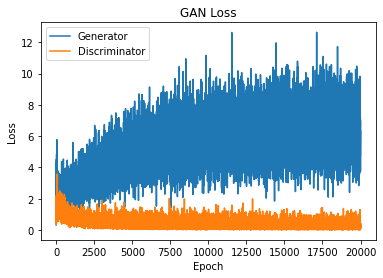

In [6]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Generator', 'Discriminator'], loc='upper left')
plt.show()